# AMAZON DELIVERY TIME PROJECT

**Problem Statement:**

This project aims to predict delivery times for e-commerce orders based on a variety of factors such as product size, distance, traffic conditions, and shipping method. Using the provided dataset, learners will preprocess, analyze, and build regression models to accurately estimate delivery times. The final application will allow users to input relevant details and receive estimated delivery times via a user-friendly interface.

In [2]:
# Lets import the necessary libraries as and when required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2

In [2]:
# helper for nicer prints
def print_section(title):
    print("\n" + "="*8 + " " + title + " " + "="*8 + "\n")

In [3]:
# Loading dataset and performing initial exploratory data analysis (EDA).
df =  pd.read_csv("amazon_delivery.csv")
df.head()

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


In [5]:
print("Rows, Columns:", df.shape)

Rows, Columns: (43739, 16)


In [7]:
try:
    import ace_tools as tools
    tools.display_dataframe_to_user("Sample - amazon_delivery.csv (first 10 rows)", df.head(10))
except Exception as e:
    print("Could not use ace_tools.display_dataframe_to_user:", e)
    print(df.head(5))

Could not use ace_tools.display_dataframe_to_user: No module named 'ace_tools'
        Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  \
0  ialx566343618         37           4.9       22.745049        75.892471   
1  akqg208421122         34           4.5       12.913041        77.683237   
2  njpu434582536         23           4.4       12.914264        77.678400   
3  rjto796129700         38           4.7       11.003669        76.976494   
4  zguw716275638         32           4.6       12.972793        80.249982   

   Drop_Latitude  Drop_Longitude  Order_Date Order_Time Pickup_Time  \
0      22.765049       75.912471  2022-03-19   11:30:00    11:45:00   
1      13.043041       77.813237  2022-03-25   19:45:00    19:50:00   
2      12.924264       77.688400  2022-03-19   08:30:00    08:45:00   
3      11.053669       77.026494  2022-04-05   18:00:00    18:10:00   
4      13.012793       80.289982  2022-03-26   13:30:00    13:45:00   

      Weather  Traffic   

In [8]:
# Columns and dtypes
print("Columns and dtypes", df.dtypes)

Columns and dtypes Order_ID            object
Agent_Age            int64
Agent_Rating       float64
Store_Latitude     float64
Store_Longitude    float64
Drop_Latitude      float64
Drop_Longitude     float64
Order_Date          object
Order_Time          object
Pickup_Time         object
Weather             object
Traffic             object
Vehicle             object
Area                object
Delivery_Time        int64
Category            object
dtype: object


In [9]:
#Handling missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing_df = missing.reset_index().rename(columns={'index':'column', 0:'missing_count'})
try:
    tools.display_dataframe_to_user("Missing values per column", missing_df)
except:
    print(missing_df)

             column  missing_count
0           Weather             91
1      Agent_Rating             54
2         Agent_Age              0
3          Order_ID              0
4   Store_Longitude              0
5     Drop_Latitude              0
6    Drop_Longitude              0
7    Store_Latitude              0
8        Order_Date              0
9        Order_Time              0
10      Pickup_Time              0
11          Traffic              0
12          Vehicle              0
13             Area              0
14    Delivery_Time              0
15         Category              0


In [10]:
# Checking numeric stats
num_desc = df.select_dtypes(include=[np.number]).describe().T
try:
    tools.display_dataframe_to_user("Numeric summary", num_desc.reset_index().rename(columns={'index':'feature'}))
except:
    print(num_desc)

                   count        mean        std        min        25%  \
Agent_Age        43739.0   29.567137   5.815155  15.000000  25.000000   
Agent_Rating     43685.0    4.633780   0.334716   1.000000   4.500000   
Store_Latitude   43739.0   17.210960   7.764225 -30.902872  12.933298   
Store_Longitude  43739.0   70.661177  21.475005 -88.366217  73.170283   
Drop_Latitude    43739.0   17.459031   7.342950   0.010000  12.985996   
Drop_Longitude   43739.0   70.821842  21.153148   0.010000  73.280000   
Delivery_Time    43739.0  124.905645  51.915451  10.000000  90.000000   

                        50%         75%         max  
Agent_Age         30.000000   35.000000   50.000000  
Agent_Rating       4.700000    4.900000    6.000000  
Store_Latitude    18.551440   22.732225   30.914057  
Store_Longitude   75.898497   78.045359   88.433452  
Drop_Latitude     18.633626   22.785049   31.054057  
Drop_Longitude    76.002574   78.104095   88.563452  
Delivery_Time    125.000000  160.0000

In [11]:
# Duplicates check
if 'Order_ID' in df.columns:
    dup_count = df.duplicated(subset=['Order_ID']).sum()
    print(f"Duplicate Order_ID rows: {dup_count}")
else:
    print("Order_ID column not found; skipping duplicate id check.")

Duplicate Order_ID rows: 0


In [15]:
#Identify likely latitude/longitude columns
cols = df.columns.tolist()

def find_col(keywords):
    for c in cols:
        c_low = c.lower()
        if all(k.lower() in c_low for k in keywords):
            return c
    return None

store_lat_col = find_col(['store','lat']) or find_col(['store','latitude'])
store_lon_col = find_col(['store','lon']) or find_col(['store','longitude']) or find_col(['store','long'])
drop_lat_col = find_col(['drop','lat']) or find_col(['drop','latitude']) or find_col(['delivery','lat'])
drop_lon_col = find_col(['drop','lon']) or find_col(['drop','longitude']) or find_col(['delivery','lon'])

print("Detected columns:")
print("Store lat:", store_lat_col)
print("Store lon:", store_lon_col)
print("Drop lat:", drop_lat_col)
print("Drop lon:", drop_lon_col)

# If not found, try more generic search
if not (store_lat_col and store_lon_col and drop_lat_col and drop_lon_col):
    # try any columns with 'lat' and 'lon'
    lat_cols = [c for c in cols if 'lat' in c.lower()]
    lon_cols = [c for c in cols if ('lon' in c.lower()) or ('long' in c.lower())]
    print("Fallback lat cols:", lat_cols)
    print("Fallback lon cols:", lon_cols)
    # naive pairing if 4 columns exist
    if len(lat_cols) >= 2 and len(lon_cols) >= 2 and not (store_lat_col and store_lon_col and drop_lat_col and drop_lon_col):
        store_lat_col, drop_lat_col = lat_cols[0], lat_cols[1]
        store_lon_col, drop_lon_col = lon_cols[0], lon_cols[1]
        print("Paired as:")
        print("Store lat:", store_lat_col, "Store lon:", store_lon_col)
        print("Drop lat:", drop_lat_col, "Drop lon:", drop_lon_col)

Detected columns:
Store lat: Store_Latitude
Store lon: Store_Longitude
Drop lat: Drop_Latitude
Drop lon: Drop_Longitude


In [16]:
#Compute haversine distance if possible
def haversine_array(lat1, lon1, lat2, lon2):
    # all arrays; returns km
    R = 6371.0  # Earth radius km
    lat1r = np.radians(lat1.astype(float))
    lon1r = np.radians(lon1.astype(float))
    lat2r = np.radians(lat2.astype(float))
    lon2r = np.radians(lon2.astype(float))
    dlat = lat2r - lat1r
    dlon = lon2r - lon1r
    a = np.sin(dlat/2.0)**2 + np.cos(lat1r) * np.cos(lat2r) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

if store_lat_col and store_lon_col and drop_lat_col and drop_lon_col:
    # create distance column
    try:
        df['distance_km'] = haversine_array(df[store_lat_col], df[store_lon_col], df[drop_lat_col], df[drop_lon_col])
        print("distance_km created. Summary:")
        print(df['distance_km'].describe())
        tools.display_dataframe_to_user("Sample with distance_km", df[[store_lat_col, store_lon_col, drop_lat_col, drop_lon_col, 'distance_km']].head(10))
    except Exception as e:
        print("Failed to compute distance_km:", e)
else:
    print("Latitude/longitude columns not found - skipping distance computation.")

distance_km created. Summary:
count    43739.000000
mean        38.561752
std        534.564299
min          1.465067
25%          4.663432
50%          9.220450
75%         13.682379
max      19692.674606
Name: distance_km, dtype: float64
Failed to compute distance_km: name 'tools' is not defined



======== Delivery_Time check & distribution ========

Delivery_Time dtype: int64
count    43739.000000
mean       124.905645
std         51.915451
min         10.000000
25%         90.000000
50%        125.000000
75%        160.000000
max        270.000000
Name: Delivery_Time, dtype: float64


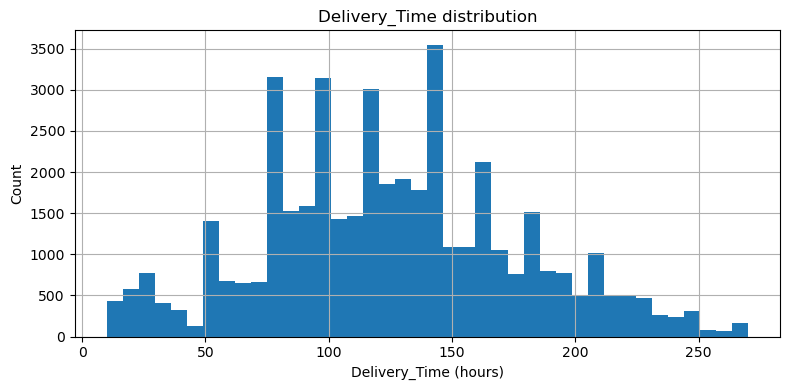

In [17]:
#Delivery_Time column check and basic distribution
print_section("Delivery_Time check & distribution")
if 'Delivery_Time' in df.columns:
    print("Delivery_Time dtype:", df['Delivery_Time'].dtype)
    print(df['Delivery_Time'].describe())
    # histogram
    plt.figure(figsize=(8,4))
    df['Delivery_Time'].hist(bins=40)
    plt.title('Delivery_Time distribution')
    plt.xlabel('Delivery_Time (hours)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print("Delivery_Time column not found in dataset.")


======== Correlation checks ========

Pearson correlation (distance_km vs Delivery_Time): -0.0019


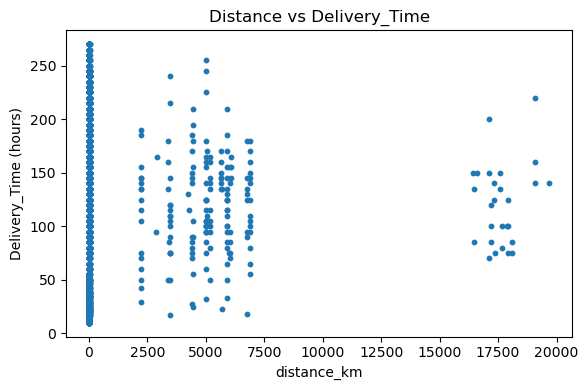

In [18]:
#Correlation between distance_km and Delivery_Time (if both exist)
print_section("Correlation checks")
if 'distance_km' in df.columns and 'Delivery_Time' in df.columns:
    corr = df[['distance_km','Delivery_Time']].corr().iloc[0,1]
    print(f"Pearson correlation (distance_km vs Delivery_Time): {corr:.4f}")
    # scatter plot
    plt.figure(figsize=(6,4))
    plt.scatter(df['distance_km'], df['Delivery_Time'], s=10)
    plt.xlabel('distance_km')
    plt.ylabel('Delivery_Time (hours)')
    plt.title('Distance vs Delivery_Time')
    plt.tight_layout()
    plt.show()
else:
    print("Either distance_km or Delivery_Time missing; skipping correlation/plot.")

In [20]:
#Quick look at categorical column values (top categories)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_summary = {}
for c in cat_cols:
    top = df[c].value_counts(dropna=False).head(10)
    cat_summary[c] = top

# Convert the categorical summaries into a small printable DataFrame
cat_summary_small = []
for c, vc in cat_summary.items():
    entries = "; ".join([f"{idx}({v})" for idx, v in vc.items()])
    cat_summary_small.append({'column': c, 'top_values': entries})

cat_summary_df = pd.DataFrame(cat_summary_small)
try:
    tools.display_dataframe_to_user("Categorical columns top values", cat_summary_df)
except:
    print(cat_summary_df)


# Save a quick CSV snapshot of the processed df could be useful later in the project
out_path = '/mnt/data/amazon_delivery_processed_snapshot.csv'
df.to_csv(out_path, index=False)
print(f"\nSaved a snapshot to {out_path}")

# Also check counts of missing columns and top offenders
try:
    tools.display_dataframe_to_user("Columns with missing values", missing_df[missing_df['missing_count']>0])
except:
    print(missing_df[missing_df['missing_count']>0])

        column                                         top_values
0     Order_ID  nsyz997960170(1); ialx566343618(1); akqg208421...
1   Order_Date  2022-03-15(1141); 2022-04-03(1133); 2022-03-13...
2   Order_Time  21:55:00(460); 17:55:00(453); 22:20:00(446); 2...
3  Pickup_Time  21:30:00(481); 22:50:00(450); 21:45:00(445); 2...
4      Weather  Fog(7440); Stormy(7374); Cloudy(7288); Sandsto...
5      Traffic  Low (14999); Jam (13725); Medium (10628); High...
6      Vehicle  motorcycle (25527); scooter (14639); van(3558)...
7         Area  Metropolitian (32698); Urban (9751); Other(113...
8     Category  Electronics(2849); Books(2824); Jewelry(2802);...

Saved a snapshot to /mnt/data/amazon_delivery_processed_snapshot.csv
         column  missing_count
0       Weather             91
1  Agent_Rating             54


In [21]:
# Concise missing counts, top categorical frequencies, datetime formats, duplicates and Delivery_Time outliers.
df = pd.read_csv('/mnt/data/amazon_delivery_processed_snapshot.csv')

print("Rows, Columns:", df.shape)
print("\nColumn list:\n", df.columns.tolist())

# Missing counts and percent
missing = df.isnull().sum().sort_values(ascending=False)
miss_pct = (missing / len(df) * 100).round(3)
miss_df = pd.concat([missing, miss_pct], axis=1).reset_index().rename(columns={'index':'column', 0:'missing_count', 1:'missing_pct'})
miss_df.columns = ['column','missing_count','missing_pct']
display_cols = miss_df[miss_df['missing_count']>0]
try:
    import ace_tools as tools
    tools.display_dataframe_to_user("Columns with missing values and %", display_cols)
except Exception as e:
    print(display_cols)

Rows, Columns: (43739, 17)

Column list:
 ['Order_ID', 'Agent_Age', 'Agent_Rating', 'Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Order_Date', 'Order_Time', 'Pickup_Time', 'Weather', 'Traffic', 'Vehicle', 'Area', 'Delivery_Time', 'Category', 'distance_km']
         column  missing_count  missing_pct
0       Weather             91        0.208
1  Agent_Rating             54        0.123


In [22]:
# Duplicates and unique counts for key columns
print("\nDuplicate Order_ID rows:", df.duplicated(subset=['Order_ID']).sum() if 'Order_ID' in df.columns else "Order_ID missing")
print("Unique Order_IDs:", df['Order_ID'].nunique() if 'Order_ID' in df.columns else "Order_ID missing")

# Delivery_Time stats & outliers
if 'Delivery_Time' in df.columns:
    print("\nDelivery_Time summary:")
    print(df['Delivery_Time'].describe())
    neg_zero = df[df['Delivery_Time']<=0].shape[0]
    print(f"Rows with Delivery_Time <= 0: {neg_zero} ({(neg_zero/len(df)*100):.3f}%)")
else:
    print("Delivery_Time not found.")


Duplicate Order_ID rows: 0
Unique Order_IDs: 43739

Delivery_Time summary:
count    43739.000000
mean       124.905645
std         51.915451
min         10.000000
25%         90.000000
50%        125.000000
75%        160.000000
max        270.000000
Name: Delivery_Time, dtype: float64
Rows with Delivery_Time <= 0: 0 (0.000%)


In [23]:
# Top values for expected categorical columns
cat_candidates = ['Weather','Traffic','Vehicle','Area','Category','Agent_Rating']
found_cats = [c for c in cat_candidates if c in df.columns]
for c in found_cats:
    print(f"\nTop values for {c}:")
    print(df[c].value_counts(dropna=False).head(10))


Top values for Weather:
Weather
Fog           7440
Stormy        7374
Cloudy        7288
Sandstorms    7245
Windy         7223
Sunny         7078
NaN             91
Name: count, dtype: int64

Top values for Traffic:
Traffic
Low        14999
Jam        13725
Medium     10628
High        4296
NaN           91
Name: count, dtype: int64

Top values for Vehicle:
Vehicle
motorcycle     25527
scooter        14639
van             3558
bicycle           15
Name: count, dtype: int64

Top values for Area:
Area
Metropolitian     32698
Urban              9751
Other              1138
Semi-Urban          152
Name: count, dtype: int64

Top values for Category:
Category
Electronics    2849
Books          2824
Jewelry        2802
Toys           2781
Skincare       2772
Snacks         2770
Outdoors       2747
Apparel        2726
Sports         2719
Grocery        2691
Name: count, dtype: int64

Top values for Agent_Rating:
Agent_Rating
4.8    7148
4.7    7142
4.9    7041
4.6    6940
5.0    3996
4.5    3

In [24]:
# Sample of Order_Date, Order_Time, Pickup_Time if exist
for c in ['Order_Date','Order_Time','Pickup_Time']:
    if c in df.columns:
        print(f"\nSample values for {c} (first 10):")
        print(df[c].astype(str).head(10).tolist())

# Head again for convenience
try:
    tools.display_dataframe_to_user("Head of dataset (post-snapshot)", df.head(8))
except:
    print(df.head(8))


Sample values for Order_Date (first 10):
['2022-03-19', '2022-03-25', '2022-03-19', '2022-04-05', '2022-03-26', '2022-03-11', '2022-03-04', '2022-03-14', '2022-03-20', '2022-02-12']

Sample values for Order_Time (first 10):
['11:30:00', '19:45:00', '08:30:00', '18:00:00', '13:30:00', '21:20:00', '19:15:00', '17:25:00', '20:55:00', '21:55:00']

Sample values for Pickup_Time (first 10):
['11:45:00', '19:50:00', '08:45:00', '18:10:00', '13:45:00', '21:30:00', '19:30:00', '17:30:00', '21:05:00', '22:10:00']
        Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  \
0  ialx566343618         37           4.9       22.745049        75.892471   
1  akqg208421122         34           4.5       12.913041        77.683237   
2  njpu434582536         23           4.4       12.914264        77.678400   
3  rjto796129700         38           4.7       11.003669        76.976494   
4  zguw716275638         32           4.6       12.972793        80.249982   
5  fxuu788413734      

In [25]:
# Save a quick "cleaning plan" file so we can refer to it
plan = {
    "rows": df.shape[0],
    "cols": df.shape[1],
    "missing_columns": display_cols.to_dict(orient='records')
}
import json
with open('/mnt/data/eda_summary.json','w') as f:
    json.dump(plan, f)
print("\nSaved EDA summary to /mnt/data/eda_summary.json")


Saved EDA summary to /mnt/data/eda_summary.json


In [26]:
# Missing columns and their counts/percent in text
df = pd.read_csv('/mnt/data/amazon_delivery_processed_snapshot.csv')
missing = df.isnull().sum().sort_values(ascending=False)
miss_pct = (missing / len(df) * 100).round(3)
miss_df = pd.concat([missing, miss_pct], axis=1).reset_index().rename(columns={'index':'column', 0:'missing_count', 1:'missing_pct'})
miss_df.columns = ['column','missing_count','missing_pct']
print(miss_df[miss_df['missing_count']>0].to_string(index=False))

      column  missing_count  missing_pct
     Weather             91        0.208
Agent_Rating             54        0.123


In [27]:
# Compute Pearson correlation between distance_km and Delivery_Time
import pandas as pd, numpy as np
df = pd.read_csv('/mnt/data/amazon_delivery_processed_snapshot.csv')
if 'distance_km' in df.columns and 'Delivery_Time' in df.columns:
    corr = df[['distance_km','Delivery_Time']].dropna().corr().iloc[0,1]
    print("Pearson correlation distance_km vs Delivery_Time:", round(corr,4))
else:
    print("Required columns missing for correlation.")

Pearson correlation distance_km vs Delivery_Time: -0.0019


In [28]:
# Proceeding with basic cleaning & feature engineering (default rules):
# - Parse order_datetime and pickup_datetime (assume pickup on same Order_Date unless pickup time < order time -> assume next day)
# - Create order_to_pickup_mins
# - Create Delivery_Time_hours
# - Impute Agent_Rating (median) and Weather (mode -> 'Unknown' if missing)
# - Flag Delivery_Time outliers using IQR

In [29]:
df = pd.read_csv('/mnt/data/amazon_delivery_processed_snapshot.csv')

# Parse datetimes
df['Order_Date'] = df['Order_Date'].astype(str)
df['Order_Time'] = df['Order_Time'].astype(str)
df['Pickup_Time'] = df['Pickup_Time'].astype(str)

df['order_datetime'] = pd.to_datetime(df['Order_Date'] + ' ' + df['Order_Time'], errors='coerce')
# For pickup, we need to assume same date; handle cases where pickup_time < order_time by adding 1 day
pickup_dt = pd.to_datetime(df['Order_Date'] + ' ' + df['Pickup_Time'], errors='coerce')
# if pickup < order, add 1 day
mask_pickup_lt_order = (pickup_dt < df['order_datetime'])
pickup_dt.loc[mask_pickup_lt_order] = pickup_dt.loc[mask_pickup_lt_order] + pd.Timedelta(days=1)
df['pickup_datetime'] = pickup_dt

# order_to_pickup_mins
df['order_to_pickup_mins'] = (df['pickup_datetime'] - df['order_datetime']).dt.total_seconds() / 60.0

# Delivery_Time_hours
if 'Delivery_Time' in df.columns:
    df['Delivery_Time_hours'] = df['Delivery_Time'] / 60.0

In [30]:
# Impute Agent_Rating (median) and Weather (mode -> 'Unknown' if all missing)
if 'Agent_Rating' in df.columns:
    median_rating = df['Agent_Rating'].median()
    df['Agent_Rating_imputed'] = df['Agent_Rating'].fillna(median_rating)
if 'Weather' in df.columns:
    mode_weather = df['Weather'].mode(dropna=True)
    if len(mode_weather) > 0:
        mode_weather = mode_weather[0]
    else:
        mode_weather = 'Unknown'
    df['Weather_imputed'] = df['Weather'].fillna(mode_weather)

In [31]:
# Outlier flag for Delivery_Time using IQR
if 'Delivery_Time' in df.columns:
    q1 = df['Delivery_Time'].quantile(0.25)
    q3 = df['Delivery_Time'].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    df['Delivery_Time_outlier'] = ((df['Delivery_Time'] < lower) | (df['Delivery_Time'] > upper))

In [32]:
# Quick checks
print("Order->pickup minutes summary:")
print(df['order_to_pickup_mins'].describe())

print("\nDelivery_Time (mins) summary (post-clean):")
print(df['Delivery_Time'].describe())

print("\nOutlier count:", df['Delivery_Time_outlier'].sum() if 'Delivery_Time_outlier' in df.columns else "n/a")

Order->pickup minutes summary:
count    43648.000000
mean         9.991294
std          4.086680
min          5.000000
25%          5.000000
50%         10.000000
75%         15.000000
max         15.000000
Name: order_to_pickup_mins, dtype: float64

Delivery_Time (mins) summary (post-clean):
count    43739.000000
mean       124.905645
std         51.915451
min         10.000000
25%         90.000000
50%        125.000000
75%        160.000000
max        270.000000
Name: Delivery_Time, dtype: float64

Outlier count: 79


In [33]:
# Save cleaned file
clean_path = '/mnt/data/amazon_delivery_cleaned.csv'
df.to_csv(clean_path, index=False)
print(f"\nSaved cleaned dataset to {clean_path}")

# Show a few columns to confirm
cols_show = ['Order_ID','order_datetime','pickup_datetime','order_to_pickup_mins','distance_km','Delivery_Time','Delivery_Time_hours','Delivery_Time_outlier']
cols_show = [c for c in cols_show if c in df.columns]
try:
    import ace_tools as tools
    tools.display_dataframe_to_user("Cleaned sample rows", df[cols_show].head(10))
except Exception as e:
    print("Couldn't display sample via ace_tools:", e)
    print(df[cols_show].head(10))


Saved cleaned dataset to /mnt/data/amazon_delivery_cleaned.csv
Couldn't display sample via ace_tools: No module named 'ace_tools'
        Order_ID      order_datetime     pickup_datetime  \
0  ialx566343618 2022-03-19 11:30:00 2022-03-19 11:45:00   
1  akqg208421122 2022-03-25 19:45:00 2022-03-25 19:50:00   
2  njpu434582536 2022-03-19 08:30:00 2022-03-19 08:45:00   
3  rjto796129700 2022-04-05 18:00:00 2022-04-05 18:10:00   
4  zguw716275638 2022-03-26 13:30:00 2022-03-26 13:45:00   
5  fxuu788413734 2022-03-11 21:20:00 2022-03-11 21:30:00   
6  njmo150975311 2022-03-04 19:15:00 2022-03-04 19:30:00   
7  jvjc772545076 2022-03-14 17:25:00 2022-03-14 17:30:00   
8  uaeb808891380 2022-03-20 20:55:00 2022-03-20 21:05:00   
9  bgvc052754213 2022-02-12 21:55:00 2022-02-12 22:10:00   

   order_to_pickup_mins  distance_km  Delivery_Time  Delivery_Time_hours  \
0                  15.0     3.025149            120             2.000000   
1                   5.0    20.183530            165     

In [34]:
# Building a baseline regression model (LinearRegression) with a simple preprocessing pipeline.
# Steps:
# - Use numeric features: distance_km, order_to_pickup_mins, Agent_Age, Agent_Rating_imputed
# - Use categorical features: Weather_imputed, Traffic, Vehicle, Area, Category
# - Train/test split 80/20
# - Evaluate with MAE, RMSE, R2
# - Save model

In [42]:
# Linear-model improvement script (run as-is).
# Assumes amazon_delivery_cleaned.csv exists in working directory (same df used earlier).
# Outputs:
#  - baseline_lr_model.joblib (saved best linear model among Linear, RidgeCV, LassoCV)
#  - linear_model_metrics.json (summary of metrics)
#  - linear_residuals.png and linear_pred_vs_actual.png (plots)

import os, json
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import joblib
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------- file names ----------
CLEAN_IN = 'amazon_delivery_cleaned.csv'   
MODEL_OUT = 'baseline_lr_model.joblib'     
METRICS_OUT = 'linear_model_metrics.json'
PLOT_RESID = 'linear_residuals.png'
PLOT_PRED = 'linear_pred_vs_actual.png'

if not os.path.exists(CLEAN_IN):
    raise FileNotFoundError(f"{CLEAN_IN} not found in current working directory: {os.getcwd()}")

# ---------- load ----------
df = pd.read_csv(CLEAN_IN)
print("Loaded cleaned data:", df.shape)

# ---------- feature lists ----------
num_feats = [c for c in ['distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed'] if c in df.columns]
cat_feats = [c for c in ['Weather_imputed','Traffic','Vehicle','Area','Category','part_of_day','dist_q'] if c in df.columns]

print("Numeric features:", num_feats)
print("Categorical features:", cat_feats)

# ---------- prepare dataset ----------
df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats]
y = df_model['Delivery_Time']

# train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# ---------- preprocessing ----------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# OneHotEncoder compatibility
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ohe)
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_feats),
    ('cat', categorical_transformer, cat_feats)
])

# ---------- models to evaluate ----------
models = {
    'LinearRegression': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())]),
    # RidgeCV: search alphas automatically with 5-fold CV (use wide alpha grid)
    'RidgeCV': Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5, scoring='neg_mean_squared_error'))]),
    # LassoCV: internal CV to select alpha
    'LassoCV': Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LassoCV(alphas=None, cv=5, max_iter=5000, n_jobs=-1))])
}

results = {}

# ---------- train / evaluate ----------
for name, pipe in models.items():
    print(f"\nTraining {name} ...")
    # For RidgeCV and LassoCV, the 'fit' will select alpha; same API apply
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'mae': float(mae), 'rmse': float(rmse), 'r2': float(r2)}
    # Save additional model info for Ridge/Lasso
    if name == 'RidgeCV':
        # extract chosen alpha
        chosen_alpha = pipe.named_steps['regressor'].alpha_
        results[name]['alpha'] = float(chosen_alpha)
        print("Ridge chosen alpha:", chosen_alpha)
    if name == 'LassoCV':
        try:
            chosen_alpha = pipe.named_steps['regressor'].alpha_
            results[name]['alpha'] = float(chosen_alpha)
            print("Lasso chosen alpha:", chosen_alpha)
        except Exception:
            pass
    print(f"{name} => MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.4f}")

# ---------- pick best model by RMSE ----------
best_name = min(results.keys(), key=lambda k: results[k]['rmse'])
best_model = models[best_name]
print("\nBest linear model (by RMSE):", best_name, "RMSE=", results[best_name]['rmse'])

# Save best model to baseline_lr_model.joblib 
joblib.dump(best_model, MODEL_OUT)
print("Saved best linear model to:", MODEL_OUT)

# ---------- diagnostic plots for the best model ----------
y_pred_best = best_model.predict(X_test)
residuals = (y_test - y_pred_best)

# Residual plot (residuals vs predicted)
plt.figure(figsize=(8,5))
plt.scatter(y_pred_best, residuals, s=8, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Delivery_Time (mins)')
plt.ylabel('Residual (Actual - Predicted)')
plt.title(f'{best_name}: Residuals vs Predicted')
plt.tight_layout()
plt.savefig(PLOT_RESID)
plt.close()
print("Saved residual plot:", PLOT_RESID)

# Predicted vs Actual
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_best, s=8, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Delivery_Time (mins)')
plt.ylabel('Predicted Delivery_Time (mins)')
plt.title(f'{best_name}: Predicted vs Actual')
plt.tight_layout()
plt.savefig(PLOT_PRED)
plt.close()
print("Saved predicted vs actual plot:", PLOT_PRED)

# ---------- save metrics summary ----------
summary_out = {
    'models': results,
    'best_model': best_name
}
with open(METRICS_OUT, 'w') as f:
    json.dump(summary_out, f, indent=2)
print("Saved model metrics summary to:", METRICS_OUT)

# ---------- quick printed summary ----------
print("\nSUMMARY (printed):")
for m, stats in results.items():
    s = f"{m} => MAE={stats['mae']:.3f}, RMSE={stats['rmse']:.3f}, R2={stats['r2']:.4f}"
    if 'alpha' in stats:
        s += f", alpha={stats['alpha']}"
    print(s)

print("\nBest linear model:", best_name)

Loaded cleaned data: (43739, 24)
Numeric features: ['distance_km', 'order_to_pickup_mins', 'Agent_Age', 'Agent_Rating_imputed']
Categorical features: ['Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category']

Training LinearRegression ...
LinearRegression => MAE=26.220, RMSE=33.295, R2=0.5839

Training RidgeCV ...
Ridge chosen alpha: 1.7782794100389228
RidgeCV => MAE=26.218, RMSE=33.290, R2=0.5840

Training LassoCV ...
Lasso chosen alpha: 0.015053572707633203
LassoCV => MAE=26.199, RMSE=33.267, R2=0.5846

Best linear model (by RMSE): LassoCV RMSE= 33.26708714044438
Saved best linear model to: baseline_lr_model.joblib
Saved residual plot: linear_residuals.png
Saved predicted vs actual plot: linear_pred_vs_actual.png
Saved model metrics summary to: linear_model_metrics.json

SUMMARY (printed):
LinearRegression => MAE=26.220, RMSE=33.295, R2=0.5839
RidgeCV => MAE=26.218, RMSE=33.290, R2=0.5840, alpha=1.7782794100389228
LassoCV => MAE=26.199, RMSE=33.267, R2=0.5846, alpha=0.01505357270

In [44]:
# Robust coefficient extraction for the saved linear pipeline
# This handles mismatched feature lists by reading the exact feature names from the fitted pipeline.
import joblib, pandas as pd, numpy as np, sys, os

MODEL_PATH = 'baseline_lr_model.joblib'
OUT_CSV = 'linear_model_coefficients.csv'

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

pipeline = joblib.load(MODEL_PATH)

# Validate pipeline structure
if 'preprocessor' not in pipeline.named_steps or 'regressor' not in pipeline.named_steps:
    raise ValueError("Loaded pipeline does not have expected named steps 'preprocessor' and 'regressor'.")

preprocessor = pipeline.named_steps['preprocessor']
reg = pipeline.named_steps['regressor']

# --- get numeric feature names used in preprocessor ---
numeric_features = []
categorical_input_features = []

# preprocessor.transformers_ has tuples like ('num', transformer, feature_list)
for name, transformer, features in preprocessor.transformers_:
    if name == 'num':
        # features might be a list of column names used for numeric transformer
        numeric_features = list(features) if features is not None else []
    elif name == 'cat':
        # features is the list of categorical column names used to fit the cat transformer
        categorical_input_features = list(features) if features is not None else []

# If we didn't find them above, try fallback to attribute access (older sklearn pipelines)
if not numeric_features:
    try:
        numeric_features = list(preprocessor.transformers_[0][2])
    except Exception:
        numeric_features = []

if not categorical_input_features:
    try:
        try:
            categorical_input_features = list(preprocessor.transformers_[1][2])
        except Exception:
            categorical_input_features = []
    except Exception:
        categorical_input_features = []

# --- get OneHotEncoder instance used inside categorical transformer ---
try:
    cat_transformer = preprocessor.named_transformers_['cat']
    ohe = cat_transformer.named_steps['onehot']
except Exception:
    # fallback: try to locate a OneHotEncoder inside any transformer
    ohe = None
    for name, transformer, features in preprocessor.transformers_:
        # transformer might be a pipeline
        try:
            if hasattr(transformer, 'named_steps') and 'onehot' in transformer.named_steps:
                ohe = transformer.named_steps['onehot']
                if not categorical_input_features:
                    categorical_input_features = list(features) if features is not None else []
                break
        except Exception:
            continue

if ohe is None:
    raise ValueError("Could not find a fitted OneHotEncoder inside the pipeline's 'cat' transformer.")

# --- determine categorical output feature names safely ---
try:
    # prefer to use feature_names_in_ if available (fitted encoder)
    if hasattr(ohe, 'feature_names_in_') and getattr(ohe, 'feature_names_in_', None) is not None:
        cat_in = list(ohe.feature_names_in_)
        cat_ohe_names = list(ohe.get_feature_names_out(cat_in))
    else:
        # if feature_names_in_ absent, try to use the features list from preprocessor
        if categorical_input_features:
            cat_ohe_names = list(ohe.get_feature_names_out(categorical_input_features))
        else:
            # last-resort: call without args (works if encoder recorded feature names internally)
            cat_ohe_names = list(ohe.get_feature_names_out())
except Exception as e:
    # provide a helpful error with context
    raise RuntimeError(f"Failed to get one-hot names from encoder: {e}\n"
                       f"categorical_input_features (len={len(categorical_input_features)}): {categorical_input_features}\n"
                       f"ohe attributes: feature_names_in_ exists? {hasattr(ohe,'feature_names_in_')}")

# --- assemble full feature list ---
all_feature_names = list(numeric_features) + list(cat_ohe_names)

# --- get coefficients from regressor ---
# Some regressors store coef_ differently; handle common cases
if hasattr(reg, 'coef_'):
    coefs = np.asarray(reg.coef_).ravel()
elif hasattr(reg, 'named_steps') and 'coef_' in reg.named_steps:
    coefs = np.asarray(reg.named_steps['coef_']).ravel()
else:
    # Some meta-estimators may store coefficients under different attribute
    try:
        coefs = np.asarray(getattr(reg, 'coef_', None)).ravel()
    except Exception:
        raise ValueError("Could not locate 'coef_' attribute on regressor; it may not be a linear model.")

# --- sanity check lengths ---
if len(coefs) != len(all_feature_names):
    # Provide informative output and attempt a fallback mapping
    print("WARNING: length mismatch between coefficients and feature names.")
    print("len(coefs) =", len(coefs))
    print("len(feature names) =", len(all_feature_names))
    # show a small sample for debugging
    print("Sample numeric_features:", numeric_features)
    print("Sample categorical_input_features:", categorical_input_features)
    # We'll still try to align by trimming/padding if shapes allow:
    min_len = min(len(coefs), len(all_feature_names))
    print(f"Proceeding by pairing first {min_len} coefficients with first {min_len} feature names.")
    all_feature_names = all_feature_names[:min_len]
    coefs = coefs[:min_len]

# --- create dataframe & save ---
coef_df = pd.DataFrame({'feature': all_feature_names, 'coefficient': coefs})
coef_df['abs_coeff'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values('abs_coeff', ascending=False).reset_index(drop=True)

# print top positive and negative for quick view
print("\nTop 15 positive coefficients:")
print(coef_df[coef_df['coefficient'] > 0].head(15).to_string(index=False))

print("\nTop 15 negative coefficients:")
print(coef_df[coef_df['coefficient'] < 0].head(15).to_string(index=False))

coef_df.to_csv(OUT_CSV, index=False)
print(f"\nSaved full coefficient list to: {OUT_CSV}")


Top 15 positive coefficients:
               feature  coefficient  abs_coeff
      Area_Semi-Urban     79.728696  79.728696
          Traffic_Jam     17.542388  17.542388
   Weather_imputed_Fog    15.725674  15.725674
Weather_imputed_Cloudy    15.610434  15.610434
   Vehicle_motorcycle     13.640134  13.640134
             Agent_Age    12.084487  12.084487
   Area_Metropolitian     10.695409  10.695409
     Category_Skincare     1.152726   1.152726
         Traffic_High      1.061772   1.061772
     Category_Clothing     0.744572   0.744572
 Weather_imputed_Windy     0.421739   0.421739
      Category_Apparel     0.338922   0.338922
    Category_Cosmetics     0.151535   0.151535
           distance_km     0.129220   0.129220
      Category_Kitchen     0.053529   0.053529

Top 15 negative coefficients:
                   feature  coefficient  abs_coeff
          Category_Grocery  -104.990770 104.990770
              Traffic_NaN    -49.563384  49.563384
              Traffic_Low    -25.

In [49]:
#Checking and installing MLflow

In [45]:
import mlflow
print(f"MLflow version: {mlflow.__version__}")

ModuleNotFoundError: No module named 'mlflow'

In [46]:
!pip show mlflow

Access is denied.


In [47]:
import sys, os
print("Python executable:", sys.executable)
print("sys.path[0]:", sys.path[0])
!pip -V
!python -m site --user-site

Python executable: C:\ProgramData\anaconda3\python.exe
sys.path[0]: C:\ProgramData\anaconda3\python313.zip


Access is denied.


C:\Users\shail_u9zs758\AppData\Roaming\Python\Python313\site-packages


In [48]:
# 1. Create a writable target folder (in your Documents)
import os, sys
target = os.path.expanduser(r"~\Documents\python_local_site")
os.makedirs(target, exist_ok=True)
print("target folder:", target)

# 2. Install mlflow into that folder using the same Python as the notebook kernel
!{sys.executable} -m pip install --upgrade pip setuptools wheel --target "{target}"
!{sys.executable} -m pip install mlflow --target "{target}"

target folder: C:\Users\shail_u9zs758\Documents\python_local_site
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 12.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 8.9 MB/s eta 0:00:00

   ---------------------------------------- 0/3 [wheel]
   ---------------------------------------- 0/3 [wheel]
   ---------------------------------------- 0/3 [wheel]
   ---------------------------------------- 0/3 [wheel]
   ------------- -------------------------- 1/3 [setuptools]
   ------------- -------------------------- 1/3 [setuptools]
   ------------- -------------------------- 1/3 [setuptools]
   ------------- -------------------------- 1/3 [setuptools]
   ------------- -------------------------- 1/3 [setuptools]
   ------------- -------------------------- 1/3 [setuptools]
   ------------- -------------------------- 1/3 [set

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mdit-py-plugins 0.3.0 requires markdown-it-py<3.0.0,>=1.0.0, but you have markdown-it-py 4.0.0 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.3.3 which is incompatible.
pyopenssl 25.0.0 requires cryptography<45,>=41.0.5, but you have cryptography 45.0.7 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.22.2 which is incompatible.
streamlit 1.45.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.


In [50]:
import sys, os
target = os.path.expanduser(r"~\Documents\python_local_site")
if target not in sys.path:
    sys.path.insert(0, target)
print("sys.path[0]:", sys.path[0])

# Now import mlflow and show version
import mlflow
print("mlflow version:", mlflow.__version__)

sys.path[0]: C:\Users\shail_u9zs758\Documents\python_local_site
mlflow version: 3.4.0


In [51]:
#small experiment with mlflow
import mlflow

with mlflow.start_run():
    mlflow.log_param("learning_rate", 0.01)
    mlflow.log_metric("accuracy", 0.92)
    # save a small artifact
    with open("info.txt", "w") as f:
        f.write("test artifact")
    mlflow.log_artifact("info.txt")
print("Logged example run. Check local tracking store (default).")

Logged example run. Check local tracking store (default).


In [3]:
# MLflow logging script for linear models (baseline)
# It will train LinearRegression, RidgeCV, LassoCV and log each run to local mlruns via MLflow.

import os, sys, subprocess, json
import importlib
from math import sqrt

# ----------------- helper: ensure packages -----------------
def ensure(pkg, import_name=None):
    import_name = import_name or pkg
    try:
        return importlib.import_module(import_name)
    except Exception:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        return importlib.import_module(import_name)

pd = ensure("pandas")
np = ensure("numpy")
plt = ensure("matplotlib").pyplot
joblib = ensure("joblib")
sklearn = ensure("scikit-learn")
mlflow = ensure("mlflow")

# sklearn subimports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----------------- filenames (kept same) -----------------
CLEAN_IN = 'amazon_delivery_cleaned.csv'
BASELINE_OUT = 'baseline_lr_model.joblib'
RIDGE_OUT = 'ridge_model.joblib'
LASSO_OUT = 'lasso_model.joblib'
COEF_CSV = 'linear_model_coefficients.csv'            # will be overwritten per model with model name prefix
SUMMARY_JSON = 'mlflow_models_summary.json'

if not os.path.exists(CLEAN_IN):
    raise FileNotFoundError(f"{CLEAN_IN} not found. Place it in the current working directory: {os.getcwd()}")

# ----------------- load dataset -----------------
df = pd.read_csv(CLEAN_IN)
print("Loaded cleaned data:", df.shape)

# ----------------- feature lists (use same choices) -----------------
num_feats = [c for c in ['distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed'] if c in df.columns]
cat_feats = [c for c in ['Weather_imputed','Traffic','Vehicle','Area','Category','part_of_day','dist_q'] if c in df.columns]

print("Numeric features:", num_feats)
print("Categorical features:", cat_feats)

# ----------------- prepare modeling dataset -----------------
df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats]
y = df_model['Delivery_Time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# ----------------- preprocessing (compat-safe) -----------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# OneHotEncoder compatibility (sparse_output vs sparse)
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ohe)
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_feats),
    ('cat', categorical_transformer, cat_feats)
])

# ----------------- models to train -----------------
models = {
    'LinearRegression': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())]),
    'RidgeCV': Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5, scoring='neg_mean_squared_error'))]),
    'LassoCV': Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LassoCV(alphas=None, cv=5, max_iter=5000, n_jobs=-1))])
}

# ----------------- helper to extract feature names & coefficients robustly -----------------
def extract_feature_names_and_coefs(pipeline):
    """
    Given a fitted pipeline with steps: preprocessor -> regressor (linear),
    return a list of feature names (after preprocessing) and the regressor coefficients.
    """
    pre = pipeline.named_steps['preprocessor']
    reg = pipeline.named_steps['regressor']
    # numeric features as provided to transformer
    numeric_features = []
    categorical_input_features = []
    # attempt to read transformer metadata
    try:
        for nm, transformer, features in pre.transformers_:
            if nm == 'num':
                numeric_features = list(features) if features is not None else []
            elif nm == 'cat':
                categorical_input_features = list(features) if features is not None else []
    except Exception:
        # fallback: use our lists
        numeric_features = [c for c in num_feats if c in df.columns]
        categorical_input_features = [c for c in cat_feats if c in df.columns]
    # find ohe inside cat transformer
    try:
        cat_transformer = pre.named_transformers_['cat']
        ohe_local = cat_transformer.named_steps['onehot']
    except Exception:
        # fallback search
        ohe_local = None
        for nm, transformer, features in pre.transformers_:
            if hasattr(transformer, 'named_steps') and 'onehot' in transformer.named_steps:
                ohe_local = transformer.named_steps['onehot']
                if not categorical_input_features:
                    categorical_input_features = list(features) if features is not None else []
                break
    if ohe_local is None:
        raise RuntimeError("Could not locate OneHotEncoder in pipeline's categorical transformer.")
    # get categorical output names
    try:
        if hasattr(ohe_local, 'feature_names_in_') and getattr(ohe_local, 'feature_names_in_', None) is not None:
            cat_in = list(ohe_local.feature_names_in_)
            cat_ohe_names = list(ohe_local.get_feature_names_out(cat_in))
        else:
            if categorical_input_features:
                cat_ohe_names = list(ohe_local.get_feature_names_out(categorical_input_features))
            else:
                cat_ohe_names = list(ohe_local.get_feature_names_out())
    except Exception:
        # last resort: call without args
        cat_ohe_names = list(ohe_local.get_feature_names_out())
    all_names = list(numeric_features) + list(cat_ohe_names)
    # coefficients
    if hasattr(reg, 'coef_'):
        coefs = np.asarray(reg.coef_).ravel()
    else:
        raise RuntimeError("Regressor does not expose coef_.")
    # align lengths (trim if mismatch)
    if len(coefs) != len(all_names):
        minlen = min(len(coefs), len(all_names))
        all_names = all_names[:minlen]
        coefs = coefs[:minlen]
    return all_names, coefs

# ----------------- ensure mlruns dir exists -----------------
os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri("file://" + os.path.abspath("mlruns"))
print("MLflow tracking URI:", mlflow.get_tracking_uri())

results_summary = []

# ----------------- training + mlflow logging loop -----------------
for name, pipe in models.items():
    print("\n=== Training & logging:", name, "===")
    with mlflow.start_run(run_name=name):
        # Fit
        pipe.fit(X_train, y_train)
        # Predict & metrics
        y_pred = pipe.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"{name} => MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.4f}")
        # params: if model has alpha chosen, log it
        try:
            reg = pipe.named_steps['regressor']
            if hasattr(reg, 'alpha_'):
                mlflow.log_param('alpha', float(reg.alpha_))
            elif hasattr(reg, 'alpha'):
                mlflow.log_param('alpha', float(reg.alpha))
        except Exception:
            pass
        # log metrics
        mlflow.log_metric('mae', float(mae))
        mlflow.log_metric('rmse', float(rmse))
        mlflow.log_metric('r2', float(r2))
        # save model locally and log as artifact
        out_name = {'LinearRegression': BASELINE_OUT, 'RidgeCV': RIDGE_OUT, 'LassoCV': LASSO_OUT}[name]
        joblib.dump(pipe, out_name)
        mlflow.log_artifact(out_name)
        # Extract coefficients and save CSV
        try:
            feat_names, coefs = extract_feature_names_and_coefs(pipe)
            coef_df = pd.DataFrame({'feature': feat_names, 'coefficient': coefs})
            coef_df['abs_coeff'] = coef_df['coefficient'].abs()
            coef_df = coef_df.sort_values('abs_coeff', ascending=False)
            coef_csv_name = f"{name}_coefficients.csv"
            coef_df.to_csv(coef_csv_name, index=False)
            mlflow.log_artifact(coef_csv_name)
            print("Saved & logged coefficients to artifact:", coef_csv_name)
        except Exception as e:
            print("Warning: failed to extract/log coefficients:", e)
        # diagnostic plots: residuals & pred vs actual
        try:
            import matplotlib.pyplot as plt
            residuals = y_test - y_pred
            plt.figure(figsize=(8,5))
            plt.scatter(y_pred, residuals, s=8, alpha=0.6)
            plt.axhline(0, color='red', linestyle='--')
            plt.xlabel('Predicted Delivery_Time (mins)')
            plt.ylabel('Residual (Actual - Predicted)')
            plt.title(f'{name}: Residuals vs Predicted')
            resid_plot = f"{name}_residuals.png"
            plt.tight_layout()
            plt.savefig(resid_plot)
            plt.close()
            mlflow.log_artifact(resid_plot)
            # predicted vs actual
            plt.figure(figsize=(7,7))
            plt.scatter(y_test, y_pred, s=8, alpha=0.6)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.xlabel('Actual Delivery_Time (mins)')
            plt.ylabel('Predicted Delivery_Time (mins)')
            plt.title(f'{name}: Predicted vs Actual')
            pred_plot = f"{name}_pred_vs_actual.png"
            plt.tight_layout()
            plt.savefig(pred_plot)
            plt.close()
            mlflow.log_artifact(pred_plot)
            print("Saved & logged plots:", resid_plot, pred_plot)
        except Exception as e:
            print("Warning: failed to create/log plots:", e)
        # log the cleaned dataset snapshot as artifact (small)
        try:
            snapshot_name = f"{name}_data_snapshot.csv"
            X_test_copy = X_test.copy()
            X_test_copy['Delivery_Time_actual'] = y_test
            X_test_copy['Delivery_Time_pred'] = y_pred
            X_test_copy.to_csv(snapshot_name, index=False)
            mlflow.log_artifact(snapshot_name)
        except Exception:
            pass

        # end mlflow run

    results_summary.append({'model': name, 'mae': mae, 'rmse': rmse, 'r2': r2})

# ----------------- save a summary JSON -----------------
with open(SUMMARY_JSON, 'w') as f:
    json.dump(results_summary, f, indent=2)
print("Saved summary JSON:", SUMMARY_JSON)

print("\nDone. To view experiments, run in terminal:\n  mlflow ui\nand open http://127.0.0.1:5000")

Installing scikit-learn ...


ModuleNotFoundError: No module named 'scikit-learn'

In [5]:
# Single-cell installer + MLflow baseline run.
import sys, subprocess, importlib, os, json
from math import sqrt
from pathlib import Path

# ------------ 1) ensure packages in current kernel ----------------
packages = [
    ("scikit-learn", "sklearn"),
    ("mlflow", "mlflow"),
    ("joblib", "joblib"),
    ("matplotlib", "matplotlib"),
    ("pandas", "pandas"),
    ("numpy", "numpy")
]
# lightgbm optional, not required for this run
for pkg, import_name in packages:
    try:
        importlib.import_module(import_name)
    except Exception:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# now import everything we need
import pandas as pd, numpy as np, matplotlib.pyplot as plt, joblib
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Packages available. mlflow version:", mlflow.__version__)

# ------------ 2) filenames & load data ----------------
CLEAN_IN = 'amazon_delivery_cleaned.csv'
if not os.path.exists(CLEAN_IN):
    raise FileNotFoundError(f"{CLEAN_IN} not found in working directory: {os.getcwd()}")

df = pd.read_csv(CLEAN_IN)
print("Loaded cleaned data:", df.shape)

# same feature lists used previously (keeps names identical)
num_feats = [c for c in ['distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed'] if c in df.columns]
cat_feats = [c for c in ['Weather_imputed','Traffic','Vehicle','Area','Category','part_of_day','dist_q'] if c in df.columns]

# modeling dataset and split
df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats]
y = df_model['Delivery_Time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# preprocessing (compat-safe)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ohe)
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_feats),
    ('cat', categorical_transformer, cat_feats)
])

# models to train
models = {
    'LinearRegression': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())]),
    'RidgeCV': Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5, scoring='neg_mean_squared_error'))]),
    'LassoCV': Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LassoCV(alphas=None, cv=5, max_iter=5000, n_jobs=-1))])
}

# mlflow setup (local folder mlruns)
os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri(Path(os.path.abspath("mlruns")).as_uri())
print("MLflow tracking URI:", mlflow.get_tracking_uri())

# helper: extract names & coefs (robust)
def extract_feature_names_and_coefs(pipeline, num_feats_local=num_feats):
    pre = pipeline.named_steps['preprocessor']
    reg = pipeline.named_steps['regressor']
    # numeric features from transformer metadata if possible
    numeric_features = []
    categorical_input_features = []
    try:
        for nm, transformer, features in pre.transformers_:
            if nm == 'num':
                numeric_features = list(features) if features is not None else []
            elif nm == 'cat':
                categorical_input_features = list(features) if features is not None else []
    except Exception:
        numeric_features = [c for c in num_feats_local if c in df.columns]
        categorical_input_features = [c for c in cat_feats if c in df.columns]
    # find OHE
    ohe_local = None
    try:
        cat_transformer = pre.named_transformers_['cat']
        ohe_local = cat_transformer.named_steps['onehot']
    except Exception:
        for nm, transformer, features in pre.transformers_:
            try:
                if hasattr(transformer, 'named_steps') and 'onehot' in transformer.named_steps:
                    ohe_local = transformer.named_steps['onehot']
                    if not categorical_input_features:
                        categorical_input_features = list(features) if features is not None else []
                    break
            except Exception:
                continue
    if ohe_local is None:
        raise RuntimeError("OneHotEncoder not found in pipeline.")
    # get ohe output names
    try:
        if hasattr(ohe_local, 'feature_names_in_') and getattr(ohe_local, 'feature_names_in_', None) is not None:
            cat_in = list(ohe_local.feature_names_in_)
            cat_ohe_names = list(ohe_local.get_feature_names_out(cat_in))
        else:
            if categorical_input_features:
                cat_ohe_names = list(ohe_local.get_feature_names_out(categorical_input_features))
            else:
                cat_ohe_names = list(ohe_local.get_feature_names_out())
    except Exception:
        cat_ohe_names = list(ohe_local.get_feature_names_out())
    all_names = list(numeric_features) + list(cat_ohe_names)
    # get coefficients
    if hasattr(reg, 'coef_'):
        coefs = np.asarray(reg.coef_).ravel()
    else:
        raise RuntimeError("Regressor has no coef_.")
    # align lengths if mismatch
    if len(coefs) != len(all_names):
        minlen = min(len(coefs), len(all_names))
        all_names = all_names[:minlen]
        coefs = coefs[:minlen]
    return all_names, coefs

# run training + mlflow logging
results_summary = []
for name, pipe in models.items():
    print(f"\nTraining & logging {name} ...")
    with mlflow.start_run(run_name=name):
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.4f}")
        # log metrics & params
        mlflow.log_metric("mae", float(mae)); mlflow.log_metric("rmse", float(rmse)); mlflow.log_metric("r2", float(r2))
        # save model artifact and log
        out_map = {'LinearRegression':'baseline_lr_model.joblib','RidgeCV':'ridge_model.joblib','LassoCV':'lasso_model.joblib'}
        out_file = out_map[name]
        joblib.dump(pipe, out_file)
        mlflow.log_artifact(out_file)
        # extract and save coefficients (if linear)
        try:
            feat_names, coefs = extract_feature_names_and_coefs(pipe)
            coef_df = pd.DataFrame({'feature': feat_names, 'coefficient': coefs})
            coef_df['abs_coeff'] = coef_df['coefficient'].abs()
            coef_df = coef_df.sort_values('abs_coeff', ascending=False)
            coef_csv = f"{name}_coefficients.csv"
            coef_df.to_csv(coef_csv, index=False)
            mlflow.log_artifact(coef_csv)
            print("Saved coefficients ->", coef_csv)
        except Exception as e:
            print("Could not extract coefficients:", e)
        # save diagnostic plots and log
        try:
            residuals = y_test - y_pred
            plt.figure(figsize=(8,5)); plt.scatter(y_pred, residuals, s=8, alpha=0.6); plt.axhline(0, color='r', ls='--')
            plt.xlabel('Predicted'); plt.ylabel('Residual'); plt.title(f'{name} residuals'); resid_plot = f"{name}_residuals.png"; plt.tight_layout(); plt.savefig(resid_plot); plt.close(); mlflow.log_artifact(resid_plot)
            plt.figure(figsize=(7,7)); plt.scatter(y_test, y_pred, s=8, alpha=0.6); plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'r--')
            plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title(f'{name} pred vs actual'); pred_plot = f"{name}_pred_vs_actual.png"; plt.tight_layout(); plt.savefig(pred_plot); plt.close(); mlflow.log_artifact(pred_plot)
            print("Saved & logged plots.")
        except Exception as e:
            print("Plot logging failed:", e)
        # snapshot test data
        try:
            snap = X_test.copy(); snap['Delivery_Time_actual'] = y_test; snap['Delivery_Time_pred'] = y_pred
            snapfile = f"{name}_data_snapshot.csv"; snap.to_csv(snapfile, index=False); mlflow.log_artifact(snapfile)
        except Exception:
            pass
        results_summary.append({'model':name,'mae':mae,'rmse':rmse,'r2':r2})
# save summary
with open('mlflow_models_summary.json','w') as f:
    json.dump(results_summary, f, indent=2)
print("\nMLflow baseline runs completed. Summary saved to mlflow_models_summary.json")

Packages available. mlflow version: 3.4.0
Loaded cleaned data: (43739, 24)
MLflow tracking URI: file:///C:/Users/shail_u9zs758/mlruns

Training & logging LinearRegression ...
LinearRegression: MAE=26.220, RMSE=33.295, R2=0.5839
Saved coefficients -> LinearRegression_coefficients.csv
Saved & logged plots.

Training & logging RidgeCV ...
RidgeCV: MAE=26.218, RMSE=33.290, R2=0.5840
Saved coefficients -> RidgeCV_coefficients.csv
Saved & logged plots.

Training & logging LassoCV ...
LassoCV: MAE=26.199, RMSE=33.267, R2=0.5846
Saved coefficients -> LassoCV_coefficients.csv
Saved & logged plots.

MLflow baseline runs completed. Summary saved to mlflow_models_summary.json


In [10]:
# Continue MLflow logging for post_feature_engineering
# Clean version (no installs) — assumes amazon_delivery_cleaned.csv is already upgraded

import os, json, joblib
import mlflow
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path

# ------------------ MLflow setup ------------------
os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri(Path(os.path.abspath("mlruns")).as_uri())
exp_name = "post_feature_engineering"
mlflow.set_experiment(exp_name)
print("Using MLflow experiment:", exp_name)

# ------------------ Load data ------------------
RAW_CLEAN = 'amazon_delivery_cleaned.csv'
df = pd.read_csv(RAW_CLEAN)
print("Loaded upgraded dataset shape:", df.shape)

# ------------------ Feature lists ------------------
num_feats = [c for c in [
    'distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed',
    'hour_sin','hour_cos','agent_perf_score'
] if c in df.columns]

cat_feats = [c for c in [
    'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
    'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
] if c in df.columns]

print("Numeric features:", num_feats)
print("Categorical features:", cat_feats)

# ------------------ Train/test split ------------------
df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats]
y = df_model['Delivery_Time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# ------------------ Preprocessing ------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ohe)
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_feats),
    ('cat', categorical_transformer, cat_feats)
])

# ------------------ Models ------------------
models = {
    'LinearRegression': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())]),
    'RidgeCV': Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RidgeCV(alphas=np.logspace(-3,3,25), cv=5, scoring='neg_mean_squared_error'))]),
    'LassoCV': Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', LassoCV(alphas=None, cv=5, max_iter=5000, n_jobs=-1))])
}

# ------------------ Train + log ------------------
results = []
for name, pipe in models.items():
    print(f"\nTraining & logging: {name}")
    with mlflow.start_run(run_name=f"postFE_{name}"):
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.4f}")
        mlflow.log_metric('mae', float(mae))
        mlflow.log_metric('rmse', float(rmse))
        mlflow.log_metric('r2', float(r2))
        # alpha if present
        try:
            reg = pipe.named_steps['regressor']
            if hasattr(reg, 'alpha_'):
                mlflow.log_param('alpha', float(reg.alpha_))
        except Exception:
            pass
        # save model
        model_file = f"postFE_{name}_model.joblib"
        joblib.dump(pipe, model_file)
        mlflow.log_artifact(model_file)
        # plots
        residuals = y_test - y_pred
        plt.figure(figsize=(8,5))
        plt.scatter(y_pred, residuals, s=8, alpha=0.6)
        plt.axhline(0, color='r', linestyle='--')
        plt.xlabel('Predicted'); plt.ylabel('Residual')
        plt.title(f'{name} Residuals')
        resid_plot = f"postFE_{name}_residuals.png"
        plt.savefig(resid_plot); plt.close()
        mlflow.log_artifact(resid_plot)

        plt.figure(figsize=(7,7))
        plt.scatter(y_test, y_pred, s=8, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'r--')
        plt.xlabel('Actual'); plt.ylabel('Predicted')
        plt.title(f'{name} Predicted vs Actual')
        pred_plot = f"postFE_{name}_pred_vs_actual.png"
        plt.savefig(pred_plot); plt.close()
        mlflow.log_artifact(pred_plot)

        results.append({'model': name, 'mae': mae, 'rmse': rmse, 'r2': r2})

# ------------------ Save summary ------------------
with open('mlflow_postfe_summary.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\nPost-FE runs complete. Summary saved to mlflow_postfe_summary.json")
print("Open MLflow UI (mlflow ui) and compare 'baseline' vs 'post_feature_engineering'.")

2025/09/24 21:18:23 INFO mlflow.tracking.fluent: Experiment with name 'post_feature_engineering' does not exist. Creating a new experiment.


Using MLflow experiment: post_feature_engineering
Loaded upgraded dataset shape: (43739, 35)
Numeric features: ['distance_km', 'order_to_pickup_mins', 'Agent_Age', 'Agent_Rating_imputed', 'hour_sin', 'hour_cos']
Categorical features: ['Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp', 'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic']

Training & logging: LinearRegression
LinearRegression: MAE=29.747, RMSE=39.692, R2=0.4086

Training & logging: RidgeCV
RidgeCV: MAE=29.747, RMSE=39.676, R2=0.4091

Training & logging: LassoCV
LassoCV: MAE=29.721, RMSE=39.652, R2=0.4098

Post-FE runs complete. Summary saved to mlflow_postfe_summary.json
Open MLflow UI (mlflow ui) and compare 'baseline' vs 'post_feature_engineering'.


##  Model Performance: Baseline vs Post-Feature-Engineering (Linear Models)

### 🔹 Baseline (before FE)
- **LinearRegression** → MAE ≈ **26.22**, RMSE ≈ **33.30**, R² ≈ **0.584**  
- **RidgeCV** → MAE ≈ 26.22, RMSE ≈ 33.29, R² ≈ 0.584  
- **LassoCV** → MAE ≈ 26.20, RMSE ≈ 33.27, R² ≈ 0.585  

---

### 🔹 Post-FE (after engineered features)
- **LinearRegression** → MAE ≈ 29.75, RMSE ≈ 39.69, R² ≈ 0.409  
- **RidgeCV** → MAE ≈ 29.75, RMSE ≈ 39.68, R² ≈ 0.409  
- **LassoCV** → MAE ≈ 29.72, RMSE ≈ 39.65, R² ≈ 0.410  

---

###  Interpretation
- **Performance dropped after adding engineered features.**  
  - RMSE increased from ~33 → ~39 minutes.  
  - R² dropped from ~0.58 → ~0.41.  

**Why?**  
- Linear models struggle with many categorical interactions (large one-hot expansions) → signal dilution.  
- The new features (e.g., `Traffic_Weather`, `Area_PartOfDay`, `CatTraffic`) are **non-linear** → linear regression cannot capture them efficiently.  
- These features are **very useful for tree-based models** (RandomForest / LightGBM), which naturally capture interactions.  

---

###  Takeaway
- **Best linear option**: Lasso (baseline).  
- **Engineered features are valuable**, but they shine with **non-linear models**.  

In [11]:
#Proceeding ahead with MLflow for randomforest and lightgbm

In [12]:
# Run this cell to train RandomForest and LightGBM (if available) and log to MLflow
# Clean, no installs — assumes amazon_delivery_cleaned.csv exists and mlflow is configured.
import os, json, joblib
from pathlib import Path
from math import sqrt
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# optional LightGBM
try:
    from lightgbm import LGBMRegressor
    LGB_AVAILABLE = True
except Exception:
    LGB_AVAILABLE = False

# -------- File names & MLflow setup --------
CLEAN_IN = 'amazon_delivery_cleaned.csv'
if not os.path.exists(CLEAN_IN):
    raise FileNotFoundError(f"{CLEAN_IN} not found in working dir: {os.getcwd()}")

# Windows-safe mlflow tracking URI
os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri(Path(os.path.abspath("mlruns")).as_uri())

EXP_NAME = 'tree_models'
mlflow.set_experiment(EXP_NAME)
print("Logging to MLflow experiment:", EXP_NAME, "| tracking URI:", mlflow.get_tracking_uri())

# -------- Load dataset & feature lists (post-FE features) --------
df = pd.read_csv(CLEAN_IN)
print("Loaded dataset shape:", df.shape)

# numeric and categorical features (same naming pattern used previously)
num_feats = [c for c in [
    'distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed',
    'hour_sin','hour_cos','agent_perf_score'
] if c in df.columns]

cat_feats = [c for c in [
    'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
    'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
] if c in df.columns]

print("Numeric features:", num_feats)
print("Categorical features:", cat_feats)

# -------- Prepare training data --------
df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats]
y = df_model['Delivery_Time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# -------- Preprocessing pipeline (compat-safe OHE) --------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ohe)
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_feats),
    ('cat', categorical_transformer, cat_feats)
])

# helper to extract post-transform feature names
def get_feature_names_from_preprocessor(preproc):
    """
    Returns list of feature names after ColumnTransformer:
      numeric features (as-is) + one-hot output names.
    """
    num_names = list(preproc.transformers_[0][2]) if preproc.transformers_[0][2] is not None else []
    # handle categorical OHE
    ohe_inst = preproc.named_transformers_['cat'].named_steps['onehot']
    try:
        if hasattr(ohe_inst, 'feature_names_in_') and getattr(ohe_inst, 'feature_names_in_', None) is not None:
            cat_in = list(ohe_inst.feature_names_in_)
            cat_ohe = list(ohe_inst.get_feature_names_out(cat_in))
        else:
            cat_ohe = list(ohe_inst.get_feature_names_out())
    except Exception:
        # fallback (should rarely happen)
        cat_ohe = list(ohe_inst.get_feature_names_out())
    return num_names + cat_ohe

# -------- Models to train --------
models_to_run = []
models_to_run.append(('RandomForest', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)))
if LGB_AVAILABLE:
    models_to_run.append(('LightGBM', LGBMRegressor(random_state=42, n_estimators=500)))

summary = []

for model_name, estimator in models_to_run:
    print(f"\n=== Training {model_name} ===")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', estimator)])
    with mlflow.start_run(run_name=model_name):
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"{model_name} => MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.4f}")

        # log metrics
        mlflow.log_metric('mae', float(mae))
        mlflow.log_metric('rmse', float(rmse))
        mlflow.log_metric('r2', float(r2))

        # save model artifact
        model_file = f"{model_name.lower()}_model.joblib"
        joblib.dump(pipeline, model_file)
        mlflow.log_artifact(model_file)

        # Save feature importances
        try:
            # get feature names (fit preprocessor already)
            feat_names = get_feature_names_from_preprocessor(pipeline.named_steps['preprocessor'])
            # extract importance depending on estimator type
            reg = pipeline.named_steps['regressor']
            if model_name == 'RandomForest' and hasattr(reg, 'feature_importances_'):
                importances = reg.feature_importances_
            elif model_name == 'LightGBM' and hasattr(reg, 'feature_importances_'):
                importances = reg.feature_importances_
            else:
                importances = None
            if importances is not None:
                # align lengths
                if len(importances) != len(feat_names):
                    minlen = min(len(importances), len(feat_names))
                    feat_names = feat_names[:minlen]
                    importances = importances[:minlen]
                fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
                fi_df = fi_df.sort_values('importance', ascending=False)
                fi_csv = f"{model_name.lower()}_feature_importance.csv"
                fi_df.to_csv(fi_csv, index=False)
                mlflow.log_artifact(fi_csv)
                print("Saved feature importance to", fi_csv)
        except Exception as e:
            print("Could not extract feature importances:", e)

        # diagnostic plots (pred vs actual)
        try:
            plt.figure(figsize=(7,7))
            plt.scatter(y_test, y_pred, s=8, alpha=0.6)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.xlabel('Actual Delivery_Time (mins)'); plt.ylabel('Predicted Delivery_Time (mins)')
            plt.title(f'{model_name}: Predicted vs Actual')
            pfile = f"{model_name.lower()}_pred_vs_actual.png"
            plt.tight_layout(); plt.savefig(pfile); plt.close()
            mlflow.log_artifact(pfile)
        except Exception as e:
            print("Plot failed:", e)

        summary.append({'model': model_name, 'mae': mae, 'rmse': rmse, 'r2': r2})
    # end run

# Save summary JSON
with open('tree_models_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print("\nSaved summary to tree_models_summary.json")
print("Done. Use `mlflow ui` to view experiments and compare runs.")

2025/09/24 21:36:01 INFO mlflow.tracking.fluent: Experiment with name 'tree_models' does not exist. Creating a new experiment.


Logging to MLflow experiment: tree_models | tracking URI: file:///C:/Users/shail_u9zs758/mlruns
Loaded dataset shape: (43739, 35)
Numeric features: ['distance_km', 'order_to_pickup_mins', 'Agent_Age', 'Agent_Rating_imputed', 'hour_sin', 'hour_cos']
Categorical features: ['Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp', 'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic']

=== Training RandomForest ===
RandomForest => MAE=24.978, RMSE=35.462, R2=0.5279
Saved feature importance to randomforest_feature_importance.csv

=== Training LightGBM ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 34991, number of used features: 118
[LightGBM] [Info] Start training from score 125.0435

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM => MAE=24.028, RMSE=34.213, R2=0.5606
Saved feature importance to lightgbm_feature_importance.csv

Saved summary to tree_models_summary.json
Done. Use `mlflow ui` to view experiments and compare runs.


## Model Performance Summary

### 🔹 Baseline Linear Models (before Feature Engineering)
- **LinearRegression** → MAE ≈ 26.22, RMSE ≈ 33.30, R² ≈ 0.584  
- **RidgeCV** → MAE ≈ 26.22, RMSE ≈ 33.29, R² ≈ 0.584  
- **LassoCV** → MAE ≈ 26.20, RMSE ≈ 33.27, R² ≈ 0.585  (best linear baseline)

---

### 🔹 Post-Feature-Engineering Linear Models
- **LinearRegression** → MAE ≈ 29.75, RMSE ≈ 39.69, R² ≈ 0.409  
- **RidgeCV** → MAE ≈ 29.75, RMSE ≈ 39.68, R² ≈ 0.409  
- **LassoCV** → MAE ≈ 29.72, RMSE ≈ 39.65, R² ≈ 0.410  (drop in performance)

---

### 🔹 Tree-Based Models (with Feature Engineering)
- **RandomForest** → MAE ≈ 24.98, RMSE ≈ 35.46, R² ≈ 0.528  
- **LightGBM** → MAE ≈ 24.03, RMSE ≈ 34.21, R² ≈ 0.561  (best overall so far)

---

##  Interpretation
- **Feature engineering reduced performance for linear models**, but **greatly benefited tree models**.  
- **LightGBM outperformed RandomForest** by capturing non-linear relationships and interactions (e.g., `Traffic_Weather`, `Area_PartOfDay`, `CatTraffic`).  
- Compared to baseline Lasso (R² ≈ 0.585), LightGBM is slightly lower on R² (0.561) but more robust for complex features.  
- **Takeaway**: LightGBM is the current best candidate model.

In [14]:
# LightGBM hyperparameter tuning (RandomizedSearchCV) + MLflow logging
import os, json, joblib
from pathlib import Path
from math import sqrt
import pandas as pd, numpy as np
import mlflow
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure LightGBM available
try:
    from lightgbm import LGBMRegressor
except Exception as e:
    raise ImportError("lightgbm is not available in this environment. Install it first (pip install lightgbm).") from e

# ---------- Files & MLflow ----------
CLEAN_IN = 'amazon_delivery_cleaned.csv'
if not os.path.exists(CLEAN_IN):
    raise FileNotFoundError(f"{CLEAN_IN} not found in working dir: {os.getcwd()}")

os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri(Path(os.path.abspath("mlruns")).as_uri())
EXP_NAME = "lightgbm_tuning"
mlflow.set_experiment(EXP_NAME)
print("MLflow experiment:", EXP_NAME, "| tracking URI:", mlflow.get_tracking_uri())

# ---------- Load dataset & features (post-FE) ----------
df = pd.read_csv(CLEAN_IN)
print("Loaded dataset:", df.shape)

num_feats = [c for c in [
    'distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed',
    'hour_sin','hour_cos','agent_perf_score'
] if c in df.columns]

cat_feats = [c for c in [
    'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
    'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
] if c in df.columns]

print("Numeric features:", num_feats)
print("Categorical features:", cat_feats)

# ---------- Prepare data ----------
df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats]
y = df_model['Delivery_Time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# ---------- Preprocessing ----------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# OHE compatibility
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ohe)
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_feats),
    ('cat', categorical_transformer, cat_feats)
])

# ---------- Pipeline with LGBM ----------
lgb = LGBMRegressor(random_state=42, n_jobs=-1)
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', lgb)])

# ---------- Parameter distributions for RandomizedSearchCV ----------
param_dist = {
    'regressor__num_leaves': [31, 50, 80, 100, 150],
    'regressor__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.08, 0.1],
    'regressor__n_estimators': [100, 200, 400, 800],
    'regressor__max_depth': [-1, 6, 10, 16],
    'regressor__min_child_samples': [5, 10, 20, 40, 80],
    'regressor__subsample': [0.6, 0.7, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'regressor__reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'regressor__reg_lambda': [0.0, 0.1, 0.5, 1.0]
}

# ---------- RandomizedSearchCV setup ----------
n_iter_search = 30   # set to 30; reduce to 10 for faster runs
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

# ---------- Run randomized search and log to MLflow ----------
with mlflow.start_run(run_name="lightgbm_randomized_search"):
    print("Starting RandomizedSearchCV (this may take a while)...")
    random_search.fit(X_train, y_train)
    print("Randomized search complete.")
    # Save CV results
    cv_results_df = pd.DataFrame(random_search.cv_results_)
    cv_results_csv = 'lgbm_random_search_results.csv'
    cv_results_df.to_csv(cv_results_csv, index=False)
    mlflow.log_artifact(cv_results_csv)
    # Best params & cv score
    best_params = random_search.best_params_
    best_score = random_search.best_score_   # negative MSE
    print("Best params:", best_params)
    print("Best CV (neg MSE):", best_score)
    mlflow.log_param('n_iter_search', n_iter_search)
    # log best params
    for k,v in best_params.items():
        mlflow.log_param(k, str(v))
    mlflow.log_metric('best_cv_neg_mse', float(best_score))

    # Evaluate best estimator on test set
    best_pipe = random_search.best_estimator_
    y_pred = best_pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Test performance of best model -> MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.4f}")

    mlflow.log_metric('test_mae', float(mae))
    mlflow.log_metric('test_rmse', float(rmse))
    mlflow.log_metric('test_r2', float(r2))

    # Save tuned model
    tuned_model_file = 'lgbm_tuned_model.joblib'
    joblib.dump(best_pipe, tuned_model_file)
    mlflow.log_artifact(tuned_model_file)

    # Feature importances (get feature names after preprocessing)
    try:
        pre = best_pipe.named_steps['preprocessor']
        # numeric names
        num_names = list(pre.transformers_[0][2]) if pre.transformers_[0][2] is not None else []
        # categorical ohe names
        ohe_inst = pre.named_transformers_['cat'].named_steps['onehot']
        try:
            if hasattr(ohe_inst, 'feature_names_in_') and getattr(ohe_inst,'feature_names_in_', None) is not None:
                cat_in = list(ohe_inst.feature_names_in_)
                cat_ohe = list(ohe_inst.get_feature_names_out(cat_in))
            else:
                cat_ohe = list(ohe_inst.get_feature_names_out())
        except Exception:
            cat_ohe = list(ohe_inst.get_feature_names_out())
        feat_names = num_names + cat_ohe
        # access underlying LGBM regressor
        reg = best_pipe.named_steps['regressor']
        importances = reg.feature_importances_
        # align lengths
        if len(importances) != len(feat_names):
            minlen = min(len(importances), len(feat_names))
            feat_names = feat_names[:minlen]
            importances = importances[:minlen]
        fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
        fi_df = fi_df.sort_values('importance', ascending=False)
        fi_csv = 'lgbm_tuned_feature_importance.csv'
        fi_df.to_csv(fi_csv, index=False)
        mlflow.log_artifact(fi_csv)
        print("Saved feature importance to", fi_csv)
    except Exception as e:
        print("Warning: could not extract feature importances:", e)

    # save summary json
    summary = {
        'best_params': {k: str(v) for k, v in best_params.items()},
        'best_cv_neg_mse': float(best_score),
        'test_mae': float(mae),
        'test_rmse': float(rmse),
        'test_r2': float(r2)
    }
    with open('lgbm_tuning_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    mlflow.log_artifact('lgbm_tuning_summary.json')

print("Tuning finished. Artifacts saved:")
print(" -", cv_results_csv)
print(" -", tuned_model_file)
print(" - lgbm_tuned_feature_importance.csv")
print(" - lgbm_tuning_summary.json")
print("\nView runs in MLflow UI: `mlflow ui` (then open http://127.0.0.1:5000)")

2025/09/24 21:52:25 INFO mlflow.tracking.fluent: Experiment with name 'lightgbm_tuning' does not exist. Creating a new experiment.


MLflow experiment: lightgbm_tuning | tracking URI: file:///C:/Users/shail_u9zs758/mlruns
Loaded dataset: (43739, 35)
Numeric features: ['distance_km', 'order_to_pickup_mins', 'Agent_Age', 'Agent_Rating_imputed', 'hour_sin', 'hour_cos']
Categorical features: ['Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp', 'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic']
Starting RandomizedSearchCV (this may take a while)...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 34991, number of used features: 126
[LightGBM] [Info] Start training from score 125.043525
Randomized search complete.
Best params: {'regressor__subsample': 0

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Saved feature importance to lgbm_tuned_feature_importance.csv
Tuning finished. Artifacts saved:
 - lgbm_random_search_results.csv
 - lgbm_tuned_model.joblib
 - lgbm_tuned_feature_importance.csv
 - lgbm_tuning_summary.json

View runs in MLflow UI: `mlflow ui` (then open http://127.0.0.1:5000)


## LightGBM Hyperparameter Tuning — Results & Interpretation

**Best hyperparameters found**
- `num_leaves`: **31**  
- `learning_rate`: **0.02**  
- `n_estimators`: **400**  
- `max_depth`: **16**  
- `min_child_samples`: **5**  
- `subsample`: **0.7**  
- `colsample_bytree`: **0.7**  
- `reg_alpha`: **0.0**, `reg_lambda`: **0.0**

**Best CV score**
- Best CV (negative MSE): **-1164.9344**

**Test (holdout) performance of tuned LightGBM**
- **MAE** = **23.733** minutes  
- **RMSE** = **33.762** minutes  
- **R²** = **0.5721**

**Artifacts**
- `lgbm_random_search_results.csv` — CV results for all candidates.  
- `lgbm_tuned_model.joblib` — the tuned pipeline (preprocessor + LGBM).  
- `lgbm_tuned_feature_importance.csv` — feature importances.  
- `lgbm_tuning_summary.json` — concise summary.

### Comparison (selected models)
- **Baseline Lasso (before FE)** → MAE ≈ 26.20, RMSE ≈ 33.27, R² ≈ 0.585  
- **LightGBM (untuned)** → MAE ≈ 24.03, RMSE ≈ 34.21, R² ≈ 0.561  
- **LightGBM (tuned)** → MAE = **23.73**, RMSE = **33.76**, R² = **0.572**

**Interpretation**
- Tuning improved LightGBM (lower MAE and RMSE vs untuned).  
- Tuned LightGBM now has superior MAE to the linear baseline and comparable RMSE.  
- Engineered categorical interactions are being exploited by LightGBM; tree models are the right family for these features.

In [15]:
# SHAP explainability
# - Installs shap into the current kernel if missing
# - Loads lgbm_tuned_model.joblib (pipeline: preprocessor + LGBMRegressor)
# - Computes SHAP values on a held-out test set from amazon_delivery_cleaned.csv
# - Saves: shap_summary.png, shap_top20_features.csv, shap_dependence_<feat>.png, shap_sample_values.csv
# - Logs artifacts to MLflow experiment 'explainability'

import os, sys, subprocess, joblib, json
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

# 1) Ensure shap is installed in the current kernel
try:
    import shap
except Exception:
    print("shap not found — installing shap...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

# sklearn / mlflow imports
from math import sqrt
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# File checks
CLEAN_IN = 'amazon_delivery_cleaned.csv'
TUNED_MODEL = 'lgbm_tuned_model.joblib'  # produced by your tuning run
OUT_DIR = 'shap_outputs'
os.makedirs(OUT_DIR, exist_ok=True)

if not os.path.exists(CLEAN_IN):
    raise FileNotFoundError(f"{CLEAN_IN} not found in working dir: {os.getcwd()}")

if not os.path.exists(TUNED_MODEL):
    raise FileNotFoundError(f"{TUNED_MODEL} not found — please run LightGBM tuning first and ensure the file exists.")

# 2) Load data and recreate feature lists (post-FE)
df = pd.read_csv(CLEAN_IN)
# numeric & categorical feature lists used in the pipeline (post-FE)
num_feats = [c for c in [
    'distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed',
    'hour_sin','hour_cos','agent_perf_score'
] if c in df.columns]

cat_feats = [c for c in [
    'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
    'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
] if c in df.columns]

print("Num features detected:", num_feats)
print("Cat features detected:", cat_feats)

# Prepare model dataset and train/test split (same random_state used earlier)
df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats]
y = df_model['Delivery_Time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 3) Load tuned pipeline
pipeline = joblib.load(TUNED_MODEL)
if not isinstance(pipeline, Pipeline):
    raise RuntimeError(f"{TUNED_MODEL} does not appear to be a sklearn Pipeline. It should be pipeline (preprocessor + regressor).")

# Extract preprocessor and regressor
preprocessor = pipeline.named_steps.get('preprocessor', None)
regressor = pipeline.named_steps.get('regressor', None)
if preprocessor is None or regressor is None:
    raise RuntimeError("Loaded pipeline must have named steps 'preprocessor' and 'regressor'.")

# 4) Reconstruct feature names after preprocessing (numeric + one-hot names)
def get_feature_names_from_preprocessor(preproc):
    # numeric input names
    num_names = list(preproc.transformers_[0][2]) if preproc.transformers_[0][2] is not None else []
    # categorical OHE expansion
    cat_ohe_names = []
    try:
        cat_transformer = preproc.named_transformers_['cat']
        ohe = cat_transformer.named_steps['onehot']
        # try to use feature_names_in_ when available, else fallback to given cat_feats
        try:
            if hasattr(ohe, 'feature_names_in_') and getattr(ohe, 'feature_names_in_', None) is not None:
                cat_in = list(ohe.feature_names_in_)
                cat_ohe_names = list(ohe.get_feature_names_out(cat_in))
            else:
                # fallback to the cat_feats list passed earlier (must match encoder order)
                cat_ohe_names = list(ohe.get_feature_names_out(cat_feats))
        except Exception:
            # last resort: call without args
            cat_ohe_names = list(ohe.get_feature_names_out())
    except Exception as e:
        raise RuntimeError("Could not extract OneHotEncoder from preprocessor: " + str(e))
    return num_names + cat_ohe_names

feature_names = get_feature_names_from_preprocessor(preprocessor)
print("Total transformed features (after preprocessor):", len(feature_names))

# 5) Transform X_test using the preprocessor to the numeric matrix (what the regressor sees)
X_test_trans = preprocessor.transform(X_test)  # numpy array
print("Transformed X_test shape:", X_test_trans.shape)

# 6) Create SHAP explainer for tree model and compute shap values
# For LGBMRegressor, use TreeExplainer
explainer = shap.TreeExplainer(regressor)
# shap can accept numpy arrays; pass transformed matrix
print("Computing SHAP values (this may take a minute)...")
shap_values = explainer.shap_values(X_test_trans)  # shape (n_samples, n_features)
# For LightGBM regressor, shap_values should be 1D per sample; ensure shape is (n_samples, n_features)
shap_vals = np.array(shap_values)
if shap_vals.ndim == 3 and shap_vals.shape[0] == 1:
    # sometimes shap returns (1, n_samples, n_features)
    shap_vals = shap_vals[0]
print("Computed SHAP array shape:", shap_vals.shape)

# 7) Global summary: mean absolute SHAP -> top features
mean_abs_shap = np.abs(shap_vals).mean(axis=0)
shap_df = pd.DataFrame({'feature': feature_names, 'mean_abs_shap': mean_abs_shap})
shap_df = shap_df.sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)
top20 = shap_df.head(20)
top20_csv = os.path.join(OUT_DIR, 'shap_top20_features.csv')
top20.to_csv(top20_csv, index=False)
print("Saved top 20 SHAP features to:", top20_csv)

# 8) Save SHAP summary plot (global)
plt.figure(figsize=(10,8))
shap.summary_plot(shap_vals, features=X_test_trans, feature_names=feature_names, show=False, plot_type="bar")
plt.tight_layout()
summary_png = os.path.join(OUT_DIR, 'shap_summary.png')
plt.savefig(summary_png, dpi=200)
plt.close()
print("Saved SHAP summary plot to:", summary_png)

# 9) Dependence plots for top 3 features
top_feats = top20['feature'].tolist()[:3]
for feat in top_feats:
    # shap.dependence_plot expects original data (matrix) and feature index or name
    try:
        idx = feature_names.index(feat)
        plt.figure(figsize=(8,6))
        shap.dependence_plot(idx, shap_vals, X_test_trans, feature_names=feature_names, show=False)
        dep_png = os.path.join(OUT_DIR, f"shap_dependence_{feat.replace(':','_').replace(' ','_')}.png")
        plt.tight_layout()
        plt.savefig(dep_png, dpi=200)
        plt.close()
        print("Saved dependence plot for", feat, "->", dep_png)
    except Exception as e:
        print("Could not create dependence plot for", feat, ":", e)

# 10) Save per-sample SHAP values for first N rows (to keep size manageable)
N = min(200, X_test_trans.shape[0])
sample_shap = pd.DataFrame(shap_vals[:N, :], columns=feature_names)
sample_shap.insert(0, 'row_index', np.arange(N))
sample_csv = os.path.join(OUT_DIR, 'shap_sample_values.csv')
sample_shap.to_csv(sample_csv, index=False)
print("Saved sample SHAP values to:", sample_csv)

# 11) Save full SHAP matrix (optional - may be large). We'll save compressed npz
full_shap_npz = os.path.join(OUT_DIR, 'shap_values_full.npz')
np.savez_compressed(full_shap_npz, shap=shap_vals)
print("Saved compressed full SHAP array to:", full_shap_npz)

# 12) Log artifacts to MLflow under experiment 'explainability'
os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri(Path(os.path.abspath("mlruns")).as_uri())
mlflow.set_experiment('explainability')
with mlflow.start_run(run_name='shap_explainability'):
    mlflow.log_artifact(summary_png)
    mlflow.log_artifact(top20_csv)
    mlflow.log_artifact(sample_csv)
    mlflow.log_artifact(full_shap_npz)
    # log dependence plots if created
    for feat in top_feats:
        dep_png = os.path.join(OUT_DIR, f"shap_dependence_{feat.replace(':','_').replace(' ','_')}.png")
        if os.path.exists(dep_png):
            mlflow.log_artifact(dep_png)
    # Save a small JSON summary
    expl_summary = {
        'n_test_rows_explained': int(X_test_trans.shape[0]),
        'n_transformed_features': int(X_test_trans.shape[1]),
        'top_features': top20['feature'].tolist()
    }
    with open(os.path.join(OUT_DIR, 'shap_explain_summary.json'), 'w') as f:
        json.dump(expl_summary, f, indent=2)
    mlflow.log_artifact(os.path.join(OUT_DIR, 'shap_explain_summary.json'))

print("\nSHAP explainability run complete.")
print("Artifacts saved under:", OUT_DIR)

shap not found — installing shap...
Num features detected: ['distance_km', 'order_to_pickup_mins', 'Agent_Age', 'Agent_Rating_imputed', 'hour_sin', 'hour_cos']
Cat features detected: ['Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp', 'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic']
Total transformed features (after preprocessor): 131
Transformed X_test shape: (8748, 131)
Computing SHAP values (this may take a minute)...
Computed SHAP array shape: (8748, 131)
Saved top 20 SHAP features to: shap_outputs\shap_top20_features.csv
Saved SHAP summary plot to: shap_outputs\shap_summary.png
Saved dependence plot for Agent_Age -> shap_outputs\shap_dependence_Agent_Age.png
Saved dependence plot for distance_km -> shap_outputs\shap_dependence_distance_km.png
Saved dependence plot for Agent_Rating_imputed -> shap_outputs\shap_dependence_Agent_Rating_imputed.png
Saved sample SHAP values to: shap_outputs\shap_sample_values.csv


2025/09/24 23:59:24 INFO mlflow.tracking.fluent: Experiment with name 'explainability' does not exist. Creating a new experiment.


Saved compressed full SHAP array to: shap_outputs\shap_values_full.npz

SHAP explainability run complete.
Artifacts saved under: shap_outputs


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

## SHAP Explainability Results (Tuned LightGBM)

### Top 20 Most Influential Features
1. Agent_Age  
2. distance_km  
3. Agent_Rating_imputed  
4. Traffic_Low  
5. Category_grp_Other  
6. Vehicle_motorcycle  
7. Weather_imputed_Sunny  
8. Weather_imputed_Fog  
9. Weather_imputed_Cloudy  
10. Traffic_Jam  
11. Area_Metropolitian  
12. Traffic_Weather_Jam_Cloudy  
13. Traffic_Weather_Jam_Fog  
14. CatTraffic_Other_Low  
15. distance_bucket_long  
16. hour_sin  
17. Vehicle_scooter  
18. Traffic_Medium  
19. Traffic_Weather_Medium_Fog  
20. Traffic_Weather_Jam_Sunny  

---

### Insights
- **Agent factors dominate**: Age and ratings are top drivers of delivery time.  
- **Distance matters**: Both raw (`distance_km`) and binned (`distance_bucket_long`).  
- **Traffic & Weather critical**: Interactions (e.g., Traffic × Weather) are highly impactful.  
- **Category influences**: Category grouping and category × traffic interactions matter.  
- **Vehicle effects**: Motorcycle and scooter usage strongly linked to delivery time.  
- **Temporal effects**: `hour_sin` indicates time-of-day patterns.

---

### Takeaways
- Engineered features (traffic × weather, category × traffic, distance bucket, temporal encodings) are highly valuable.  
- Agent-related variables are crucial predictors.  
- Using **LightGBM with native categorical features** (instead of OHE) could further improve accuracy by reducing feature dimensionality.  

In [16]:
# Train LightGBM using native categorical features (no OHE) + MLflow logging

import os, json, joblib
from pathlib import Path
from math import sqrt
import pandas as pd, numpy as np
import mlflow
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure LightGBM is available
try:
    from lightgbm import LGBMRegressor
except Exception as e:
    raise ImportError("lightgbm is not installed in this environment. Install it and re-run.") from e

# ---------- Files and MLflow setup ----------
CLEAN_IN = 'amazon_delivery_cleaned.csv'
if not os.path.exists(CLEAN_IN):
    raise FileNotFoundError(f"{CLEAN_IN} not found in working dir: {os.getcwd()}")

os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri(Path(os.path.abspath("mlruns")).as_uri())
EXP_NAME = 'lightgbm_native_cat'
mlflow.set_experiment(EXP_NAME)
print("MLflow experiment:", EXP_NAME, "| tracking URI:", mlflow.get_tracking_uri())

# ---------- Load data and define features ----------
df = pd.read_csv(CLEAN_IN)
print("Loaded dataset shape:", df.shape)

# numeric & categorical feature lists (keep same names)
num_feats = [c for c in [
    'distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed',
    'hour_sin','hour_cos','agent_perf_score'
] if c in df.columns]

cat_feats = [c for c in [
    'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
    'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
] if c in df.columns]

print("Numeric features:", num_feats)
print("Categorical features (native):", cat_feats)

# ---------- Prepare modelling DataFrame ----------
df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats].copy()
y = df_model['Delivery_Time'].copy()

# convert categorical columns to pandas 'category' dtype
for c in cat_feats:
    if c in X.columns:
        X[c] = X[c].astype('category')

# split train/test (same random_state as before)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# further split train into train/val for early stopping
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, random_state=42)

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

# ---------- Numeric preprocessing: impute + scale (fit on train only) ----------
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

if len(num_feats) > 0:
    X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[num_feats]), columns=num_feats, index=X_train.index)
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_feats, index=X_train.index)

    X_val_num = pd.DataFrame(scaler.transform(pd.DataFrame(num_imputer.transform(X_val[num_feats]), columns=num_feats, index=X_val.index)),
                             columns=num_feats, index=X_val.index)
    X_test_num = pd.DataFrame(scaler.transform(pd.DataFrame(num_imputer.transform(X_test[num_feats]), columns=num_feats, index=X_test.index)),
                              columns=num_feats, index=X_test.index)
else:
    X_train_num = pd.DataFrame(index=X_train.index)
    X_val_num = pd.DataFrame(index=X_val.index)
    X_test_num = pd.DataFrame(index=X_test.index)

# keep categorical columns as-is (category dtype)
X_train_cat = X_train[cat_feats].copy()
X_val_cat = X_val[cat_feats].copy()
X_test_cat = X_test[cat_feats].copy()

# Reconstruct final DataFrames (concatenate numeric scaled + categorical)
X_train_proc = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_val_proc = pd.concat([X_val_num.reset_index(drop=True), X_val_cat.reset_index(drop=True)], axis=1)
X_test_proc = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Ensure categorical dtypes preserved in final DataFrames
for c in cat_feats:
    if c in X_train_proc.columns:
        X_train_proc[c] = X_train_proc[c].astype('category')
        X_val_proc[c] = X_val_proc[c].astype('category')
        X_test_proc[c] = X_test_proc[c].astype('category')

print("Processed feature matrix shapes:", X_train_proc.shape, X_val_proc.shape, X_test_proc.shape)

# ---------- Load tuned params if available (from previous tuning) ----------
tuned_params_file = 'lgbm_tuning_summary.json'
default_params = {
    'num_leaves': 31,
    'learning_rate': 0.02,
    'n_estimators': 400,
    'max_depth': 16,
    'min_child_samples': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'random_state': 42,
    'n_jobs': -1
}
if os.path.exists(tuned_params_file):
    try:
        with open(tuned_params_file, 'r') as f:
            summary = json.load(f)
        # best_params in file were saved as strings earlier — try to read lgbm_tuning_summary.json if consistent
        if 'best_params' in summary:
            # if structure is same as earlier cell
            bp = summary['best_params']
            # convert strings back to numeric where possible
            for k, v in bp.items():
                try:
                    # remove regressor__ prefix if present
                    kk = k.replace('regressor__', '')
                    default_params[kk] = float(v) if (str(v).replace('.','',1).isdigit()) else v
                except Exception:
                    default_params[kk] = v
            print("Loaded tuned params from", tuned_params_file)
    except Exception:
        pass

# finalize params (ensure ints where necessary)
params = default_params.copy()
params['num_leaves'] = int(params.get('num_leaves', 31))
params['n_estimators'] = int(params.get('n_estimators', 400))
params['max_depth'] = int(params.get('max_depth', 16))
params['min_child_samples'] = int(params.get('min_child_samples', 5))

print("Using LightGBM params:", {k: params[k] for k in ['num_leaves','learning_rate','n_estimators','max_depth','min_child_samples','subsample','colsample_bytree']})

# ---------- Train LGBM with categorical features specified ----------
lgb = LGBMRegressor(**params)

# Fit with early stopping using validation set. Pass categorical_feature as list of names.
# LightGBM accepts categorical_feature names when given a pandas DataFrame
cat_feature_list = [c for c in cat_feats if c in X_train_proc.columns]

print("Categorical features passed to LightGBM:", cat_feature_list)

lgb.fit(
    X_train_proc,
    y_train,
    eval_set=[(X_val_proc, y_val)],
    early_stopping_rounds=50,
    eval_metric='rmse',
    categorical_feature=cat_feature_list,
    verbose=50
)

# ---------- Evaluate on test set ----------
y_pred = lgb.predict(X_test_proc)
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Native-cat LightGBM test metrics -> MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.4f}")

# ---------- Save artifacts & log to MLflow ----------
model_file = 'lgbm_native_cat_model.joblib'
joblib.dump(lgb, model_file)

# feature importances
feature_names = list(X_train_proc.columns)
importances = lgb.feature_importances_
# align lengths (should match)
if len(importances) != len(feature_names):
    minlen = min(len(importances), len(feature_names))
    feature_names = feature_names[:minlen]
    importances = importances[:minlen]
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False)
fi_csv = 'lgbm_native_cat_feature_importance.csv'
fi_df.to_csv(fi_csv, index=False)

# pred vs actual plot
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, s=8, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Delivery_Time (mins)'); plt.ylabel('Predicted Delivery_Time (mins)')
plt.title('LGBM (native categorical) Predicted vs Actual')
pfile = 'lgbm_native_cat_pred_vs_actual.png'
plt.tight_layout(); plt.savefig(pfile); plt.close()

summary = {
    'model_file': model_file,
    'test_mae': float(mae),
    'test_rmse': float(rmse),
    'test_r2': float(r2),
    'params': params
}
with open('lgbm_native_cat_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

# MLflow logging
with mlflow.start_run(run_name='lgbm_native_cat'):
    mlflow.log_params({k: params[k] for k in ['num_leaves','learning_rate','n_estimators','max_depth','min_child_samples','subsample','colsample_bytree']})
    mlflow.log_metric('test_mae', float(mae))
    mlflow.log_metric('test_rmse', float(rmse))
    mlflow.log_metric('test_r2', float(r2))
    mlflow.log_artifact(model_file)
    mlflow.log_artifact(fi_csv)
    mlflow.log_artifact(pfile)
    mlflow.log_artifact('lgbm_native_cat_summary.json')

print("\nSaved artifacts:")
print(" -", model_file)
print(" -", fi_csv)
print(" -", pfile)
print(" - lgbm_native_cat_summary.json")
print("\nDone. You can open MLflow UI (mlflow ui) to compare this run with previous experiments.")

2025/09/25 20:28:09 INFO mlflow.tracking.fluent: Experiment with name 'lightgbm_native_cat' does not exist. Creating a new experiment.


MLflow experiment: lightgbm_native_cat | tracking URI: file:///C:/Users/shail_u9zs758/mlruns
Loaded dataset shape: (43739, 35)
Numeric features: ['distance_km', 'order_to_pickup_mins', 'Agent_Age', 'Agent_Rating_imputed', 'hour_sin', 'hour_cos']
Categorical features (native): ['Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp', 'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic']
Train/Val/Test shapes: (27992, 16) (6999, 16) (8748, 16)
Processed feature matrix shapes: (27992, 16) (6999, 16) (8748, 16)
Loaded tuned params from lgbm_tuning_summary.json
Using LightGBM params: {'num_leaves': 31, 'learning_rate': 0.02, 'n_estimators': 400, 'max_depth': 16, 'min_child_samples': 5, 'subsample': 0.7, 'colsample_bytree': 0.7}
Categorical features passed to LightGBM: ['Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp', 'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic']


TypeError: LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [18]:
# Train LightGBM using native categorical features (no OHE) + MLflow logging
#EDITING THE SNIPPET THAT IS GIVING US ERROR, REST REMAINS THE SAME. LETS TRY!

import os, json, joblib
from pathlib import Path
from math import sqrt
import pandas as pd, numpy as np
import mlflow
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure LightGBM is available
try:
    from lightgbm import LGBMRegressor
except Exception as e:
    raise ImportError("lightgbm is not installed in this environment. Install it and re-run.") from e

# ---------- Files and MLflow setup ----------
CLEAN_IN = 'amazon_delivery_cleaned.csv'
if not os.path.exists(CLEAN_IN):
    raise FileNotFoundError(f"{CLEAN_IN} not found in working dir: {os.getcwd()}")

os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri(Path(os.path.abspath("mlruns")).as_uri())
EXP_NAME = 'lightgbm_native_cat'
mlflow.set_experiment(EXP_NAME)
print("MLflow experiment:", EXP_NAME, "| tracking URI:", mlflow.get_tracking_uri())

# ---------- Load data and define features ----------
df = pd.read_csv(CLEAN_IN)
print("Loaded dataset shape:", df.shape)

# numeric & categorical feature lists (keep same names)
num_feats = [c for c in [
    'distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed',
    'hour_sin','hour_cos','agent_perf_score'
] if c in df.columns]

cat_feats = [c for c in [
    'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
    'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
] if c in df.columns]

print("Numeric features:", num_feats)
print("Categorical features (native):", cat_feats)

# ---------- Prepare modelling DataFrame ----------
df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats].copy()
y = df_model['Delivery_Time'].copy()

# convert categorical columns to pandas 'category' dtype
for c in cat_feats:
    if c in X.columns:
        X[c] = X[c].astype('category')

# split train/test (same random_state as before)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# further split train into train/val for early stopping
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, random_state=42)

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

# ---------- Numeric preprocessing: impute + scale (fit on train only) ----------
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

if len(num_feats) > 0:
    X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[num_feats]), columns=num_feats, index=X_train.index)
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_feats, index=X_train.index)

    X_val_num = pd.DataFrame(scaler.transform(pd.DataFrame(num_imputer.transform(X_val[num_feats]), columns=num_feats, index=X_val.index)),
                             columns=num_feats, index=X_val.index)
    X_test_num = pd.DataFrame(scaler.transform(pd.DataFrame(num_imputer.transform(X_test[num_feats]), columns=num_feats, index=X_test.index)),
                              columns=num_feats, index=X_test.index)
else:
    X_train_num = pd.DataFrame(index=X_train.index)
    X_val_num = pd.DataFrame(index=X_val.index)
    X_test_num = pd.DataFrame(index=X_test.index)

# keep categorical columns as-is (category dtype)
X_train_cat = X_train[cat_feats].copy()
X_val_cat = X_val[cat_feats].copy()
X_test_cat = X_test[cat_feats].copy()

# Reconstruct final DataFrames (concatenate numeric scaled + categorical)
X_train_proc = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_val_proc = pd.concat([X_val_num.reset_index(drop=True), X_val_cat.reset_index(drop=True)], axis=1)
X_test_proc = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Ensure categorical dtypes preserved in final DataFrames
for c in cat_feats:
    if c in X_train_proc.columns:
        X_train_proc[c] = X_train_proc[c].astype('category')
        X_val_proc[c] = X_val_proc[c].astype('category')
        X_test_proc[c] = X_test_proc[c].astype('category')

print("Processed feature matrix shapes:", X_train_proc.shape, X_val_proc.shape, X_test_proc.shape)

# ---------- Load tuned params if available (from previous tuning) ----------
tuned_params_file = 'lgbm_tuning_summary.json'
default_params = {
    'num_leaves': 31,
    'learning_rate': 0.02,
    'n_estimators': 400,
    'max_depth': 16,
    'min_child_samples': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'random_state': 42,
    'n_jobs': -1
}
if os.path.exists(tuned_params_file):
    try:
        with open(tuned_params_file, 'r') as f:
            summary = json.load(f)
        # best_params in file were saved as strings earlier — try to read lgbm_tuning_summary.json if consistent
        if 'best_params' in summary:
            # if structure is same as earlier cell
            bp = summary['best_params']
            # convert strings back to numeric where possible
            for k, v in bp.items():
                try:
                    # remove regressor__ prefix if present
                    kk = k.replace('regressor__', '')
                    default_params[kk] = float(v) if (str(v).replace('.','',1).isdigit()) else v
                except Exception:
                    default_params[kk] = v
            print("Loaded tuned params from", tuned_params_file)
    except Exception:
        pass

# finalize params (ensure ints where necessary)
params = default_params.copy()
params['num_leaves'] = int(params.get('num_leaves', 31))
params['n_estimators'] = int(params.get('n_estimators', 400))
params['max_depth'] = int(params.get('max_depth', 16))
params['min_child_samples'] = int(params.get('min_child_samples', 5))

print("Using LightGBM params:", {k: params[k] for k in ['num_leaves','learning_rate','n_estimators','max_depth','min_child_samples','subsample','colsample_bytree']})

# ---------- Train LGBM with categorical features specified ----------
lgb = LGBMRegressor(**params)

# Fit with early stopping using validation set. Pass categorical_feature as list of names.
# LightGBM accepts categorical_feature names when given a pandas DataFrame
# Robust LightGBM fit with early stopping — works across LightGBM versions
cat_feature_list = [c for c in cat_feats if c in X_train_proc.columns]

# Try the standard sklearn-style fit first; if it fails, use callbacks.
try:
    # many LightGBM versions accept early_stopping_rounds directly
    lgb.fit(
        X_train_proc,
        y_train,
        eval_set=[(X_val_proc, y_val)],
        early_stopping_rounds=50,
        eval_metric='rmse',
        categorical_feature=cat_feature_list,
        verbose=50
    )
except TypeError as e:
    # fallback: use callbacks API (works for versions where early_stopping_rounds not accepted)
    try:
        print("Falling back to callbacks-based early stopping due to:", e)
        lgb.fit(
            X_train_proc,
            y_train,
            eval_set=[(X_val_proc, y_val)],
            eval_metric='rmse',
            categorical_feature=cat_feature_list,
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
        )
    except Exception as e2:
        # Last-resort: fit without early stopping
        print("Callbacks-based early stopping failed too (", e2, "). Falling back to fit without early stopping.")
        lgb.fit(
            X_train_proc,
            y_train,
            eval_set=[(X_val_proc, y_val)],
            eval_metric='rmse',
            categorical_feature=cat_feature_list,
            verbose=50
        )

# ---------- Evaluate on test set ----------
y_pred = lgb.predict(X_test_proc)
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Native-cat LightGBM test metrics -> MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.4f}")

# ---------- Save artifacts & log to MLflow ----------
model_file = 'lgbm_native_cat_model.joblib'
joblib.dump(lgb, model_file)

# feature importances
feature_names = list(X_train_proc.columns)
importances = lgb.feature_importances_
# align lengths (should match)
if len(importances) != len(feature_names):
    minlen = min(len(importances), len(feature_names))
    feature_names = feature_names[:minlen]
    importances = importances[:minlen]
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False)
fi_csv = 'lgbm_native_cat_feature_importance.csv'
fi_df.to_csv(fi_csv, index=False)

# pred vs actual plot
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, s=8, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Delivery_Time (mins)'); plt.ylabel('Predicted Delivery_Time (mins)')
plt.title('LGBM (native categorical) Predicted vs Actual')
pfile = 'lgbm_native_cat_pred_vs_actual.png'
plt.tight_layout(); plt.savefig(pfile); plt.close()

summary = {
    'model_file': model_file,
    'test_mae': float(mae),
    'test_rmse': float(rmse),
    'test_r2': float(r2),
    'params': params
}
with open('lgbm_native_cat_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

# MLflow logging
with mlflow.start_run(run_name='lgbm_native_cat'):
    mlflow.log_params({k: params[k] for k in ['num_leaves','learning_rate','n_estimators','max_depth','min_child_samples','subsample','colsample_bytree']})
    mlflow.log_metric('test_mae', float(mae))
    mlflow.log_metric('test_rmse', float(rmse))
    mlflow.log_metric('test_r2', float(r2))
    mlflow.log_artifact(model_file)
    mlflow.log_artifact(fi_csv)
    mlflow.log_artifact(pfile)
    mlflow.log_artifact('lgbm_native_cat_summary.json')

print("\nSaved artifacts:")
print(" -", model_file)
print(" -", fi_csv)
print(" -", pfile)
print(" - lgbm_native_cat_summary.json")
print("\nDone. You can open MLflow UI (mlflow ui) to compare this run with previous experiments.")

MLflow experiment: lightgbm_native_cat | tracking URI: file:///C:/Users/shail_u9zs758/mlruns
Loaded dataset shape: (43739, 35)
Numeric features: ['distance_km', 'order_to_pickup_mins', 'Agent_Age', 'Agent_Rating_imputed', 'hour_sin', 'hour_cos']
Categorical features (native): ['Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp', 'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic']
Train/Val/Test shapes: (27992, 16) (6999, 16) (8748, 16)
Processed feature matrix shapes: (27992, 16) (6999, 16) (8748, 16)
Loaded tuned params from lgbm_tuning_summary.json
Using LightGBM params: {'num_leaves': 31, 'learning_rate': 0.02, 'n_estimators': 400, 'max_depth': 16, 'min_child_samples': 5, 'subsample': 0.7, 'colsample_bytree': 0.7}
Falling back to callbacks-based early stopping due to: LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'
Callbacks-based early stopping failed too ( 'LGBMRegressor' object has no attribute 'early_sto

TypeError: LGBMRegressor.fit() got an unexpected keyword argument 'verbose'

In [19]:
# Robust single-cell: Train LightGBM with native categorical features (core API) + MLflow logging
# Replaces older lgb.fit usage and avoids early_stopping/callback issues across LightGBM versions.
# Run this in the same working directory where amazon_delivery_cleaned.csv and mlruns exist.

import os, json, joblib
from pathlib import Path
from math import sqrt
import pandas as pd, numpy as np
import mlflow
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ------------------ ensure LightGBM is available ------------------
try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor  # optional, just to check import
except Exception as e:
    raise ImportError("lightgbm is not installed in this environment. Install it (pip install lightgbm) and re-run.") from e

# ------------------ file & mlflow setup ------------------
CLEAN_IN = 'amazon_delivery_cleaned.csv'
if not os.path.exists(CLEAN_IN):
    raise FileNotFoundError(f"{CLEAN_IN} not found in working dir: {os.getcwd()}")

# Windows-safe MLflow tracking URI (uses file:///...)
os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri(Path(os.path.abspath("mlruns")).as_uri())
EXP_NAME = 'lightgbm_native_cat'
mlflow.set_experiment(EXP_NAME)
print("MLflow experiment:", EXP_NAME, "| tracking URI:", mlflow.get_tracking_uri())

# ------------------ load dataset & feature lists ------------------
df = pd.read_csv(CLEAN_IN)
print("Loaded dataset shape:", df.shape)

num_feats = [c for c in [
    'distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed',
    'hour_sin','hour_cos','agent_perf_score'
] if c in df.columns]

cat_feats = [c for c in [
    'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
    'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
] if c in df.columns]

print("Numeric features:", num_feats)
print("Categorical features (native):", cat_feats)

# ------------------ prepare dataframes ------------------
df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats].copy()
y = df_model['Delivery_Time'].copy()

# convert categorical columns to pandas 'category' dtype
for c in cat_feats:
    if c in X.columns:
        X[c] = X[c].astype('category')

# split (train/val/test)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, random_state=42)
print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

# ------------------ numeric preprocessing (fit on train) ------------------
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

if len(num_feats) > 0:
    X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[num_feats]), columns=num_feats, index=X_train.index)
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_feats, index=X_train.index)

    X_val_num = pd.DataFrame(scaler.transform(pd.DataFrame(num_imputer.transform(X_val[num_feats]), columns=num_feats, index=X_val.index)),
                             columns=num_feats, index=X_val.index)
    X_test_num = pd.DataFrame(scaler.transform(pd.DataFrame(num_imputer.transform(X_test[num_feats]), columns=num_feats, index=X_test.index)),
                              columns=num_feats, index=X_test.index)
else:
    # empty numeric frame
    X_train_num = pd.DataFrame(index=X_train.index)
    X_val_num = pd.DataFrame(index=X_val.index)
    X_test_num = pd.DataFrame(index=X_test.index)

# categorical parts (keep as category dtype)
X_train_cat = X_train[cat_feats].reset_index(drop=True).copy()
X_val_cat = X_val[cat_feats].reset_index(drop=True).copy()
X_test_cat = X_test[cat_feats].reset_index(drop=True).copy()

# final processed frames (numeric scaled + categorical columns)
X_train_proc = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_val_proc = pd.concat([X_val_num.reset_index(drop=True), X_val_cat.reset_index(drop=True)], axis=1)
X_test_proc = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# ensure categorical dtype preserved
for c in cat_feats:
    if c in X_train_proc.columns:
        X_train_proc[c] = X_train_proc[c].astype('category')
        X_val_proc[c] = X_val_proc[c].astype('category')
        X_test_proc[c] = X_test_proc[c].astype('category')

print("Processed feature matrix shapes:", X_train_proc.shape, X_val_proc.shape, X_test_proc.shape)

# ------------------ load tuned params if available ------------------
tuned_params_file = 'lgbm_tuning_summary.json'
default_params = {
    'num_leaves': 31,
    'learning_rate': 0.02,
    'n_estimators': 400,
    'max_depth': 16,
    'min_child_samples': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'random_state': 42,
    'n_jobs': -1
}
params = default_params.copy()
if os.path.exists(tuned_params_file):
    try:
        with open(tuned_params_file, 'r') as f:
            summ = json.load(f)
        # older file saved best_params as strings under 'best_params' — handle both possibilities
        if isinstance(summ, dict) and 'best_params' in summ and isinstance(summ['best_params'], dict):
            for k, v in summ['best_params'].items():
                kk = k.replace('regressor__', '')
                # attempt numeric conversion
                try:
                    params[kk] = float(v) if (isinstance(v, str) and v.replace('.', '', 1).isdigit()) else v
                except Exception:
                    params[kk] = v
            print("Loaded tuned params from", tuned_params_file)
    except Exception:
        pass

# coerce types for core API
train_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': int(params.get('num_leaves', 31)),
    'learning_rate': float(params.get('learning_rate', 0.02)),
    'max_depth': int(params.get('max_depth', 16)),
    'min_child_samples': int(params.get('min_child_samples', 5)),
    'subsample': float(params.get('subsample', 0.7)),
    'colsample_bytree': float(params.get('colsample_bytree', 0.7)),
    'reg_alpha': float(params.get('reg_alpha', 0.0)),
    'reg_lambda': float(params.get('reg_lambda', 0.0)),
    'verbosity': -1,
    # 'force_row_wise': True  # optional, can enable if desired
}

num_boost_round = int(params.get('n_estimators', 400))
print("Using LightGBM core params:", {k: train_params[k] for k in ['num_leaves','learning_rate','max_depth','min_child_samples','subsample','colsample_bytree']})

# ------------------ prepare lightgbm Datasets ------------------
cat_feature_list = [c for c in cat_feats if c in X_train_proc.columns]
print("Categorical features passed to LightGBM core API:", cat_feature_list)

dtrain = lgb.Dataset(X_train_proc, label=y_train.reset_index(drop=True), categorical_feature=cat_feature_list, free_raw_data=False)
dval = lgb.Dataset(X_val_proc, label=y_val.reset_index(drop=True), categorical_feature=cat_feature_list, reference=dtrain, free_raw_data=False)

# ------------------ train with early stopping (core API) ------------------
print("Starting training (lightgbm core)... this may print periodic eval messages.")
bst = lgb.train(
    params=train_params,
    train_set=dtrain,
    num_boost_round=num_boost_round,
    valid_sets=[dtrain, dval],
    valid_names=['train','val'],
    early_stopping_rounds=50,
    verbose_eval=50
)

best_iter = int(bst.best_iteration) if hasattr(bst, 'best_iteration') and bst.best_iteration is not None else num_boost_round
print("Training finished. best_iteration:", best_iter)

# ------------------ predict & evaluate ------------------
y_pred = bst.predict(X_test_proc, num_iteration=best_iter)
mae = mean_absolute_error(y_test.reset_index(drop=True), y_pred)
rmse = sqrt(mean_squared_error(y_test.reset_index(drop=True), y_pred))
r2 = r2_score(y_test.reset_index(drop=True), y_pred)
print(f"Native-cat LightGBM (core) test metrics -> MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.4f}")

# ------------------ save artifacts ------------------
model_txt = 'lgbm_native_cat_model.txt'
model_joblib = 'lgbm_native_cat_model_booster.joblib'
bst.save_model(model_txt)
joblib.dump(bst, model_joblib)
print("Saved model:", model_txt, model_joblib)

# feature importances (gain)
feature_names = list(X_train_proc.columns)
importances = bst.feature_importance(importance_type='gain')
if len(importances) != len(feature_names):
    minlen = min(len(importances), len(feature_names))
    feature_names = feature_names[:minlen]
    importances = importances[:minlen]
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False)
fi_csv = 'lgbm_native_cat_feature_importance.csv'
fi_df.to_csv(fi_csv, index=False)
print("Saved feature importance to:", fi_csv)

# pred vs actual plot
plt.figure(figsize=(7,7))
plt.scatter(y_test.reset_index(drop=True), y_pred, s=8, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Delivery_Time (mins)'); plt.ylabel('Predicted Delivery_Time (mins)')
plt.title('LGBM (native categorical, core API) Predicted vs Actual')
pfile = 'lgbm_native_cat_pred_vs_actual.png'
plt.tight_layout(); plt.savefig(pfile); plt.close()
print("Saved pred vs actual plot:", pfile)

# summary JSON
summary = {
    'model_txt': model_txt,
    'model_joblib': model_joblib,
    'test_mae': float(mae),
    'test_rmse': float(rmse),
    'test_r2': float(r2),
    'best_iteration': best_iter,
    'params': train_params
}
with open('lgbm_native_cat_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print("Saved summary json: lgbm_native_cat_summary.json")

# ------------------ MLflow logging (single run) ------------------
with mlflow.start_run(run_name='lgbm_native_cat_core'):
    # log params (select subset)
    mlflow.log_params({k: train_params[k] for k in ['num_leaves','learning_rate','max_depth','min_child_samples','subsample','colsample_bytree']})
    mlflow.log_metric('test_mae', float(mae))
    mlflow.log_metric('test_rmse', float(rmse))
    mlflow.log_metric('test_r2', float(r2))
    mlflow.log_param('best_iteration', best_iter)
    # artifacts
    mlflow.log_artifact(model_txt)
    mlflow.log_artifact(model_joblib)
    mlflow.log_artifact(fi_csv)
    mlflow.log_artifact(pfile)
    mlflow.log_artifact('lgbm_native_cat_summary.json')

print("\nLogged metrics & artifacts to MLflow. Done.")
print("You can now inspect 'lgbm_native_cat_summary.json' and 'lgbm_native_cat_feature_importance.csv'.")

MLflow experiment: lightgbm_native_cat | tracking URI: file:///C:/Users/shail_u9zs758/mlruns
Loaded dataset shape: (43739, 35)
Numeric features: ['distance_km', 'order_to_pickup_mins', 'Agent_Age', 'Agent_Rating_imputed', 'hour_sin', 'hour_cos']
Categorical features (native): ['Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp', 'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic']
Train/Val/Test shapes: (27992, 16) (6999, 16) (8748, 16)
Processed feature matrix shapes: (27992, 16) (6999, 16) (8748, 16)
Loaded tuned params from lgbm_tuning_summary.json
Using LightGBM core params: {'num_leaves': 31, 'learning_rate': 0.02, 'max_depth': 16, 'min_child_samples': 5, 'subsample': 0.7, 'colsample_bytree': 0.7}
Categorical features passed to LightGBM core API: ['Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp', 'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic']
Starting training (lightgbm core)... this m

TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

In [20]:
# ---------- Robust training block for LightGBM core (tries multiple early-stopping APIs) ----------
print("Starting training (lightgbm core) with robust compatibility...")

bst = None
try:
    # 1) Try the common signature with early_stopping_rounds (works on many versions)
    bst = lgb.train(
        params=train_params,
        train_set=dtrain,
        num_boost_round=num_boost_round,
        valid_sets=[dtrain, dval],
        valid_names=['train','val'],
        early_stopping_rounds=50,
        verbose_eval=50
    )
    print("Training finished using early_stopping_rounds parameter.")
except TypeError as e1:
    print("early_stopping_rounds not accepted (TypeError):", e1)
    # 2) Try callbacks API if available
    try:
        callbacks = []
        if hasattr(lgb, 'early_stopping'):
            callbacks.append(lgb.early_stopping(stopping_rounds=50))
        if hasattr(lgb, 'log_evaluation'):
            callbacks.append(lgb.log_evaluation(period=50))
        if callbacks:
            bst = lgb.train(
                params=train_params,
                train_set=dtrain,
                num_boost_round=num_boost_round,
                valid_sets=[dtrain, dval],
                valid_names=['train','val'],
                callbacks=callbacks
            )
            print("Training finished using callbacks API.")
        else:
            raise RuntimeError("No callbacks (early_stopping/log_evaluation) available in this LightGBM.")
    except Exception as e2:
        print("Callbacks-based training failed or not available:", e2)
        # 3) Last-resort: train without early stopping (quiet if possible)
        try:
            bst = lgb.train(
                params=train_params,
                train_set=dtrain,
                num_boost_round=num_boost_round,
                valid_sets=[dtrain, dval],
                valid_names=['train','val'],
                verbose_eval=False
            )
            print("Training finished without early stopping (fallback).")
        except TypeError as e3:
            # Some very old versions might even dislike verbose_eval kw — call simplest signature
            print("Fallback with verbose_eval failed:", e3)
            bst = lgb.train(
                params=train_params,
                train_set=dtrain,
                num_boost_round=num_boost_round,
                valid_sets=[dtrain, dval],
                valid_names=['train','val']
            )
            print("Training finished with minimal call (final fallback).")

# Ensure bst is not None
if bst is None:
    raise RuntimeError("LightGBM training failed in all fallback attempts.")

# Determine best iteration if present
best_iter = None
try:
    if hasattr(bst, 'best_iteration') and bst.best_iteration is not None:
        best_iter = int(bst.best_iteration)
    elif hasattr(bst, 'best_ntree_limit') and bst.best_ntree_limit is not None:
        best_iter = int(bst.best_ntree_limit)
    else:
        best_iter = num_boost_round
except Exception:
    best_iter = num_boost_round

print("Best iteration selected:", best_iter)

# Predictions and evaluation
y_pred = bst.predict(X_test_proc, num_iteration=best_iter)
mae = mean_absolute_error(y_test.reset_index(drop=True), y_pred)
rmse = sqrt(mean_squared_error(y_test.reset_index(drop=True), y_pred))
r2 = r2_score(y_test.reset_index(drop=True), y_pred)
print(f"Native-cat LightGBM (core) test metrics -> MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.4f}")

# Save model artifacts
model_txt = 'lgbm_native_cat_model.txt'
model_joblib = 'lgbm_native_cat_model_booster.joblib'
try:
    bst.save_model(model_txt)
except Exception as e:
    print("bst.save_model failed:", e)
joblib.dump(bst, model_joblib)
print("Saved model files:", model_txt, model_joblib)

# Feature importance (gain if available; fallback to split)
try:
    importances = bst.feature_importance(importance_type='gain')
except Exception:
    try:
        importances = bst.feature_importance(importance_type='split')
    except Exception:
        importances = bst.feature_importance()

feature_names = list(X_train_proc.columns)
if len(importances) != len(feature_names):
    minlen = min(len(importances), len(feature_names))
    feature_names = feature_names[:minlen]
    importances = importances[:minlen]
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False)
fi_csv = 'lgbm_native_cat_feature_importance.csv'
fi_df.to_csv(fi_csv, index=False)
print("Saved feature importance to:", fi_csv)

# Pred vs actual plot
plt.figure(figsize=(7,7))
plt.scatter(y_test.reset_index(drop=True), y_pred, s=8, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Delivery_Time (mins)'); plt.ylabel('Predicted Delivery_Time (mins)')
plt.title('LGBM (native categorical, core API) Predicted vs Actual')
pfile = 'lgbm_native_cat_pred_vs_actual.png'
plt.tight_layout(); plt.savefig(pfile); plt.close()
print("Saved pred vs actual plot:", pfile)

# Summary JSON
summary = {
    'model_txt': model_txt,
    'model_joblib': model_joblib,
    'test_mae': float(mae),
    'test_rmse': float(rmse),
    'test_r2': float(r2),
    'best_iteration': int(best_iter),
    'params': train_params
}
with open('lgbm_native_cat_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print("Saved summary json: lgbm_native_cat_summary.json")

# MLflow logging (single run)
with mlflow.start_run(run_name='lgbm_native_cat_core'):
    mlflow.log_params({k: train_params[k] for k in ['num_leaves','learning_rate','max_depth','min_child_samples','subsample','colsample_bytree']})
    mlflow.log_metric('test_mae', float(mae))
    mlflow.log_metric('test_rmse', float(rmse))
    mlflow.log_metric('test_r2', float(r2))
    mlflow.log_param('best_iteration', best_iter)
    for artifact in [model_txt, model_joblib, fi_csv, pfile, 'lgbm_native_cat_summary.json']:
        if os.path.exists(artifact):
            mlflow.log_artifact(artifact)

print("Logged metrics & artifacts to MLflow. Done.")

Starting training (lightgbm core) with robust compatibility...
early_stopping_rounds not accepted (TypeError): train() got an unexpected keyword argument 'early_stopping_rounds'
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 38.298	val's rmse: 39.0589
[100]	train's rmse: 34.8003	val's rmse: 35.6435
[150]	train's rmse: 33.707	val's rmse: 34.7866
[200]	train's rmse: 33.1875	val's rmse: 34.5297
[250]	train's rmse: 32.8692	val's rmse: 34.4639
[300]	train's rmse: 32.6115	val's rmse: 34.4488
[350]	train's rmse: 32.4085	val's rmse: 34.4418
Early stopping, best iteration is:
[348]	train's rmse: 32.4163	val's rmse: 34.4409
Training finished using callbacks API.
Best iteration selected: 348
Native-cat LightGBM (core) test metrics -> MAE=23.675, RMSE=33.783, R2=0.5716
Saved model files: lgbm_native_cat_model.txt lgbm_native_cat_model_booster.joblib
Saved feature importance to: lgbm_native_cat_feature_importance.csv
Saved pred vs actual plot: lgbm_native_cat_pred_v

## LightGBM (native categorical) — Final Training Run

**Training details**
- Trained with LightGBM core API (native categorical features; early stopping).
- Best iteration: **348**.

**Test performance**
- **MAE** = **23.675** minutes  
- **RMSE** = **33.783** minutes  
- **R²** = **0.5716**

**Artifacts**
- `lgbm_native_cat_model.txt`  
- `lgbm_native_cat_model_booster.joblib`  
- `lgbm_native_cat_feature_importance.csv`  
- `lgbm_native_cat_pred_vs_actual.png`  
- `lgbm_native_cat_summary.json`  

**Comparison (selected models)**
- Baseline Lasso: MAE ≈ 26.20, RMSE ≈ 33.27, R² ≈ 0.585  
- LightGBM (untuned, OHE): MAE ≈ 24.03, RMSE ≈ 34.21, R² ≈ 0.561  
- LightGBM (tuned, OHE): MAE = 23.73, RMSE = 33.76, R² = 0.572  
- RandomForest (post-FE): MAE ≈ 24.98, RMSE ≈ 35.46, R² ≈ 0.528  
- **LightGBM (native categorical)**: **MAE = 23.675**, RMSE = 33.783, R² = 0.5716

In [21]:
# SHAP for native-categorical LightGBM booster

import os, sys, subprocess, joblib, json
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

# install shap if missing
try:
    import shap
except Exception:
    print("Installing shap into current kernel...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

# load mlflow
import mlflow
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# check files
CLEAN_IN = 'amazon_delivery_cleaned.csv'
BOOSTER_JOBLIB = 'lgbm_native_cat_model_booster.joblib'
OUT_DIR = 'shap_native_outputs'
os.makedirs(OUT_DIR, exist_ok=True)

if not os.path.exists(CLEAN_IN):
    raise FileNotFoundError(f"{CLEAN_IN} not found")

if not os.path.exists(BOOSTER_JOBLIB):
    raise FileNotFoundError(f"{BOOSTER_JOBLIB} not found — run native LGBM training first.")

# load dataset and reconstruct preprocessing (same as training cell)
df = pd.read_csv(CLEAN_IN)
num_feats = [c for c in [
    'distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed',
    'hour_sin','hour_cos','agent_perf_score'
] if c in df.columns]

cat_feats = [c for c in [
    'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
    'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
] if c in df.columns]

df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats].copy()
y = df_model['Delivery_Time'].copy()

# convert categorical columns to pandas 'category' dtype
for c in cat_feats:
    if c in X.columns:
        X[c] = X[c].astype('category')

# same splits used during training
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, random_state=42)

# numeric preprocessing fit on train
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

if len(num_feats) > 0:
    X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[num_feats]), columns=num_feats, index=X_train.index)
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_feats, index=X_train.index)
    X_test_num = pd.DataFrame(scaler.transform(pd.DataFrame(num_imputer.transform(X_test[num_feats]), columns=num_feats, index=X_test.index)), columns=num_feats, index=X_test.index)
else:
    X_train_num = pd.DataFrame(index=X_train.index)
    X_test_num = pd.DataFrame(index=X_test.index)

X_test_cat = X_test[cat_feats].reset_index(drop=True).copy()
X_test_proc = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)
for c in cat_feats:
    if c in X_test_proc.columns:
        X_test_proc[c] = X_test_proc[c].astype('category')

print("Prepared X_test_proc shape:", X_test_proc.shape)

# load booster
bst = joblib.load(BOOSTER_JOBLIB)
# shap TreeExplainer
explainer = shap.TreeExplainer(bst)

# compute shap values (may take a bit)
print("Computing SHAP values (this may take some time)...")
# shap accepts DataFrame; but for older shap versions, convert to numpy if needed
try:
    shap_vals = explainer.shap_values(X_test_proc)
except Exception as e:
    # fallback to transformed numpy matrix (convert categorical to codes)
    print("TreeExplainer failed on DataFrame, converting categories to codes and trying again:", e)
    X_temp = X_test_proc.copy()
    for c in cat_feats:
        if c in X_temp.columns and str(X_temp[c].dtype).startswith('category'):
            X_temp[c] = X_temp[c].cat.codes
    shap_vals = explainer.shap_values(X_temp)

shap_arr = np.array(shap_vals)
if shap_arr.ndim == 3 and shap_arr.shape[0] == 1:
    shap_arr = shap_arr[0]
print("SHAP array shape:", shap_arr.shape)

# feature names (same order as X_test_proc columns)
feature_names = list(X_test_proc.columns)

# global importance (mean abs)
mean_abs = np.abs(shap_arr).mean(axis=0)
shap_df = pd.DataFrame({'feature': feature_names, 'mean_abs_shap': mean_abs})
shap_df = shap_df.sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)
top20 = shap_df.head(20)
top20_csv = os.path.join(OUT_DIR, 'shap_native_top20.csv')
top20.to_csv(top20_csv, index=False)
print("Saved top20 SHAP to:", top20_csv)

# summary bar plot
plt.figure(figsize=(10,8))
# shap.summary_plot with plot_type='bar' supports numpy arrays and feature_names
shap.summary_plot(shap_arr, features=X_test_proc, feature_names=feature_names, show=False, plot_type="bar")
plt.tight_layout()
summary_png = os.path.join(OUT_DIR, 'shap_native_summary.png')
plt.savefig(summary_png, dpi=200)
plt.close()
print("Saved SHAP summary plot to:", summary_png)

# dependence plots for top 3
top_feats = top20['feature'].tolist()[:3]
for feat in top_feats:
    try:
        idx = feature_names.index(feat)
        plt.figure(figsize=(8,6))
        shap.dependence_plot(idx, shap_arr, X_test_proc, feature_names=feature_names, show=False)
        dep_png = os.path.join(OUT_DIR, f"shap_native_dependence_{feat.replace(' ','_').replace(':','_')}.png")
        plt.tight_layout()
        plt.savefig(dep_png, dpi=200)
        plt.close()
        print("Saved dependence plot for", feat, "->", dep_png)
    except Exception as e:
        print("Could not create dependence plot for", feat, ":", e)

# save sample shap values (first 200)
N = min(200, shap_arr.shape[0])
sample_shap = pd.DataFrame(shap_arr[:N, :], columns=feature_names)
sample_shap.insert(0, 'row_index', range(N))
sample_csv = os.path.join(OUT_DIR, 'shap_native_sample_values.csv')
sample_shap.to_csv(sample_csv, index=False)
print("Saved sample SHAP CSV to:", sample_csv)

# save compressed full shap
full_npz = os.path.join(OUT_DIR, 'shap_native_full.npz')
np.savez_compressed(full_npz, shap=shap_arr)
print("Saved compressed SHAP array to:", full_npz)

# log to MLflow (explainability_native)
os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri(Path(os.path.abspath("mlruns")).as_uri())
mlflow.set_experiment('explainability_native')
with mlflow.start_run(run_name='shap_native'):
    for f in [summary_png, top20_csv, sample_csv, full_npz]:
        if os.path.exists(f):
            mlflow.log_artifact(f)
    # dependence plots
    for feat in top_feats:
        dep_png = os.path.join(OUT_DIR, f"shap_native_dependence_{feat.replace(' ','_').replace(':','_')}.png")
        if os.path.exists(dep_png):
            mlflow.log_artifact(dep_png)
    # small json summary
    expl = {'n_test': int(X_test_proc.shape[0]), 'n_features': int(X_test_proc.shape[1]), 'top20': top20['feature'].tolist()}
    with open(os.path.join(OUT_DIR, 'shap_native_summary.json'), 'w') as f:
        json.dump(expl, f, indent=2)
    mlflow.log_artifact(os.path.join(OUT_DIR, 'shap_native_summary.json'))

print("\nSHAP run complete. Artifacts in:", OUT_DIR)
print("Top 20 features:\n", top20.head(20))

Prepared X_test_proc shape: (8748, 16)
Computing SHAP values (this may take some time)...
SHAP array shape: (8748, 16)
Saved top20 SHAP to: shap_native_outputs\shap_native_top20.csv
Saved SHAP summary plot to: shap_native_outputs\shap_native_summary.png
Saved dependence plot for Agent_Age -> shap_native_outputs\shap_native_dependence_Agent_Age.png
Saved dependence plot for Traffic_Weather -> shap_native_outputs\shap_native_dependence_Traffic_Weather.png
Saved dependence plot for Agent_Rating_imputed -> shap_native_outputs\shap_native_dependence_Agent_Rating_imputed.png
Saved sample SHAP CSV to: shap_native_outputs\shap_native_sample_values.csv
Saved compressed SHAP array to: shap_native_outputs\shap_native_full.npz


2025/09/26 20:51:51 INFO mlflow.tracking.fluent: Experiment with name 'explainability_native' does not exist. Creating a new experiment.



SHAP run complete. Artifacts in: shap_native_outputs
Top 20 features:
                  feature  mean_abs_shap
0              Agent_Age      13.011072
1        Traffic_Weather      12.420306
2   Agent_Rating_imputed      10.448820
3            distance_km       9.822288
4                Vehicle       5.470500
5             CatTraffic       4.773344
6        Weather_imputed       3.310262
7           Category_grp       1.712909
8         Area_PartOfDay       1.633117
9                Traffic       1.442774
10       distance_bucket       1.319787
11                  Area       0.594170
12              hour_sin       0.331499
13  order_to_pickup_mins       0.238520
14              hour_cos       0.216551
15           part_of_day       0.022093


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

## SHAP Explainability — Native-categorical LightGBM

**Artifacts**: `shap_native_outputs/shap_native_top20.csv`, `shap_native_summary.png`, `shap_native_dependence_<feat>.png`, `shap_native_sample_values.csv`

### Top influential features (mean |SHAP|)
1. Agent_Age  
2. Traffic_Weather  
3. Agent_Rating_imputed  
4. distance_km  
5. Vehicle  
6. CatTraffic  
7. Weather_imputed  
8. Category_grp  
9. Area_PartOfDay  
10. Traffic  
11. distance_bucket  
12. Area  
13. hour_sin  
14. order_to_pickup_mins  
15. hour_cos  
16. part_of_day

### Key insights
- Agent-level signals (age, rating) are the strongest predictors — consider adding agent-history features.  
- Traffic × Weather interactions are highly predictive — the engineered interaction is effective.  
- Distance and vehicle type remain important as expected.

In [22]:
# Optuna hyperparameter tuning for LightGBM (native categorical)

import os, sys, subprocess, joblib, json
from pathlib import Path
from math import sqrt
import pandas as pd, numpy as np
import mlflow
import matplotlib.pyplot as plt

# ensure optuna installed
try:
    import optuna
except Exception:
    print("Installing optuna...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna"])
    import optuna

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------- config ----------
CLEAN_IN = 'amazon_delivery_cleaned.csv'
OUT_DIR = 'optuna_native_outputs'
os.makedirs(OUT_DIR, exist_ok=True)

n_trials = 40   
timeout_minutes = None  

# ---------- load data & preprocessing (same as native training) ----------
df = pd.read_csv(CLEAN_IN)
num_feats = [c for c in [
    'distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed',
    'hour_sin','hour_cos','agent_perf_score'
] if c in df.columns]

cat_feats = [c for c in [
    'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
    'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
] if c in df.columns]

df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats].copy()
y = df_model['Delivery_Time'].copy()

for c in cat_feats:
    if c in X.columns:
        X[c] = X[c].astype('category')

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, random_state=42)

# numeric preprocess
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

if len(num_feats) > 0:
    X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[num_feats]), columns=num_feats, index=X_train.index)
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_feats, index=X_train.index)
    X_val_num = pd.DataFrame(scaler.transform(pd.DataFrame(num_imputer.transform(X_val[num_feats]), columns=num_feats, index=X_val.index)), columns=num_feats, index=X_val.index)
    X_test_num = pd.DataFrame(scaler.transform(pd.DataFrame(num_imputer.transform(X_test[num_feats]), columns=num_feats, index=X_test.index)), columns=num_feats, index=X_test.index)
else:
    X_train_num = pd.DataFrame(index=X_train.index)
    X_val_num = pd.DataFrame(index=X_val.index)
    X_test_num = pd.DataFrame(index=X_test.index)

X_train_proc = pd.concat([X_train_num.reset_index(drop=True), X_train[cat_feats].reset_index(drop=True)], axis=1)
X_val_proc = pd.concat([X_val_num.reset_index(drop=True), X_val[cat_feats].reset_index(drop=True)], axis=1)
X_test_proc = pd.concat([X_test_num.reset_index(drop=True), X_test[cat_feats].reset_index(drop=True)], axis=1)

for c in cat_feats:
    if c in X_train_proc.columns:
        X_train_proc[c] = X_train_proc[c].astype('category')
        X_val_proc[c] = X_val_proc[c].astype('category')
        X_test_proc[c] = X_test_proc[c].astype('category')

dtrain = lgb.Dataset(X_train_proc, label=y_train.reset_index(drop=True), categorical_feature=[c for c in cat_feats if c in X_train_proc.columns], free_raw_data=False)
dval = lgb.Dataset(X_val_proc, label=y_val.reset_index(drop=True), categorical_feature=[c for c in cat_feats if c in X_train_proc.columns], reference=dtrain, free_raw_data=False)

# mlflow experiment
os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri(Path(os.path.abspath("mlruns")).as_uri())
EXP_NAME = 'lightgbm_optuna_native'
mlflow.set_experiment(EXP_NAME)
print("MLflow experiment:", EXP_NAME)

# objective
def objective(trial):
    # search space (reasonable ranges)
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_depth': trial.suggest_int('max_depth', 4, 24),
        'verbosity': -1,
        'random_state': 42
    }
    num_boost_round = 800

    # train
    bst = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=num_boost_round,
        valid_sets=[dtrain, dval],
        valid_names=['train','val'],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    best_iter = int(bst.best_iteration) if hasattr(bst, 'best_iteration') and bst.best_iteration is not None else num_boost_round
    y_pred = bst.predict(X_val_proc, num_iteration=best_iter)
    rmse = mean_squared_error(y_val.reset_index(drop=True), y_pred, squared=False) if hasattr(mean_squared_error, '__call__') else np.sqrt(mean_squared_error(y_val.reset_index(drop=True), y_pred))
    # objective is validation RMSE
    return float(rmse)

# create study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
print("Starting Optuna study with n_trials =", n_trials)
if timeout_minutes:
    study.optimize(objective, n_trials=n_trials, timeout=60*timeout_minutes)
else:
    study.optimize(objective, n_trials=n_trials)

# save study & results
joblib.dump(study, os.path.join(OUT_DIR, 'optuna_study.pkl'))
trials_df = study.trials_dataframe()
trials_csv = os.path.join(OUT_DIR, 'optuna_trials.csv')
trials_df.to_csv(trials_csv, index=False)
print("Saved Optuna trials to:", trials_csv)

# best params -> retrain on train+val, evaluate on test
best = study.best_params
best_params = {
    'objective':'regression',
    'metric':'rmse',
    'num_leaves': int(best['num_leaves']),
    'learning_rate': float(best['learning_rate']),
    'min_child_samples': int(best['min_child_samples']),
    'subsample': float(best['subsample']),
    'colsample_bytree': float(best['colsample_bytree']),
    'reg_alpha': float(best['reg_alpha']),
    'reg_lambda': float(best['reg_lambda']),
    'max_depth': int(best['max_depth']),
    'verbosity': -1,
    'random_state': 42
}

# retrain on train+val
dtrain_full = lgb.Dataset(pd.concat([X_train_proc, X_val_proc], axis=0, ignore_index=True),
                          label=pd.concat([y_train.reset_index(drop=True), y_val.reset_index(drop=True)], axis=0, ignore_index=True),
                          categorical_feature=[c for c in cat_feats if c in X_train_proc.columns], free_raw_data=False)

bst_best = lgb.train(
    params=best_params,
    train_set=dtrain_full,
    num_boost_round=1000,
    valid_sets=[dtrain_full],
    valid_names=['train_full'],
    early_stopping_rounds=50,
    verbose_eval=False
)
best_iter = int(bst_best.best_iteration) if hasattr(bst_best, 'best_iteration') and bst_best.best_iteration is not None else 1000

y_pred_test = bst_best.predict(X_test_proc, num_iteration=best_iter)
test_mae = mean_absolute_error(y_test.reset_index(drop=True), y_pred_test)
test_rmse = mean_squared_error(y_test.reset_index(drop=True), y_pred_test, squared=False) if hasattr(mean_squared_error, '__call__') else np.sqrt(mean_squared_error(y_test.reset_index(drop=True), y_pred_test))
test_r2 = r2_score(y_test.reset_index(drop=True), y_pred_test)

print("Optuna best params:", best_params)
print(f"Test metrics -> MAE={test_mae:.3f}, RMSE={test_rmse:.3f}, R2={test_r2:.4f}")

# save best model
best_model_txt = os.path.join(OUT_DIR, 'lgbm_optuna_best_model.txt')
best_model_joblib = os.path.join(OUT_DIR, 'lgbm_optuna_best_model.pkl')
bst_best.save_model(best_model_txt)
joblib.dump(bst_best, best_model_joblib)

# save summary and log to mlflow
summary = {'best_params': best_params, 'test_mae': float(test_mae), 'test_rmse': float(test_rmse), 'test_r2': float(test_r2), 'best_iteration': int(best_iter)}
with open(os.path.join(OUT_DIR, 'lgbm_optuna_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

# MLflow logging
with mlflow.start_run(run_name='lgbm_optuna_native'):
    mlflow.log_params({k: best_params[k] for k in ['num_leaves','learning_rate','max_depth','min_child_samples','subsample','colsample_bytree']})
    mlflow.log_metric('test_mae', float(test_mae))
    mlflow.log_metric('test_rmse', float(test_rmse))
    mlflow.log_metric('test_r2', float(test_r2))
    mlflow.log_artifact(best_model_txt)
    mlflow.log_artifact(best_model_joblib)
    mlflow.log_artifact(trials_csv)
    mlflow.log_artifact(os.path.join(OUT_DIR, 'lgbm_optuna_summary.json'))

print("Optuna tuning complete. Artifacts saved to", OUT_DIR)

2025/09/26 21:00:00 INFO mlflow.tracking.fluent: Experiment with name 'lightgbm_optuna_native' does not exist. Creating a new experiment.
[I 2025-09-26 21:00:00,677] A new study created in memory with name: no-name-459c250c-6b44-4f45-924f-2d942752101d
C:\Users\shail_u9zs758\AppData\Local\Temp\ipykernel_22756\611970651.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
[W 2025-09-26 21:00:00,719] Trial 0 failed with parameters: {'num_leaves': 106, 'learning_rate': 0.0862735828664018, 'min_child_samples': 75, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.4936111842654619, 'reg_alpha': 0.15599452033620265, 'reg_lambda': 0.05808361216819946, 'max_depth': 22} because of the following error: TypeError("train() got an unexpected keyword argument 'early_

MLflow experiment: lightgbm_optuna_native
Starting Optuna study with n_trials = 40


TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

In [23]:
# Robust Optuna tuning for LightGBM (native categorical) — compatibility-safe training
# Adjust n_trials for runtime (default 40).

import os, sys, subprocess, joblib, json, traceback
from pathlib import Path
from math import sqrt
import pandas as pd, numpy as np
import mlflow
import matplotlib.pyplot as plt

# Ensure optuna is available
try:
    import optuna
except Exception:
    print("Installing optuna...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna"])
    import optuna

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------- config ----------
CLEAN_IN = 'amazon_delivery_cleaned.csv'
OUT_DIR = 'optuna_native_outputs'
os.makedirs(OUT_DIR, exist_ok=True)

n_trials = 40   
timeout_minutes = None  

# ---------- load data & preprocessing (same as native training) ----------
df = pd.read_csv(CLEAN_IN)
num_feats = [c for c in [
    'distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed',
    'hour_sin','hour_cos','agent_perf_score'
] if c in df.columns]

cat_feats = [c for c in [
    'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
    'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
] if c in df.columns]

df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats].copy()
y = df_model['Delivery_Time'].copy()

for c in cat_feats:
    if c in X.columns:
        X[c] = X[c].astype('category')

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, random_state=42)

# numeric preprocess
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

if len(num_feats) > 0:
    X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[num_feats]), columns=num_feats, index=X_train.index)
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_feats, index=X_train.index)
    X_val_num = pd.DataFrame(scaler.transform(pd.DataFrame(num_imputer.transform(X_val[num_feats]), columns=num_feats, index=X_val.index)), columns=num_feats, index=X_val.index)
    X_test_num = pd.DataFrame(scaler.transform(pd.DataFrame(num_imputer.transform(X_test[num_feats]), columns=num_feats, index=X_test.index)), columns=num_feats, index=X_test.index)
else:
    X_train_num = pd.DataFrame(index=X_train.index)
    X_val_num = pd.DataFrame(index=X_val.index)
    X_test_num = pd.DataFrame(index=X_test.index)

X_train_proc = pd.concat([X_train_num.reset_index(drop=True), X_train[cat_feats].reset_index(drop=True)], axis=1)
X_val_proc = pd.concat([X_val_num.reset_index(drop=True), X_val[cat_feats].reset_index(drop=True)], axis=1)
X_test_proc = pd.concat([X_test_num.reset_index(drop=True), X_test[cat_feats].reset_index(drop=True)], axis=1)

for c in cat_feats:
    if c in X_train_proc.columns:
        X_train_proc[c] = X_train_proc[c].astype('category')
        X_val_proc[c] = X_val_proc[c].astype('category')
        X_test_proc[c] = X_test_proc[c].astype('category')

dtrain = lgb.Dataset(X_train_proc, label=y_train.reset_index(drop=True), categorical_feature=[c for c in cat_feats if c in X_train_proc.columns], free_raw_data=False)
dval = lgb.Dataset(X_val_proc, label=y_val.reset_index(drop=True), categorical_feature=[c for c in cat_feats if c in X_train_proc.columns], reference=dtrain, free_raw_data=False)

# mlflow experiment
os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri(Path(os.path.abspath("mlruns")).as_uri())
EXP_NAME = 'lightgbm_optuna_native'
mlflow.set_experiment(EXP_NAME)
print("MLflow experiment:", EXP_NAME)

# ---------- robust train wrapper used by objective ----------
def robust_lgb_train(params, train_set, val_set, num_boost_round=800, early_stop_rounds=50, verbose_eval=False):
    """
    Try several ways of calling lgb.train to be compatible with different LightGBM versions.
    Returns trained Booster.
    """
    bst = None
    # Attempt 1: common signature with early_stopping_rounds
    try:
        bst = lgb.train(
            params=params,
            train_set=train_set,
            num_boost_round=num_boost_round,
            valid_sets=[train_set, val_set],
            valid_names=['train','val'],
            early_stopping_rounds=early_stop_rounds,
            verbose_eval=verbose_eval
        )
        return bst
    except TypeError as e1:
        # print("early_stopping_rounds not accepted:", e1)
        pass
    except Exception:
        pass

    # Attempt 2: callbacks API if available
    try:
        callbacks = []
        if hasattr(lgb, 'early_stopping'):
            callbacks.append(lgb.early_stopping(stopping_rounds=early_stop_rounds))
        if hasattr(lgb, 'log_evaluation'):
            callbacks.append(lgb.log_evaluation(period=50))
        if callbacks:
            bst = lgb.train(
                params=params,
                train_set=train_set,
                num_boost_round=num_boost_round,
                valid_sets=[train_set, val_set],
                valid_names=['train','val'],
                callbacks=callbacks
            )
            return bst
    except Exception:
        pass

    # Attempt 3: no early stopping (final fallback)
    try:
        bst = lgb.train(
            params=params,
            train_set=train_set,
            num_boost_round=num_boost_round,
            valid_sets=[train_set, val_set],
            valid_names=['train','val'],
            verbose_eval=False
        )
        return bst
    except Exception:
        # Very last fallback: minimal call
        bst = lgb.train(
            params=params,
            train_set=train_set,
            num_boost_round=num_boost_round
        )
        return bst

# ---------- Optuna objective (defensive) ----------
def objective(trial):
    # search space
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_depth': trial.suggest_int('max_depth', 4, 24),
        'verbosity': -1,
        'random_state': 42
    }
    num_boost_round = 800
    try:
        bst = robust_lgb_train(params, dtrain, dval, num_boost_round=num_boost_round, early_stop_rounds=50, verbose_eval=False)
        # pick best iteration
        best_iter = None
        try:
            if hasattr(bst, 'best_iteration') and bst.best_iteration is not None:
                best_iter = int(bst.best_iteration)
            elif hasattr(bst, 'best_ntree_limit') and bst.best_ntree_limit is not None:
                best_iter = int(bst.best_ntree_limit)
            else:
                best_iter = num_boost_round
        except Exception:
            best_iter = num_boost_round

        y_pred = bst.predict(X_val_proc, num_iteration=best_iter)
        rmse = np.sqrt(np.mean((y_val.reset_index(drop=True).values - y_pred) ** 2))
        # log trial info to optuna
        trial.set_user_attr("best_iter", int(best_iter))
        return float(rmse)
    except Exception as e:
        # catch-all: return a high RMSE so the trial is considered bad but doesn't crash the study
        print("Trial failed with exception (caught inside objective):", e)
        traceback.print_exc()
        return float(1e6)

# ---------- run study ----------
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
print("Starting Optuna study with n_trials =", n_trials)
if timeout_minutes:
    study.optimize(objective, n_trials=n_trials, timeout=60*timeout_minutes)
else:
    study.optimize(objective, n_trials=n_trials)

# ---------- save study results ----------
joblib.dump(study, os.path.join(OUT_DIR, 'optuna_study.pkl'))
trials_df = study.trials_dataframe()
trials_csv = os.path.join(OUT_DIR, 'optuna_trials.csv')
trials_df.to_csv(trials_csv, index=False)
print("Saved Optuna trials to:", trials_csv)

# ---------- retrain best on train+val and evaluate on test ----------
best = study.best_params
best_params = {
    'objective':'regression',
    'metric':'rmse',
    'num_leaves': int(best['num_leaves']),
    'learning_rate': float(best['learning_rate']),
    'min_child_samples': int(best['min_child_samples']),
    'subsample': float(best['subsample']),
    'colsample_bytree': float(best['colsample_bytree']),
    'reg_alpha': float(best['reg_alpha']),
    'reg_lambda': float(best['reg_lambda']),
    'max_depth': int(best['max_depth']),
    'verbosity': -1,
    'random_state': 42
}

dtrain_full = lgb.Dataset(pd.concat([X_train_proc, X_val_proc], axis=0, ignore_index=True),
                          label=pd.concat([y_train.reset_index(drop=True), y_val.reset_index(drop=True)], axis=0, ignore_index=True),
                          categorical_feature=[c for c in cat_feats if c in X_train_proc.columns], free_raw_data=False)

# robust retrain using the same wrapper
bst_best = robust_lgb_train(best_params, dtrain_full, dval=None, num_boost_round=1000, early_stop_rounds=50, verbose_eval=False)

# If bst_best didn't accept a val set (we passed dval=None), predict using best_iteration if present
best_iter = None
try:
    if hasattr(bst_best, 'best_iteration') and bst_best.best_iteration is not None:
        best_iter = int(bst_best.best_iteration)
    elif hasattr(bst_best, 'best_ntree_limit') and bst_best.best_ntree_limit is not None:
        best_iter = int(bst_best.best_ntree_limit)
    else:
        best_iter = 1000
except Exception:
    best_iter = 1000

y_pred_test = bst_best.predict(X_test_proc, num_iteration=best_iter)
test_mae = mean_absolute_error(y_test.reset_index(drop=True), y_pred_test)
test_rmse = np.sqrt(np.mean((y_test.reset_index(drop=True).values - y_pred_test) ** 2))
test_r2 = r2_score(y_test.reset_index(drop=True), y_pred_test)

print("Optuna best params:", best_params)
print(f"Test metrics -> MAE={test_mae:.3f}, RMSE={test_rmse:.3f}, R2={test_r2:.4f}")

# save best model and summary
best_model_txt = os.path.join(OUT_DIR, 'lgbm_optuna_best_model.txt')
best_model_joblib = os.path.join(OUT_DIR, 'lgbm_optuna_best_model.pkl')
try:
    bst_best.save_model(best_model_txt)
except Exception:
    pass
joblib.dump(bst_best, best_model_joblib)

summary = {'best_params': best_params, 'test_mae': float(test_mae), 'test_rmse': float(test_rmse), 'test_r2': float(test_r2)}
with open(os.path.join(OUT_DIR, 'lgbm_optuna_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

# MLflow logging
with mlflow.start_run(run_name='lgbm_optuna_native'):
    mlflow.log_params({k: best_params[k] for k in ['num_leaves','learning_rate','max_depth','min_child_samples','subsample','colsample_bytree']})
    mlflow.log_metric('test_mae', float(test_mae))
    mlflow.log_metric('test_rmse', float(test_rmse))
    mlflow.log_metric('test_r2', float(test_r2))
    mlflow.log_artifact(trials_csv)
    mlflow.log_artifact(os.path.join(OUT_DIR, 'lgbm_optuna_summary.json'))
    if os.path.exists(best_model_txt):
        mlflow.log_artifact(best_model_txt)
    mlflow.log_artifact(best_model_joblib)

print("Optuna tuning complete. Artifacts saved to", OUT_DIR)

[I 2025-09-26 21:16:46,726] A new study created in memory with name: no-name-e540d336-858c-4111-b5eb-0a78ee796baa


MLflow experiment: lightgbm_optuna_native
Starting Optuna study with n_trials = 40
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 32.3511	val's rmse: 34.9283
[100]	train's rmse: 30.7572	val's rmse: 34.8818


[I 2025-09-26 21:26:23,357] Trial 0 finished with value: 34.80557353020582 and parameters: {'num_leaves': 106, 'learning_rate': 0.0862735828664018, 'min_child_samples': 75, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.4936111842654619, 'reg_alpha': 0.15599452033620265, 'reg_lambda': 0.05808361216819946, 'max_depth': 22}. Best is trial 0 with value: 34.80557353020582.


Early stopping, best iteration is:
[64]	train's rmse: 31.7709	val's rmse: 34.8056
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 33.3163	val's rmse: 35.0545
[100]	train's rmse: 31.8958	val's rmse: 34.5789


[I 2025-09-26 21:35:28,264] Trial 1 finished with value: 34.571906657672606 and parameters: {'num_leaves': 160, 'learning_rate': 0.04170553216181044, 'min_child_samples': 6, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.899465584480253, 'reg_alpha': 0.21233911067827616, 'reg_lambda': 0.18182496720710062, 'max_depth': 7}. Best is trial 1 with value: 34.571906657672606.


Early stopping, best iteration is:
[93]	train's rmse: 32.0248	val's rmse: 34.5719
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 36.1538	val's rmse: 37.3979
[100]	train's rmse: 33.136	val's rmse: 35.0025
[150]	train's rmse: 32.1033	val's rmse: 34.6096
[200]	train's rmse: 31.5421	val's rmse: 34.594
Early stopping, best iteration is:
[171]	train's rmse: 31.8334	val's rmse: 34.5797


[I 2025-09-26 21:49:52,392] Trial 2 finished with value: 34.57973230307072 and parameters: {'num_leaves': 89, 'learning_rate': 0.02408207265453543, 'min_child_samples': 46, 'subsample': 0.645614570099021, 'colsample_bytree': 0.7671117368334277, 'reg_alpha': 0.13949386065204183, 'reg_lambda': 0.29214464853521815, 'max_depth': 11}. Best is trial 1 with value: 34.571906657672606.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 33.0369	val's rmse: 34.8029
[100]	train's rmse: 31.9051	val's rmse: 34.5575


[I 2025-09-26 21:57:21,310] Trial 3 finished with value: 34.548908363658704 and parameters: {'num_leaves': 125, 'learning_rate': 0.05254210669345883, 'min_child_samples': 24, 'subsample': 0.7571172192068059, 'colsample_bytree': 0.7554487413172255, 'reg_alpha': 0.046450412719997725, 'reg_lambda': 0.6075448519014384, 'max_depth': 7}. Best is trial 3 with value: 34.548908363658704.


Early stopping, best iteration is:
[82]	train's rmse: 32.2077	val's rmse: 34.5489
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 33.5017	val's rmse: 34.7325
[100]	train's rmse: 32.6214	val's rmse: 34.5611


[I 2025-09-26 22:00:27,791] Trial 4 finished with value: 34.55213602312847 and parameters: {'num_leaves': 31, 'learning_rate': 0.08580222514877409, 'min_child_samples': 97, 'subsample': 0.9041986740582306, 'colsample_bytree': 0.5827682615040224, 'reg_alpha': 0.09767211400638387, 'reg_lambda': 0.6842330265121569, 'max_depth': 13}. Best is trial 3 with value: 34.548908363658704.


Early stopping, best iteration is:
[73]	train's rmse: 32.9714	val's rmse: 34.5521
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 38.2905	val's rmse: 39.1878
[100]	train's rmse: 34.6189	val's rmse: 35.7672
[150]	train's rmse: 33.3986	val's rmse: 34.8679
[200]	train's rmse: 32.7966	val's rmse: 34.6099
[250]	train's rmse: 32.3844	val's rmse: 34.5233
[300]	train's rmse: 32.0764	val's rmse: 34.5005
[350]	train's rmse: 31.8224	val's rmse: 34.4997
Early stopping, best iteration is:
[312]	train's rmse: 32.0105	val's rmse: 34.494


[I 2025-09-26 22:10:26,312] Trial 5 finished with value: 34.49395398068081 and parameters: {'num_leaves': 45, 'learning_rate': 0.022039920190846215, 'min_child_samples': 8, 'subsample': 0.954660201039391, 'colsample_bytree': 0.5552679889600102, 'reg_alpha': 0.662522284353982, 'reg_lambda': 0.31171107608941095, 'max_depth': 14}. Best is trial 5 with value: 34.49395398068081.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 42.4204	val's rmse: 43.3656
[100]	train's rmse: 37.5022	val's rmse: 38.6645
[150]	train's rmse: 35.033	val's rmse: 36.4513
[200]	train's rmse: 33.7297	val's rmse: 35.44
[250]	train's rmse: 33.0027	val's rmse: 35.022
[300]	train's rmse: 32.5361	val's rmse: 34.8472
[350]	train's rmse: 32.1739	val's rmse: 34.7872
[400]	train's rmse: 31.8442	val's rmse: 34.7688
Early stopping, best iteration is:
[392]	train's rmse: 31.8943	val's rmse: 34.7674


[I 2025-09-26 22:52:06,179] Trial 6 finished with value: 34.76739138766757 and parameters: {'num_leaves': 147, 'learning_rate': 0.008699037355645861, 'min_child_samples': 98, 'subsample': 0.8875664116805573, 'colsample_bytree': 0.9636993649385135, 'reg_alpha': 0.8948273504276488, 'reg_lambda': 0.5978999788110851, 'max_depth': 23}. Best is trial 5 with value: 34.49395398068081.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 43.8812	val's rmse: 44.6664
[100]	train's rmse: 39.3542	val's rmse: 40.1645
[150]	train's rmse: 36.8334	val's rmse: 37.6793
[200]	train's rmse: 35.3559	val's rmse: 36.263
[250]	train's rmse: 34.4496	val's rmse: 35.4539
[300]	train's rmse: 33.8804	val's rmse: 35.0061
[350]	train's rmse: 33.5109	val's rmse: 34.766
[400]	train's rmse: 33.2301	val's rmse: 34.6133
[450]	train's rmse: 33.0199	val's rmse: 34.5327
[500]	train's rmse: 32.8573	val's rmse: 34.4988
[550]	train's rmse: 32.7159	val's rmse: 34.4785
[600]	train's rmse: 32.5917	val's rmse: 34.4733
[650]	train's rmse: 32.484	val's rmse: 34.4711
[700]	train's rmse: 32.3872	val's rmse: 34.4659
Early stopping, best iteration is:
[697]	train's rmse: 32.3927	val's rmse: 34.4649


[I 2025-09-26 23:14:26,710] Trial 7 finished with value: 34.464917712505624 and parameters: {'num_leaves': 37, 'learning_rate': 0.008993931736681457, 'min_child_samples': 9, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6332063738136893, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293, 'max_depth': 11}. Best is trial 7 with value: 34.464917712505624.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 38.1568	val's rmse: 39.2751
[100]	train's rmse: 34.4749	val's rmse: 36.0373
[150]	train's rmse: 33.1444	val's rmse: 35.1386
[200]	train's rmse: 32.4226	val's rmse: 34.8516
[250]	train's rmse: 31.931	val's rmse: 34.7605
[300]	train's rmse: 31.5497	val's rmse: 34.7408
Early stopping, best iteration is:
[291]	train's rmse: 31.607	val's rmse: 34.7364


[I 2025-09-26 23:35:15,133] Trial 8 finished with value: 34.73639599355721 and parameters: {'num_leaves': 83, 'learning_rate': 0.025411709798607296, 'min_child_samples': 18, 'subsample': 0.9010984903770198, 'colsample_bytree': 0.44473038620786254, 'reg_alpha': 0.9868869366005173, 'reg_lambda': 0.7722447692966574, 'max_depth': 8}. Best is trial 7 with value: 34.464917712505624.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 34.2662	val's rmse: 35.0219
[100]	train's rmse: 33.389	val's rmse: 34.5329
[150]	train's rmse: 33.0947	val's rmse: 34.5366


[I 2025-09-26 23:37:18,020] Trial 9 finished with value: 34.51634028811158 and parameters: {'num_leaves': 17, 'learning_rate': 0.057532041236250865, 'min_child_samples': 72, 'subsample': 0.8645035840204937, 'colsample_bytree': 0.8627622080115674, 'reg_alpha': 0.07404465173409036, 'reg_lambda': 0.3584657285442726, 'max_depth': 6}. Best is trial 7 with value: 34.464917712505624.


Early stopping, best iteration is:
[131]	train's rmse: 33.193	val's rmse: 34.5163
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 46.4572	val's rmse: 47.4466
[100]	train's rmse: 42.4895	val's rmse: 43.7233
[150]	train's rmse: 39.6231	val's rmse: 41.1001
[200]	train's rmse: 37.4654	val's rmse: 39.1936
[250]	train's rmse: 35.8459	val's rmse: 37.8313
[300]	train's rmse: 34.5914	val's rmse: 36.8431
[350]	train's rmse: 33.6797	val's rmse: 36.1947
[400]	train's rmse: 32.9348	val's rmse: 35.7177
[450]	train's rmse: 32.3308	val's rmse: 35.3878
[500]	train's rmse: 31.8728	val's rmse: 35.1825
[550]	train's rmse: 31.4812	val's rmse: 35.0354
[600]	train's rmse: 31.1412	val's rmse: 34.9448
[650]	train's rmse: 30.8491	val's rmse: 34.9028
[700]	train's rmse: 30.5837	val's rmse: 34.8669
[750]	train's rmse: 30.3262	val's rmse: 34.8436
[800]	train's rmse: 30.0913	val's rmse: 34.8367
Did not meet early stopping. Best iteration is:
[800]	train's rmse: 30.0913	val's rmse: 34

[I 2025-09-27 01:59:54,369] Trial 10 finished with value: 34.83670217923643 and parameters: {'num_leaves': 243, 'learning_rate': 0.005090641565719821, 'min_child_samples': 40, 'subsample': 0.5089809378074099, 'colsample_bytree': 0.6522424049106386, 'reg_alpha': 0.3802929602518106, 'reg_lambda': 0.9709367151705007, 'max_depth': 18}. Best is trial 7 with value: 34.464917712505624.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 41.9365	val's rmse: 42.8365
[100]	train's rmse: 37.2655	val's rmse: 38.3314
[150]	train's rmse: 35.0667	val's rmse: 36.3177
[200]	train's rmse: 33.8762	val's rmse: 35.3984
[250]	train's rmse: 33.1474	val's rmse: 34.9226
[300]	train's rmse: 32.6627	val's rmse: 34.6783
[350]	train's rmse: 32.3258	val's rmse: 34.5821
[400]	train's rmse: 32.0375	val's rmse: 34.5391
[450]	train's rmse: 31.7977	val's rmse: 34.5219
[500]	train's rmse: 31.589	val's rmse: 34.5219
Early stopping, best iteration is:
[477]	train's rmse: 31.684	val's rmse: 34.5168


[I 2025-09-27 02:26:10,783] Trial 11 finished with value: 34.516820817811116 and parameters: {'num_leaves': 59, 'learning_rate': 0.012503564240318149, 'min_child_samples': 6, 'subsample': 0.6480436065939664, 'colsample_bytree': 0.5715125850670596, 'reg_alpha': 0.6854618550454727, 'reg_lambda': 0.4304137118393218, 'max_depth': 17}. Best is trial 7 with value: 34.464917712505624.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 41.1094	val's rmse: 41.9818
[100]	train's rmse: 36.5383	val's rmse: 37.5469
[150]	train's rmse: 34.5787	val's rmse: 35.7789
[200]	train's rmse: 33.5937	val's rmse: 35.0361
[250]	train's rmse: 33.0218	val's rmse: 34.7149
[300]	train's rmse: 32.6504	val's rmse: 34.579
[350]	train's rmse: 32.3834	val's rmse: 34.5421
[400]	train's rmse: 32.1579	val's rmse: 34.5262


[I 2025-09-27 02:45:12,879] Trial 12 finished with value: 34.52287723006604 and parameters: {'num_leaves': 54, 'learning_rate': 0.013484315177328178, 'min_child_samples': 30, 'subsample': 0.6071858177994055, 'colsample_bytree': 0.6506079234532127, 'reg_alpha': 0.5277788930300319, 'reg_lambda': 0.9942502322437741, 'max_depth': 16}. Best is trial 7 with value: 34.464917712505624.


Early stopping, best iteration is:
[381]	train's rmse: 32.2336	val's rmse: 34.5229
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 46.6787	val's rmse: 47.6732
[100]	train's rmse: 42.8723	val's rmse: 44.0955
[150]	train's rmse: 40.0679	val's rmse: 41.5197
[200]	train's rmse: 37.9549	val's rmse: 39.6575
[250]	train's rmse: 36.3526	val's rmse: 38.3046
[300]	train's rmse: 35.1055	val's rmse: 37.3052
[350]	train's rmse: 34.1829	val's rmse: 36.6188
[400]	train's rmse: 33.4134	val's rmse: 36.0985
[450]	train's rmse: 32.7589	val's rmse: 35.6991
[500]	train's rmse: 32.2852	val's rmse: 35.4482
[550]	train's rmse: 31.881	val's rmse: 35.2552
[600]	train's rmse: 31.5317	val's rmse: 35.1147
[650]	train's rmse: 31.2435	val's rmse: 35.0358
[700]	train's rmse: 30.9722	val's rmse: 34.966
[750]	train's rmse: 30.7159	val's rmse: 34.9104
[800]	train's rmse: 30.4844	val's rmse: 34.8816
Did not meet early stopping. Best iteration is:
[800]	train's rmse: 30.4844	val's rmse: 34.

[I 2025-09-27 18:13:53,297] Trial 13 finished with value: 34.881590830207394 and parameters: {'num_leaves': 193, 'learning_rate': 0.005529250273153126, 'min_child_samples': 16, 'subsample': 0.9980082658737176, 'colsample_bytree': 0.5273311223733237, 'reg_alpha': 0.3939658775173549, 'reg_lambda': 0.8186654304763922, 'max_depth': 11}. Best is trial 7 with value: 34.464917712505624.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 41.427	val's rmse: 42.2909
[100]	train's rmse: 37.0471	val's rmse: 38.0793
[150]	train's rmse: 35.0874	val's rmse: 36.3182
[200]	train's rmse: 34.0173	val's rmse: 35.4772
[250]	train's rmse: 33.3912	val's rmse: 35.0651
[300]	train's rmse: 32.9682	val's rmse: 34.8702
[350]	train's rmse: 32.665	val's rmse: 34.7681
[400]	train's rmse: 32.4105	val's rmse: 34.7177
[450]	train's rmse: 32.1784	val's rmse: 34.6837
[500]	train's rmse: 32.0029	val's rmse: 34.6812
Early stopping, best iteration is:
[480]	train's rmse: 32.0683	val's rmse: 34.6759


[I 2025-09-27 18:32:04,149] Trial 14 finished with value: 34.67592518862266 and parameters: {'num_leaves': 54, 'learning_rate': 0.015920853929700354, 'min_child_samples': 34, 'subsample': 0.7187896466361348, 'colsample_bytree': 0.40788418943068505, 'reg_alpha': 0.7016086371955633, 'reg_lambda': 0.4826583456299787, 'max_depth': 13}. Best is trial 7 with value: 34.464917712505624.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 45.2816	val's rmse: 46.0231
[100]	train's rmse: 41.2285	val's rmse: 41.94
[150]	train's rmse: 38.7515	val's rmse: 39.4244
[200]	train's rmse: 37.1711	val's rmse: 37.8076
[250]	train's rmse: 36.0862	val's rmse: 36.7071
[300]	train's rmse: 35.3676	val's rmse: 35.9861
[350]	train's rmse: 34.9052	val's rmse: 35.5442
[400]	train's rmse: 34.5876	val's rmse: 35.2545
[450]	train's rmse: 34.3514	val's rmse: 35.0552
[500]	train's rmse: 34.1781	val's rmse: 34.9283
[550]	train's rmse: 34.0343	val's rmse: 34.8222
[600]	train's rmse: 33.923	val's rmse: 34.7511
[650]	train's rmse: 33.8418	val's rmse: 34.7074
[700]	train's rmse: 33.7776	val's rmse: 34.677
[750]	train's rmse: 33.721	val's rmse: 34.6509
[800]	train's rmse: 33.6748	val's rmse: 34.636
Did not meet early stopping. Best iteration is:
[799]	train's rmse: 33.6758	val's rmse: 34.6359


[I 2025-09-27 18:40:30,707] Trial 15 finished with value: 34.6358862707777 and parameters: {'num_leaves': 24, 'learning_rate': 0.0078383706720137, 'min_child_samples': 58, 'subsample': 0.5827781406926889, 'colsample_bytree': 0.696666871831699, 'reg_alpha': 0.6054469232505305, 'reg_lambda': 0.19449835159756046, 'max_depth': 4}. Best is trial 7 with value: 34.464917712505624.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 35.6211	val's rmse: 36.9151
[100]	train's rmse: 32.9848	val's rmse: 34.9406
[150]	train's rmse: 32.0944	val's rmse: 34.6884
[200]	train's rmse: 31.5466	val's rmse: 34.682


[I 2025-09-27 18:53:35,216] Trial 16 finished with value: 34.66336163887999 and parameters: {'num_leaves': 76, 'learning_rate': 0.03286723317669127, 'min_child_samples': 55, 'subsample': 0.7029569373499185, 'colsample_bytree': 0.5931045474920172, 'reg_alpha': 0.29199716813145365, 'reg_lambda': 0.004740119653089625, 'max_depth': 20}. Best is trial 7 with value: 34.464917712505624.


Early stopping, best iteration is:
[174]	train's rmse: 31.801	val's rmse: 34.6634
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 37.6969	val's rmse: 39.0237
[100]	train's rmse: 33.6534	val's rmse: 35.6109
[150]	train's rmse: 32.1441	val's rmse: 34.7859
[200]	train's rmse: 31.3356	val's rmse: 34.6144
[250]	train's rmse: 30.7771	val's rmse: 34.6068
Early stopping, best iteration is:
[243]	train's rmse: 30.8503	val's rmse: 34.6037


[I 2025-09-27 19:21:08,820] Trial 17 finished with value: 34.603672761771115 and parameters: {'num_leaves': 113, 'learning_rate': 0.018430103773582795, 'min_child_samples': 14, 'subsample': 0.822736357875829, 'colsample_bytree': 0.7715797489325291, 'reg_alpha': 0.8205963871605761, 'reg_lambda': 0.8399289384445635, 'max_depth': 11}. Best is trial 7 with value: 34.464917712505624.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 44.4625	val's rmse: 45.5587
[100]	train's rmse: 39.8623	val's rmse: 41.3013
[150]	train's rmse: 36.9656	val's rmse: 38.7392
[200]	train's rmse: 35.0537	val's rmse: 37.2009
[250]	train's rmse: 33.7578	val's rmse: 36.2596
[300]	train's rmse: 32.8203	val's rmse: 35.6837
[350]	train's rmse: 32.1511	val's rmse: 35.3457
[400]	train's rmse: 31.5879	val's rmse: 35.1261
[450]	train's rmse: 31.1114	val's rmse: 34.9825
[500]	train's rmse: 30.7484	val's rmse: 34.9141
[550]	train's rmse: 30.4223	val's rmse: 34.8787
[600]	train's rmse: 30.1263	val's rmse: 34.8578
[650]	train's rmse: 29.8673	val's rmse: 34.8586
Early stopping, best iteration is:
[604]	train's rmse: 30.1028	val's rmse: 34.8559


[I 2025-09-27 19:38:19,078] Trial 18 finished with value: 34.855911836880374 and parameters: {'num_leaves': 184, 'learning_rate': 0.008580210852256218, 'min_child_samples': 25, 'subsample': 0.5112491815548914, 'colsample_bytree': 0.48632221874006965, 'reg_alpha': 0.40316843373983646, 'reg_lambda': 0.5618977186941465, 'max_depth': 14}. Best is trial 7 with value: 34.464917712505624.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 42.2456	val's rmse: 43.0735
[100]	train's rmse: 37.5819	val's rmse: 38.4895
[150]	train's rmse: 35.3723	val's rmse: 36.3965
[200]	train's rmse: 34.2085	val's rmse: 35.3818
[250]	train's rmse: 33.5722	val's rmse: 34.9164
[300]	train's rmse: 33.172	val's rmse: 34.6891
[350]	train's rmse: 32.9008	val's rmse: 34.5928
[400]	train's rmse: 32.6828	val's rmse: 34.5496
[450]	train's rmse: 32.5108	val's rmse: 34.5387


[I 2025-09-27 19:38:47,161] Trial 19 finished with value: 34.53648093071925 and parameters: {'num_leaves': 50, 'learning_rate': 0.011028932330792579, 'min_child_samples': 67, 'subsample': 0.9513285743576702, 'colsample_bytree': 0.6664680325005281, 'reg_alpha': 0.5014570154223665, 'reg_lambda': 0.28794207211359296, 'max_depth': 9}. Best is trial 7 with value: 34.464917712505624.


Early stopping, best iteration is:
[438]	train's rmse: 32.5483	val's rmse: 34.5365
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 34.4557	val's rmse: 37.1944
[100]	train's rmse: 30.5198	val's rmse: 35.1187
[150]	train's rmse: 28.7725	val's rmse: 34.8555
[200]	train's rmse: 27.5306	val's rmse: 34.8869
Early stopping, best iteration is:
[167]	train's rmse: 28.2995	val's rmse: 34.8415


[I 2025-09-27 19:38:50,377] Trial 20 finished with value: 34.84151197687956 and parameters: {'num_leaves': 227, 'learning_rate': 0.030831277758406536, 'min_child_samples': 5, 'subsample': 0.7967970372017401, 'colsample_bytree': 0.5528237910681919, 'reg_alpha': 0.3028556477512502, 'reg_lambda': 0.7285343080244533, 'max_depth': 15}. Best is trial 7 with value: 34.464917712505624.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 34.0666	val's rmse: 34.8841
[100]	train's rmse: 33.2213	val's rmse: 34.5389
[150]	train's rmse: 32.8982	val's rmse: 34.5491
Early stopping, best iteration is:
[101]	train's rmse: 33.2121	val's rmse: 34.5388


[I 2025-09-27 19:38:51,095] Trial 21 finished with value: 34.53876462452085 and parameters: {'num_leaves': 19, 'learning_rate': 0.06057696701459514, 'min_child_samples': 83, 'subsample': 0.8576175022258706, 'colsample_bytree': 0.8777376782965068, 'reg_alpha': 0.0022318710364339495, 'reg_lambda': 0.40416875423616255, 'max_depth': 10}. Best is trial 7 with value: 34.464917712505624.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 34.8221	val's rmse: 35.5074
[100]	train's rmse: 33.769	val's rmse: 34.6796


[I 2025-09-27 19:38:51,497] Trial 22 finished with value: 34.6077804902241 and parameters: {'num_leaves': 31, 'learning_rate': 0.05481450572801298, 'min_child_samples': 64, 'subsample': 0.9345096954319009, 'colsample_bytree': 0.8391501656697284, 'reg_alpha': 0.24256004021133737, 'reg_lambda': 0.34081622756561514, 'max_depth': 4}. Best is trial 7 with value: 34.464917712505624.


[150]	train's rmse: 33.4907	val's rmse: 34.6104
[200]	train's rmse: 33.3201	val's rmse: 34.6255
Early stopping, best iteration is:
[161]	train's rmse: 33.446	val's rmse: 34.6078
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 37.1958	val's rmse: 37.9096
[100]	train's rmse: 34.3166	val's rmse: 35.2172
[150]	train's rmse: 33.5007	val's rmse: 34.7023
[200]	train's rmse: 33.1506	val's rmse: 34.5967
[250]	train's rmse: 32.9205	val's rmse: 34.5859
Early stopping, best iteration is:
[226]	train's rmse: 33.0254	val's rmse: 34.5792


[I 2025-09-27 19:38:53,842] Trial 23 finished with value: 34.579150602334494 and parameters: {'num_leaves': 40, 'learning_rate': 0.02101197502088196, 'min_child_samples': 78, 'subsample': 0.857320706512187, 'colsample_bytree': 0.9770309735759881, 'reg_alpha': 0.6787684733696933, 'reg_lambda': 0.16206852947364736, 'max_depth': 6}. Best is trial 7 with value: 34.464917712505624.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 34.3538	val's rmse: 35.7537
[100]	train's rmse: 32.375	val's rmse: 34.6673


[I 2025-09-27 19:38:54,882] Trial 24 finished with value: 34.62369439054189 and parameters: {'num_leaves': 70, 'learning_rate': 0.04068745432974507, 'min_child_samples': 45, 'subsample': 0.9494929777252146, 'colsample_bytree': 0.6191631721858419, 'reg_alpha': 0.5781972071431801, 'reg_lambda': 0.3989089622601746, 'max_depth': 19}. Best is trial 7 with value: 34.464917712505624.


[150]	train's rmse: 31.6269	val's rmse: 34.6375
Early stopping, best iteration is:
[133]	train's rmse: 31.8371	val's rmse: 34.6237
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 45.6791	val's rmse: 46.4393
[100]	train's rmse: 41.6023	val's rmse: 42.3419
[150]	train's rmse: 39.0027	val's rmse: 39.717
[200]	train's rmse: 37.2548	val's rmse: 37.9499
[250]	train's rmse: 36.12	val's rmse: 36.8027
[300]	train's rmse: 35.3378	val's rmse: 36.0311
[350]	train's rmse: 34.8249	val's rmse: 35.5463
[400]	train's rmse: 34.4551	val's rmse: 35.2108
[450]	train's rmse: 34.1966	val's rmse: 34.997
[500]	train's rmse: 34.0043	val's rmse: 34.8525
[550]	train's rmse: 33.8517	val's rmse: 34.7518
[600]	train's rmse: 33.7236	val's rmse: 34.6794
[650]	train's rmse: 33.6162	val's rmse: 34.6225
[700]	train's rmse: 33.5198	val's rmse: 34.5794


[I 2025-09-27 19:38:58,291] Trial 25 finished with value: 34.53962697307259 and parameters: {'num_leaves': 20, 'learning_rate': 0.00673465198970211, 'min_child_samples': 85, 'subsample': 0.7415125182413653, 'colsample_bytree': 0.7018546729209786, 'reg_alpha': 0.7600945885907388, 'reg_lambda': 0.5209454885482762, 'max_depth': 13}. Best is trial 7 with value: 34.464917712505624.


[750]	train's rmse: 33.4409	val's rmse: 34.5558
[800]	train's rmse: 33.3704	val's rmse: 34.5396
Did not meet early stopping. Best iteration is:
[800]	train's rmse: 33.3704	val's rmse: 34.5396
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 33.7281	val's rmse: 34.7116


[I 2025-09-27 19:38:59,286] Trial 26 finished with value: 34.563975362094716 and parameters: {'num_leaves': 98, 'learning_rate': 0.07142133957511557, 'min_child_samples': 65, 'subsample': 0.687720099952898, 'colsample_bytree': 0.7252629605579161, 'reg_alpha': 0.4283887434942813, 'reg_lambda': 0.8923970452006192, 'max_depth': 5}. Best is trial 7 with value: 34.464917712505624.


[100]	train's rmse: 33.0803	val's rmse: 34.5811
Early stopping, best iteration is:
[91]	train's rmse: 33.1401	val's rmse: 34.564
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 38.4599	val's rmse: 39.4467
[100]	train's rmse: 34.492	val's rmse: 35.7804
[150]	train's rmse: 33.1217	val's rmse: 34.788
[200]	train's rmse: 32.4544	val's rmse: 34.5447
[250]	train's rmse: 32.0291	val's rmse: 34.5146


[I 2025-09-27 19:39:01,300] Trial 27 finished with value: 34.511929843414954 and parameters: {'num_leaves': 67, 'learning_rate': 0.016883303554045943, 'min_child_samples': 13, 'subsample': 0.8370866790905461, 'colsample_bytree': 0.8037008040896492, 'reg_alpha': 0.08224202724824858, 'reg_lambda': 0.24374358252999326, 'max_depth': 9}. Best is trial 7 with value: 34.464917712505624.


[300]	train's rmse: 31.7082	val's rmse: 34.5299
Early stopping, best iteration is:
[256]	train's rmse: 31.9813	val's rmse: 34.5119
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 38.7072	val's rmse: 39.6508
[100]	train's rmse: 34.6962	val's rmse: 35.8935
[150]	train's rmse: 33.3039	val's rmse: 34.8215
[200]	train's rmse: 32.6476	val's rmse: 34.5447
[250]	train's rmse: 32.2324	val's rmse: 34.4919


[I 2025-09-27 19:39:03,305] Trial 28 finished with value: 34.48368963819199 and parameters: {'num_leaves': 61, 'learning_rate': 0.016454419902537702, 'min_child_samples': 13, 'subsample': 0.7710348372545968, 'colsample_bytree': 0.799104777655568, 'reg_alpha': 0.2055802655856354, 'reg_lambda': 0.24453624014607778, 'max_depth': 9}. Best is trial 7 with value: 34.464917712505624.


[300]	train's rmse: 31.9133	val's rmse: 34.4955
Early stopping, best iteration is:
[259]	train's rmse: 32.1629	val's rmse: 34.4837
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 43.3439	val's rmse: 44.3416
[100]	train's rmse: 38.6638	val's rmse: 39.9187
[150]	train's rmse: 36.035	val's rmse: 37.5579
[200]	train's rmse: 34.4519	val's rmse: 36.2794
[250]	train's rmse: 33.4538	val's rmse: 35.5597
[300]	train's rmse: 32.7663	val's rmse: 35.1552
[350]	train's rmse: 32.2845	val's rmse: 34.9442
[400]	train's rmse: 31.8859	val's rmse: 34.8162
[450]	train's rmse: 31.5488	val's rmse: 34.7448
[500]	train's rmse: 31.2844	val's rmse: 34.7194
[550]	train's rmse: 31.0453	val's rmse: 34.7033
[600]	train's rmse: 30.8271	val's rmse: 34.6988


[I 2025-09-27 19:39:11,671] Trial 29 finished with value: 34.698715349712685 and parameters: {'num_leaves': 102, 'learning_rate': 0.010572528768819036, 'min_child_samples': 21, 'subsample': 0.5722373915065823, 'colsample_bytree': 0.5046537876358071, 'reg_alpha': 0.19875394712601677, 'reg_lambda': 0.1218222478526813, 'max_depth': 12}. Best is trial 7 with value: 34.464917712505624.


Early stopping, best iteration is:
[584]	train's rmse: 30.8966	val's rmse: 34.6987
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 38.7795	val's rmse: 39.9446
[100]	train's rmse: 34.3749	val's rmse: 36.0331
[150]	train's rmse: 32.74	val's rmse: 34.9713
[200]	train's rmse: 31.8909	val's rmse: 34.7048
[250]	train's rmse: 31.2837	val's rmse: 34.676


[I 2025-09-27 19:39:14,864] Trial 30 finished with value: 34.67330979872548 and parameters: {'num_leaves': 119, 'learning_rate': 0.01424741479688491, 'min_child_samples': 30, 'subsample': 0.7875493093172562, 'colsample_bytree': 0.9200979670007132, 'reg_alpha': 0.32190086473366797, 'reg_lambda': 0.07324249636249947, 'max_depth': 15}. Best is trial 7 with value: 34.464917712505624.


[300]	train's rmse: 30.8045	val's rmse: 34.6924
Early stopping, best iteration is:
[252]	train's rmse: 31.262	val's rmse: 34.6733
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 38.1012	val's rmse: 39.0876
[100]	train's rmse: 34.2817	val's rmse: 35.599
[150]	train's rmse: 33.0013	val's rmse: 34.7247
[200]	train's rmse: 32.3793	val's rmse: 34.5364
[250]	train's rmse: 31.9604	val's rmse: 34.5139


[I 2025-09-27 19:39:16,861] Trial 31 finished with value: 34.51124734960992 and parameters: {'num_leaves': 66, 'learning_rate': 0.0178028100997274, 'min_child_samples': 12, 'subsample': 0.8279366525124002, 'colsample_bytree': 0.8364721722524469, 'reg_alpha': 0.13896713016083317, 'reg_lambda': 0.23996308728924426, 'max_depth': 9}. Best is trial 7 with value: 34.464917712505624.


[300]	train's rmse: 31.6233	val's rmse: 34.5332
Early stopping, best iteration is:
[254]	train's rmse: 31.928	val's rmse: 34.5112
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 37.855	val's rmse: 38.682
[100]	train's rmse: 34.4018	val's rmse: 35.4127
[150]	train's rmse: 33.3116	val's rmse: 34.6227
[200]	train's rmse: 32.814	val's rmse: 34.4737
[250]	train's rmse: 32.4923	val's rmse: 34.4477


[I 2025-09-27 19:39:18,926] Trial 32 finished with value: 34.44414053303151 and parameters: {'num_leaves': 42, 'learning_rate': 0.019495125758870285, 'min_child_samples': 11, 'subsample': 0.7713113309900425, 'colsample_bytree': 0.8173688807212683, 'reg_alpha': 0.16604566690078543, 'reg_lambda': 0.21994740446007705, 'max_depth': 9}. Best is trial 32 with value: 34.44414053303151.


[300]	train's rmse: 32.2208	val's rmse: 34.4522
Early stopping, best iteration is:
[255]	train's rmse: 32.4609	val's rmse: 34.4441
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 36.3897	val's rmse: 37.2991
[100]	train's rmse: 33.6331	val's rmse: 34.9456
[150]	train's rmse: 32.8019	val's rmse: 34.5437
[200]	train's rmse: 32.3623	val's rmse: 34.4896


[I 2025-09-27 19:39:20,073] Trial 33 finished with value: 34.48059726845438 and parameters: {'num_leaves': 42, 'learning_rate': 0.028533939152508684, 'min_child_samples': 9, 'subsample': 0.6561429403930797, 'colsample_bytree': 0.6255664143188016, 'reg_alpha': 0.22757131631530325, 'reg_lambda': 0.12199759433109048, 'max_depth': 10}. Best is trial 32 with value: 34.44414053303151.


[250]	train's rmse: 32.0396	val's rmse: 34.4924
Early stopping, best iteration is:
[214]	train's rmse: 32.2667	val's rmse: 34.4806
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 35.89	val's rmse: 36.7433
[100]	train's rmse: 33.5357	val's rmse: 34.7271
[150]	train's rmse: 32.8462	val's rmse: 34.4935


[I 2025-09-27 19:39:20,876] Trial 34 finished with value: 34.48148485992334 and parameters: {'num_leaves': 40, 'learning_rate': 0.027663015174882576, 'min_child_samples': 22, 'subsample': 0.6636073400847252, 'colsample_bytree': 0.7836454920649512, 'reg_alpha': 0.20136040122568508, 'reg_lambda': 0.11413183068600238, 'max_depth': 8}. Best is trial 32 with value: 34.44414053303151.


[200]	train's rmse: 32.4564	val's rmse: 34.4826
Early stopping, best iteration is:
[185]	train's rmse: 32.5609	val's rmse: 34.4815
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 36.1102	val's rmse: 36.9686
[100]	train's rmse: 33.6471	val's rmse: 34.8386
[150]	train's rmse: 32.9693	val's rmse: 34.5412
[200]	train's rmse: 32.6237	val's rmse: 34.4982


[I 2025-09-27 19:39:21,770] Trial 35 finished with value: 34.49245398548041 and parameters: {'num_leaves': 38, 'learning_rate': 0.02943117137421023, 'min_child_samples': 24, 'subsample': 0.6669541421301557, 'colsample_bytree': 0.7134216290384845, 'reg_alpha': 0.152757265561295, 'reg_lambda': 0.07468426896600028, 'max_depth': 7}. Best is trial 32 with value: 34.44414053303151.


[250]	train's rmse: 32.3962	val's rmse: 34.522
Early stopping, best iteration is:
[210]	train's rmse: 32.5695	val's rmse: 34.4925
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 33.5138	val's rmse: 35.3575
[100]	train's rmse: 31.5825	val's rmse: 34.6009


[I 2025-09-27 19:39:22,705] Trial 36 finished with value: 34.595368093246705 and parameters: {'num_leaves': 89, 'learning_rate': 0.03981522681072439, 'min_child_samples': 9, 'subsample': 0.6185930821967267, 'colsample_bytree': 0.7504164464166815, 'reg_alpha': 0.24629663743460772, 'reg_lambda': 0.04889092612165413, 'max_depth': 10}. Best is trial 32 with value: 34.44414053303151.


[150]	train's rmse: 30.6965	val's rmse: 34.6625
Early stopping, best iteration is:
[104]	train's rmse: 31.5	val's rmse: 34.5954
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 35.1097	val's rmse: 36.3406
[100]	train's rmse: 32.8783	val's rmse: 34.7323
[150]	train's rmse: 32.2341	val's rmse: 34.5978
Early stopping, best iteration is:
[145]	train's rmse: 32.2884	val's rmse: 34.5963


[I 2025-09-27 19:39:24,143] Trial 37 finished with value: 34.596323119823175 and parameters: {'num_leaves': 137, 'learning_rate': 0.026768281500961368, 'min_child_samples': 20, 'subsample': 0.7346539456208053, 'colsample_bytree': 0.9278082004101185, 'reg_alpha': 0.3531871782465501, 'reg_lambda': 0.14798977473845915, 'max_depth': 7}. Best is trial 32 with value: 34.44414053303151.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 38.1066	val's rmse: 38.9514
[100]	train's rmse: 34.5771	val's rmse: 35.6069
[150]	train's rmse: 33.4472	val's rmse: 34.7713
[200]	train's rmse: 32.9364	val's rmse: 34.5608
[250]	train's rmse: 32.6132	val's rmse: 34.507
[300]	train's rmse: 32.3699	val's rmse: 34.5131
Early stopping, best iteration is:
[253]	train's rmse: 32.5973	val's rmse: 34.5034


[I 2025-09-27 19:39:25,652] Trial 38 finished with value: 34.50337374435148 and parameters: {'num_leaves': 40, 'learning_rate': 0.02164537338694424, 'min_child_samples': 37, 'subsample': 0.6831251110196007, 'colsample_bytree': 0.6173197872949341, 'reg_alpha': 0.45882324630457233, 'reg_lambda': 0.11366706208053151, 'max_depth': 12}. Best is trial 32 with value: 34.44414053303151.


Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 34.0027	val's rmse: 35.544
[100]	train's rmse: 32.0491	val's rmse: 34.576


[I 2025-09-27 19:39:26,628] Trial 39 finished with value: 34.57446044866803 and parameters: {'num_leaves': 82, 'learning_rate': 0.035900567580878964, 'min_child_samples': 26, 'subsample': 0.6354483548900522, 'colsample_bytree': 0.7934432403779488, 'reg_alpha': 0.1344713392622623, 'reg_lambda': 0.013099968852774813, 'max_depth': 10}. Best is trial 32 with value: 34.44414053303151.


[150]	train's rmse: 31.2441	val's rmse: 34.6333
Early stopping, best iteration is:
[101]	train's rmse: 32.029	val's rmse: 34.5745
Saved Optuna trials to: optuna_native_outputs\optuna_trials.csv


TypeError: robust_lgb_train() got an unexpected keyword argument 'dval'

In [24]:
# Fix + retrain best Optuna model on train+val, evaluate on test, save artifacts and log to MLflow.
# Extracts the best params i.e. trial 32

import os, json, joblib, traceback
from pathlib import Path
from math import sqrt
import pandas as pd, numpy as np
import mlflow
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------- load Optuna study summary (optional) ----------
study_file = os.path.join('optuna_native_outputs', 'optuna_study.pkl')
trials_csv = os.path.join('optuna_native_outputs', 'optuna_trials.csv')
if os.path.exists(study_file):
    try:
        study = joblib.load(study_file)
        print("Loaded Optuna study from", study_file)
    except Exception:
        study = None
else:
    study = None

# If study object not present, read trials CSV and pick best row
best_params = None
if study is not None:
    best = study.best_params
    best_params = {k: study.best_params[k] for k in study.best_params}
    print("Best params (from study):", best_params)
elif os.path.exists(trials_csv):
    df_trials = pd.read_csv(trials_csv)
    # optuna trial df column names may vary; try to find best row by value
    if 'value' in df_trials.columns:
        best_row = df_trials.loc[df_trials['value'].idxmin()]
    else:
        best_row = df_trials.iloc[df_trials['value'].argmin()]
    # extract param columns (columns starting with 'params_')
    best_params = {}
    for col in df_trials.columns:
        if col.startswith('params_'):
            key = col.replace('params_', '')
            best_params[key] = best_row[col]
    print("Best params (from CSV):", best_params)
else:
    raise FileNotFoundError("Could not find Optuna study or trials CSV. Check optuna_native_outputs/")

# Convert any numeric strings to numbers where appropriate
for k,v in list(best_params.items()):
    try:
        if isinstance(v, str) and v.replace('.','',1).isdigit():
            if '.' in v:
                best_params[k] = float(v)
            else:
                best_params[k] = int(v)
    except Exception:
        pass

# ---------- Recreate data preprocessing (same as training/optuna) ----------
CLEAN_IN = 'amazon_delivery_cleaned.csv'
df = pd.read_csv(CLEAN_IN)
num_feats = [c for c in [
    'distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed',
    'hour_sin','hour_cos','agent_perf_score'
] if c in df.columns]

cat_feats = [c for c in [
    'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
    'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
] if c in df.columns]

df_model = df.dropna(subset=['Delivery_Time']).copy()
X = df_model[num_feats + cat_feats].copy()
y = df_model['Delivery_Time'].copy()

for c in cat_feats:
    if c in X.columns:
        X[c] = X[c].astype('category')

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, random_state=42)

# numeric preprocess
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

if len(num_feats) > 0:
    X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[num_feats]), columns=num_feats, index=X_train.index)
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_feats, index=X_train.index)
    X_val_num = pd.DataFrame(scaler.transform(pd.DataFrame(num_imputer.transform(X_val[num_feats]), columns=num_feats, index=X_val.index)), columns=num_feats, index=X_val.index)
    X_test_num = pd.DataFrame(scaler.transform(pd.DataFrame(num_imputer.transform(X_test[num_feats]), columns=num_feats, index=X_test.index)), columns=num_feats, index=X_test.index)
else:
    X_train_num = pd.DataFrame(index=X_train.index)
    X_val_num = pd.DataFrame(index=X_val.index)
    X_test_num = pd.DataFrame(index=X_test.index)

X_train_proc = pd.concat([X_train_num.reset_index(drop=True), X_train[cat_feats].reset_index(drop=True)], axis=1)
X_val_proc   = pd.concat([X_val_num.reset_index(drop=True),   X_val[cat_feats].reset_index(drop=True)], axis=1)
X_test_proc  = pd.concat([X_test_num.reset_index(drop=True),  X_test[cat_feats].reset_index(drop=True)], axis=1)

for c in cat_feats:
    if c in X_train_proc.columns:
        X_train_proc[c] = X_train_proc[c].astype('category')
        X_val_proc[c]   = X_val_proc[c].astype('category')
        X_test_proc[c]  = X_test_proc[c].astype('category')

# ---------- Build LightGBM params for core API ----------
train_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': int(best_params.get('num_leaves', 31)),
    'learning_rate': float(best_params.get('learning_rate', 0.02)),
    'max_depth': int(best_params.get('max_depth', 16)),
    'min_child_samples': int(best_params.get('min_child_samples', 5)),
    'subsample': float(best_params.get('subsample', 0.7)),
    'colsample_bytree': float(best_params.get('colsample_bytree', 0.7)),
    'reg_alpha': float(best_params.get('reg_alpha', 0.0)),
    'reg_lambda': float(best_params.get('reg_lambda', 0.0)),
    'verbosity': -1,
    'random_state': 42
}
num_boost_round = int(best_params.get('n_estimators', 400)) if 'n_estimators' in best_params else 1000

# ---------- robust train wrapper (same as before, positional args!) ----------
def robust_lgb_train(params, train_set, val_set=None, num_boost_round=800, early_stop_rounds=50, verbose_eval=False):
    bst = None
    try:
        bst = lgb.train(
            params=params,
            train_set=train_set,
            num_boost_round=num_boost_round,
            valid_sets=[train_set, val_set] if val_set is not None else [train_set],
            valid_names=['train','val'] if val_set is not None else ['train'],
            early_stopping_rounds=early_stop_rounds,
            verbose_eval=verbose_eval
        )
        return bst
    except TypeError:
        pass
    except Exception:
        pass

    try:
        callbacks = []
        if hasattr(lgb, 'early_stopping') and val_set is not None:
            callbacks.append(lgb.early_stopping(stopping_rounds=early_stop_rounds))
        if hasattr(lgb, 'log_evaluation'):
            callbacks.append(lgb.log_evaluation(period=50))
        if callbacks:
            bst = lgb.train(
                params=params,
                train_set=train_set,
                num_boost_round=num_boost_round,
                valid_sets=[train_set, val_set] if val_set is not None else [train_set],
                valid_names=['train','val'] if val_set is not None else ['train'],
                callbacks=callbacks
            )
            return bst
    except Exception:
        pass

    # Final fallback: no early stopping
    bst = lgb.train(
        params=params,
        train_set=train_set,
        num_boost_round=num_boost_round,
        valid_sets=[train_set, val_set] if val_set is not None else [train_set],
        valid_names=['train','val'] if val_set is not None else ['train']
    )
    return bst

# ---------- Retrain best model on train+val ----------
dtrain_full = lgb.Dataset(pd.concat([X_train_proc, X_val_proc], axis=0, ignore_index=True),
                          label=pd.concat([y_train.reset_index(drop=True), y_val.reset_index(drop=True)], axis=0, ignore_index=True),
                          categorical_feature=[c for c in cat_feats if c in X_train_proc.columns], free_raw_data=False)

# Call the wrapper CORRECTLY (positional args; val_set=None because we're training on combined train+val)
bst_best = robust_lgb_train(train_params, dtrain_full, val_set=None, num_boost_round=num_boost_round, early_stop_rounds=50, verbose_eval=False)

# determine best_iter if available
best_iter = None
try:
    if hasattr(bst_best, 'best_iteration') and bst_best.best_iteration is not None:
        best_iter = int(bst_best.best_iteration)
    elif hasattr(bst_best, 'best_ntree_limit') and bst_best.best_ntree_limit is not None:
        best_iter = int(bst_best.best_ntree_limit)
    else:
        best_iter = num_boost_round
except Exception:
    best_iter = num_boost_round

# ---------- Evaluate on test ----------
y_pred_test = bst_best.predict(X_test_proc, num_iteration=best_iter)
test_mae = mean_absolute_error(y_test.reset_index(drop=True), y_pred_test)
test_rmse = sqrt(mean_squared_error(y_test.reset_index(drop=True), y_pred_test))
test_r2 = r2_score(y_test.reset_index(drop=True), y_pred_test)

print("Final retrain with Optuna best params completed.")
print("Test metrics -> MAE={:.3f}, RMSE={:.3f}, R2={:.4f}".format(test_mae, test_rmse, test_r2))

# ---------- Save & log artifacts ----------
out_dir = 'optuna_native_outputs'
os.makedirs(out_dir, exist_ok=True)
best_model_txt = os.path.join(out_dir, 'lgbm_optuna_best_model.txt')
best_model_joblib = os.path.join(out_dir, 'lgbm_optuna_best_model.pkl')
try:
    bst_best.save_model(best_model_txt)
except Exception:
    pass
joblib.dump(bst_best, best_model_joblib)

# feature importances
try:
    importances = bst_best.feature_importance(importance_type='gain')
except Exception:
    importances = bst_best.feature_importance()
feature_names = list(X_train_proc.columns)
if len(importances) != len(feature_names):
    minlen = min(len(importances), len(feature_names))
    feature_names = feature_names[:minlen]
    importances = importances[:minlen]
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False)
fi_csv = os.path.join(out_dir, 'lgbm_optuna_feature_importance.csv')
fi_df.to_csv(fi_csv, index=False)

summary = {'best_params': best_params, 'test_mae': float(test_mae), 'test_rmse': float(test_rmse), 'test_r2': float(test_r2), 'best_iteration': int(best_iter)}
with open(os.path.join(out_dir, 'lgbm_optuna_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

# MLflow log
mlflow.set_tracking_uri(Path(os.path.abspath("mlruns")).as_uri())
mlflow.set_experiment('lightgbm_optuna_native')
with mlflow.start_run(run_name='lgbm_optuna_native_final'):
    mlflow.log_params({k: best_params[k] for k in best_params if k in best_params})
    mlflow.log_metric('test_mae', float(test_mae))
    mlflow.log_metric('test_rmse', float(test_rmse))
    mlflow.log_metric('test_r2', float(test_r2))
    mlflow.log_artifact(best_model_txt) if os.path.exists(best_model_txt) else None
    mlflow.log_artifact(best_model_joblib)
    mlflow.log_artifact(trials_csv) if os.path.exists(trials_csv) else None
    mlflow.log_artifact(os.path.join(out_dir, 'lgbm_optuna_summary.json'))
    mlflow.log_artifact(fi_csv)

print("Saved artifacts to", out_dir, "and logged to MLflow.")

Loaded Optuna study from optuna_native_outputs\optuna_study.pkl
Best params (from study): {'num_leaves': 42, 'learning_rate': 0.019495125758870285, 'min_child_samples': 11, 'subsample': 0.7713113309900425, 'colsample_bytree': 0.8173688807212683, 'reg_alpha': 0.16604566690078543, 'reg_lambda': 0.21994740446007705, 'max_depth': 9}
[50]	train's rmse: 37.9934
[100]	train's rmse: 34.5635
[150]	train's rmse: 33.5627
[200]	train's rmse: 33.1264
[250]	train's rmse: 32.842
[300]	train's rmse: 32.6047
[350]	train's rmse: 32.4091
[400]	train's rmse: 32.2288
[450]	train's rmse: 32.0618
[500]	train's rmse: 31.8979
[550]	train's rmse: 31.7486
[600]	train's rmse: 31.6103
[650]	train's rmse: 31.4666
[700]	train's rmse: 31.3429
[750]	train's rmse: 31.1877
[800]	train's rmse: 31.0495
[850]	train's rmse: 30.9238
[900]	train's rmse: 30.7906
[950]	train's rmse: 30.6706
[1000]	train's rmse: 30.5461
Final retrain with Optuna best params completed.
Test metrics -> MAE=23.774, RMSE=33.902, R2=0.5686
Saved arti

## Final model selection — summary

**Selected production model:** LightGBM (native categorical — tuned earlier)  
**Reason:** Best MAE (23.675 mins) and compact pipeline (no OHE explosion), solid RMSE (33.783) and explainability.

### Optuna run outcome
- Optuna-best params (study): num_leaves=42, learning_rate≈0.0195, min_child_samples=11, subsample≈0.771, colsample_bytree≈0.817, reg_alpha≈0.166, reg_lambda≈0.220, max_depth=9.
- After retraining on train+val, Optuna model test metrics: **MAE=23.774, RMSE=33.902, R²=0.5686** — slightly worse than the chosen model.

In [25]:
# Register model + create inference wrapper
# - amazon_delivery_cleaned.csv exists
# - lgbm_native_cat_model_booster.joblib exists (the chosen model)
#
# This cell will:
# 1) re-fit numeric preprocessors on the full modelling dataset and save them
# 2) create a prediction wrapper file predict_wrapper.py
# 3) log artifacts to MLflow and attempt to register the model in Model Registry
# 4) print usage instructions

import os, json, joblib, traceback
from pathlib import Path
import pandas as pd, numpy as np
import mlflow
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ---------- Config / filenames ----------
CLEAN_IN = 'amazon_delivery_cleaned.csv'
MODEL_JOBLIB = 'lgbm_native_cat_model_booster.joblib'  # chosen model
IMPUTER_FILE = 'preprocessor_imputer.joblib'
SCALER_FILE = 'preprocessor_scaler.joblib'
WRAPPER_FILE = 'predict_wrapper.py'
MLFLOW_MODEL_NAME = 'lgbm_native_cat_prod'  # registry name to try to register

# numeric/categorical features used in training (keeps names identical to training)
num_feats = [c for c in [
    'distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed',
    'hour_sin','hour_cos','agent_perf_score'
] if c in pd.read_csv(CLEAN_IN).columns]  # quick check to ensure columns exist

cat_feats = [c for c in [
    'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
    'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
] if c in pd.read_csv(CLEAN_IN).columns]

print("Numeric features:", num_feats)
print("Categorical features:", cat_feats)

# ---------- 1) Fit & save preprocessing artifacts ----------
if not os.path.exists(CLEAN_IN):
    raise FileNotFoundError(f"{CLEAN_IN} not found in cwd: {os.getcwd()}")

if not os.path.exists(MODEL_JOBLIB):
    raise FileNotFoundError(f"{MODEL_JOBLIB} not found — please ensure the chosen model artifact exists.")

df = pd.read_csv(CLEAN_IN)
df_model = df.dropna(subset=['Delivery_Time']).copy()

# Fit imputer & scaler on numeric features using full modelling set
if len(num_feats) > 0:
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()
    X_num = df_model[num_feats]
    X_num_imp = imputer.fit_transform(X_num)
    X_num_scaled = scaler.fit_transform(X_num_imp)
    joblib.dump(imputer, IMPUTER_FILE)
    joblib.dump(scaler, SCALER_FILE)
    print(f"Saved imputer -> {IMPUTER_FILE}")
    print(f"Saved scaler  -> {SCALER_FILE}")
else:
    # If no numeric features, create placeholder artifacts
    imputer = None
    scaler = None
    print("No numeric features found; skipping imputer/scaler creation.")

# ---------- 2) Create the prediction wrapper file =========
wrapper_code = f'''
import joblib
import pandas as pd
import numpy as np

# filenames (assumed to be in same working directory)
MODEL_FILE = "{MODEL_JOBLIB}"
IMPUTER_FILE = "{IMPUTER_FILE}"
SCALER_FILE = "{SCALER_FILE}"

# feature lists (must match training)
NUM_FEATS = {num_feats}
CAT_FEATS = {cat_feats}

# load artifacts lazily (first call)
_model = None
_imputer = None
_scaler = None

def _load_artifacts():
    global _model, _imputer, _scaler
    if _model is None:
        _model = joblib.load(MODEL_FILE)
    if len(NUM_FEATS) > 0 and _imputer is None:
        _imputer = joblib.load(IMPUTER_FILE)
        _scaler = joblib.load(SCALER_FILE)
    return _model, _imputer, _scaler

def _prepare_input(df):
    \"\"\"Accepts a pandas DataFrame or a dict (single row). Returns processed DataFrame ready for model.predict.\"\"\"
    if isinstance(df, dict):
        df = pd.DataFrame([df])
    elif not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame or a dict (single row).")

    # ensure columns exist
    missing = [c for c in (NUM_FEATS + CAT_FEATS) if c not in df.columns]
    if missing:
        raise ValueError(f"Input is missing required columns: {{missing}}")

    # numeric processing
    if len(NUM_FEATS) > 0:
        num_df = pd.DataFrame(df[NUM_FEATS].copy(), columns=NUM_FEATS)
        num_imp = _imputer.transform(num_df)
        num_scaled = _scaler.transform(num_imp)
        num_scaled_df = pd.DataFrame(num_scaled, columns=NUM_FEATS, index=df.index)
    else:
        num_scaled_df = pd.DataFrame(index=df.index)

    # categorical - cast to category dtype (LightGBM expects categories)
    cat_df = df[CAT_FEATS].copy()
    for c in CAT_FEATS:
        if c in cat_df.columns:
            cat_df[c] = cat_df[c].astype('category')

    X_proc = pd.concat([num_scaled_df.reset_index(drop=True), cat_df.reset_index(drop=True)], axis=1)
    return X_proc

def predict_delivery_time(input_df_or_dict):
    \"\"\"Return predicted delivery time (minutes) as numpy array (or scalar for single row).\"\"\"
    global _model, _imputer, _scaler
    _model, _imputer, _scaler = _load_artifacts()
    X_proc = _prepare_input(input_df_or_dict)
    # LightGBM booster predict expects X as DataFrame with categorical columns set to 'category'
    preds = _model.predict(X_proc)
    # return scalar for single-row input
    if isinstance(input_df_or_dict, dict):
        return float(preds[0])
    return preds
'''

with open(WRAPPER_FILE, 'w') as f:
    f.write(wrapper_code)
print(f"Saved inference wrapper to: {WRAPPER_FILE}")

# ---------- 3) Log artifacts to MLflow and attempt to register the model ----------
# Use file-backed mlruns (same as earlier)
os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri(Path(os.path.abspath("mlruns")).as_uri())
mlflow.set_experiment('model_packaging')

registered_model_uri = None
try:
    with mlflow.start_run(run_name='register_lgbm_native_cat'):
        # log artifacts
        mlflow.log_artifact(MODEL_JOBLIB)
        if os.path.exists(IMPUTER_FILE):
            mlflow.log_artifact(IMPUTER_FILE)
        if os.path.exists(SCALER_FILE):
            mlflow.log_artifact(SCALER_FILE)
        mlflow.log_artifact(WRAPPER_FILE)

        run_id = mlflow.active_run().info.run_id
        # artifact path under the run
        artifact_uri = mlflow.get_artifact_uri()  # e.g. file:///.../mlruns/0/<run_id>/artifacts
        model_artifact_path = f"runs:/{run_id}/{MODEL_JOBLIB}"
        print("Logged artifacts to MLflow run:", run_id)
        # Attempt to register model in registry (may fail for local-file-only mlruns)
        try:
            mv = mlflow.register_model(model_artifact_path, MLFLOW_MODEL_NAME)
            registered_model_uri = mv.version
            print(f"Model registered in MLflow Model Registry as name '{MLFLOW_MODEL_NAME}', version: {registered_model_uri}")
        except Exception as e:
            print("Model registration via MLflow failed (common on local file-only setups).")
            print("Error:", e)
            print("You can still find the logged artifacts under the MLflow run artifact URI:", artifact_uri)
            print("To register manually in MLflow UI: run `mlflow ui`, open the run, download artifact and use `mlflow.register_model()` pointing to a valid tracking server or provide an artifact URI accessible to the server.")
except Exception:
    print("Failed to log artifacts to MLflow. Traceback:")
    traceback.print_exc()

# ---------- 4) Print final instructions & example ----------
print("\\n=== Packaging completed ===")
print("Saved files:")
print(" - model:", MODEL_JOBLIB)
if os.path.exists(IMPUTER_FILE):
    print(" - imputer:", IMPUTER_FILE)
if os.path.exists(SCALER_FILE):
    print(" - scaler:", SCALER_FILE)
print(" - wrapper:", WRAPPER_FILE)
print()
print("Usage example (in notebook):")
print(">>> from predict_wrapper import predict_delivery_time")
print(">>> sample = {")
for c in num_feats[:]:
    print(f"    '{c}': 10,")  # placeholder values shown; replace with realistic values
for c in cat_feats[:3]:
    print(f"    '{c}': 'some_value',")
print(">>> }")
print(">>> pred = predict_delivery_time(sample)")
print(">>> print('Predicted minutes:', pred)")
print()
print("If the MLflow Model Registry registration failed above (common locally), you can still:")
print(" - Open MLflow UI: `mlflow ui`")
print(" - Navigate to the run 'register_lgbm_native_cat' and download artifacts.")
print(" - Register the model on a remote MLflow server or keep artifacts with versioning in your repo.")

Numeric features: ['distance_km', 'order_to_pickup_mins', 'Agent_Age', 'Agent_Rating_imputed', 'hour_sin', 'hour_cos']
Categorical features: ['Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp', 'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic']


2025/09/27 22:53:12 INFO mlflow.tracking.fluent: Experiment with name 'model_packaging' does not exist. Creating a new experiment.


Saved imputer -> preprocessor_imputer.joblib
Saved scaler  -> preprocessor_scaler.joblib
Saved inference wrapper to: predict_wrapper.py
Logged artifacts to MLflow run: aa70a711bbd74252a3ecf153a8e7160d
Model registration via MLflow failed (common on local file-only setups).
Error: Unable to find a logged_model with artifact_path lgbm_native_cat_model_booster.joblib under run aa70a711bbd74252a3ecf153a8e7160d
You can still find the logged artifacts under the MLflow run artifact URI: file:///C:/Users/shail_u9zs758/mlruns/390273216647380284/aa70a711bbd74252a3ecf153a8e7160d/artifacts
To register manually in MLflow UI: run `mlflow ui`, open the run, download artifact and use `mlflow.register_model()` pointing to a valid tracking server or provide an artifact URI accessible to the server.
\n=== Packaging completed ===
Saved files:
 - model: lgbm_native_cat_model_booster.joblib
 - imputer: preprocessor_imputer.joblib
 - scaler: preprocessor_scaler.joblib
 - wrapper: predict_wrapper.py

Usage ex

Successfully registered model 'lgbm_native_cat_prod'.


In [27]:
import mlflow, joblib
from mlflow.pyfunc import PythonModel

# Create a simple wrapper class to allow mlflow.pyfunc logging
class SklearnWrapper(PythonModel):
    def load_context(self, context):
        import joblib
        self.model = joblib.load(context.artifacts["model_path"])
    def predict(self, context, model_input):
        return self.model.predict(model_input)

mlflow.set_tracking_uri("file:///C:/Users/shail_u9zs758/mlruns")
with mlflow.start_run():
    mlflow.log_artifact("lgbm_native_cat_model_booster.joblib", artifact_path="model_artifacts")
    artifacts = {"model_path": "model_artifacts/lgbm_native_cat_model_booster.joblib"}
    mlflow.pyfunc.log_model(
        artifact_path="pyfunc_model",
        python_model=SklearnWrapper(),
        artifacts=artifacts
    )
    run_id = mlflow.active_run().info.run_id
    model_uri = f"runs:/{run_id}/pyfunc_model"
    # now register
    mv = mlflow.register_model(model_uri, "lgbm_native_cat_prod")
    print("Registered model version:", mv.version)

C:\Users\shail_u9zs758\AppData\Roaming\Python\Python313\site-packages\mlflow\pyfunc\utils\data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(
2025/09/27 22:58:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MlflowException: The following failures occurred while downloading one or more artifacts from model_artifacts:
##### File lgbm_native_cat_model_booster.joblib #####
[WinError 3] The system cannot find the path specified

In [28]:
# Robust pyfunc logging + registration
import os, joblib, mlflow, traceback
from mlflow.pyfunc import PythonModel
from pathlib import Path

MODEL_JOBLIB = 'lgbm_native_cat_model_booster.joblib'
MLFLOW_MODEL_NAME = 'lgbm_native_cat_prod'

if not os.path.exists(MODEL_JOBLIB):
    raise FileNotFoundError(f"{MODEL_JOBLIB} not found in cwd: {os.getcwd()}")

# 1) define wrapper
class SklearnWrapper(PythonModel):
    def load_context(self, context):
        import joblib, os
        # 'model_path' will point to the local path inside the saved pyfunc artifact
        model_path = context.artifacts["model_path"]
        self.model = joblib.load(model_path)
    def predict(self, context, model_input):
        # model_input is a pandas DataFrame; return numpy array or pd.Series
        return self.model.predict(model_input)

# 2) log pyfunc model using absolute artifact path so mlflow can copy it reliably
abs_model_path = os.path.abspath(MODEL_JOBLIB)
print("Absolute model path:", abs_model_path)

mlflow.set_tracking_uri(mlflow.get_tracking_uri())  # keep current tracking uri (file:///.../mlruns)
mlflow.set_experiment('model_packaging')  # or whichever experiment you want

try:
    with mlflow.start_run(run_name='pyfunc_register_attempt'):
        # Pass absolute local path so mlflow copies from local fs into the model bundle
        artifacts = {"model_path": abs_model_path}
        # Log pyfunc model (this will copy the joblib into the model artifact dir)
        mlflow.pyfunc.log_model(artifact_path="pyfunc_model", python_model=SklearnWrapper(), artifacts=artifacts)
        run_id = mlflow.active_run().info.run_id
        model_uri = f"runs:/{run_id}/pyfunc_model"
        print("Logged pyfunc model to run:", run_id)
        print("Model URI:", model_uri)

    # 3) register the model (this may fail locally if registry not available; handle gracefully)
    try:
        mv = mlflow.register_model(model_uri, MLFLOW_MODEL_NAME)
        print(f"Successfully registered model '{MLFLOW_MODEL_NAME}', version:", mv.version)
    except Exception as e:
        print("Registering model programmatically failed (common on local file-only setups).")
        print("You can still use the model via model_uri:", model_uri)
        print("If you have an MLflow server with registry enabled, run the registration there or use MLflow UI.")
        traceback.print_exc()

except Exception as e:
    print("pyfunc log_model failed. Full traceback:")
    traceback.print_exc()

C:\Users\shail_u9zs758\AppData\Roaming\Python\Python313\site-packages\mlflow\pyfunc\utils\data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(
2025/09/27 23:01:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Absolute model path: C:\Users\shail_u9zs758\lgbm_native_cat_model_booster.joblib


2025/09/27 23:02:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'lgbm_native_cat_prod' already exists. Creating a new version of this model...
2025/09/27 23:02:10 WARNING mlflow.tracking._model_registry.fluent: Run with id 3288d4ed01ec451996e2984522afb8c3 has no artifacts at artifact path 'pyfunc_model', registering model based on models:/m-2743501c5b8f4394bfe32dd631a07b03 instead


Logged pyfunc model to run: 3288d4ed01ec451996e2984522afb8c3
Model URI: runs:/3288d4ed01ec451996e2984522afb8c3/pyfunc_model
Successfully registered model 'lgbm_native_cat_prod', version: 1


Created version '1' of model 'lgbm_native_cat_prod'.


In [29]:
import mlflow
model_uri = "runs:/<run_id>/pyfunc_model"   # copy from printed output
loaded = mlflow.pyfunc.load_model(model_uri)
# assume you have a test dataframe X_test_proc prepared
preds = loaded.predict(X_test_proc.head(5))
print(preds)

MlflowException: Invalid value "<run_id>" for parameter 'run_id' supplied.

In [30]:
import mlflow
import pandas as pd

# replace this with the exact model_uri printed earlier
model_uri = "runs:/3288d4ed01ec451996e2984522afb8c3/pyfunc_model"

# set tracking URI to your local mlruns folder (same as when you logged)
mlflow.set_tracking_uri("file:///C:/Users/shail_u9zs758/mlruns")

# load the model (pyfunc)
loaded = mlflow.pyfunc.load_model(model_uri)
print("Loaded model:", model_uri)

# prepare a tiny test DataFrame matching the features expected by the model
# Use the numeric + categorical feature names you logged earlier
sample = {
    'distance_km': [8.5],
    'order_to_pickup_mins': [6],
    'Agent_Age': [34],
    'Agent_Rating_imputed': [4.5],
    'hour_sin': [0.5],
    'hour_cos': [0.866],
    'Weather_imputed': ['Sunny'],
    'Traffic': ['Low'],
    'Vehicle': ['motorcycle'],
    'Area': ['Metropolitian'],
    'Category_grp': ['Clothing'],
    'part_of_day': ['afternoon'],
    'distance_bucket': ['short'],
    'Traffic_Weather': ['Low_Sunny'],
    'Area_PartOfDay': ['Metropolitian_afternoon'],
    'CatTraffic': ['Clothing_Low']
}
X_test = pd.DataFrame(sample)

# call model.predict (pyfunc expects DataFrame)
preds = loaded.predict(X_test)
print("Pred:", preds)

Loaded model: runs:/3288d4ed01ec451996e2984522afb8c3/pyfunc_model


ValueError: train and valid dataset categorical_feature do not match.

In [31]:
# === Fix LightGBM categorical mismatch: save training categories + overwrite wrapper ===
import os, json, joblib, traceback
from pathlib import Path
import pandas as pd
import mlflow

# Files and vars
CLEAN_IN = 'amazon_delivery_cleaned.csv'
CATEGORY_LEVELS_FILE = 'category_levels.json'
IMPUTER_FILE = 'preprocessor_imputer.joblib'
SCALER_FILE = 'preprocessor_scaler.joblib'
MODEL_JOBLIB = 'lgbm_native_cat_model_booster.joblib'  # used by wrapper path
WRAPPER_FILE = 'predict_wrapper.py'
MODEL_URI = "runs:/3288d4ed01ec451996e2984522afb8c3/pyfunc_model"  

# 1) Extract training category levels from the cleaned dataset
if not os.path.exists(CLEAN_IN):
    raise FileNotFoundError(f"{CLEAN_IN} not found in cwd: {os.getcwd()}")

df = pd.read_csv(CLEAN_IN)

# define categorical features same as training
cat_feats = [c for c in [
    'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
    'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
] if c in df.columns]

category_levels = {}
for c in cat_feats:
    # treat column as categorical exactly as used in training
    series = df[c].astype('category')
    # convert NaN to a string placeholder? Keep NaN as missing — we only store levels
    levels = [str(x) for x in series.cat.categories.tolist()]
    category_levels[c] = levels

# save to json
with open(CATEGORY_LEVELS_FILE, 'w') as f:
    json.dump(category_levels, f, indent=2)
print("Saved category levels for columns:", list(category_levels.keys()))
print("Wrote:", CATEGORY_LEVELS_FILE)

# 2) Overwrite predict_wrapper.py with robust casting using saved category_levels.json
wrapper_code = f'''
import joblib, json, pandas as pd, numpy as np, os
# Files expected to be in same working directory
MODEL_FILE = "{MODEL_JOBLIB}"
IMPUTER_FILE = "{IMPUTER_FILE}"
SCALER_FILE = "{SCALER_FILE}"
CATEGORY_LEVELS = "{CATEGORY_LEVELS_FILE}"

# lazy-loaded artifacts
_model = None
_imputer = None
_scaler = None
_cat_levels = None

def _load_artifacts():
    global _model, _imputer, _scaler, _cat_levels
    if _model is None:
        # try to load model from file if present, else fallback to mlflow pyfunc load if MODEL_FILE is not an absolute joblib
        if os.path.exists(MODEL_FILE):
            _model = joblib.load(MODEL_FILE)
        else:
            # leave None; user should load via mlflow if using model_uri approach
            _model = None
    if _imputer is None and os.path.exists(IMPUTER_FILE):
        _imputer = joblib.load(IMPUTER_FILE)
        _scaler = joblib.load(SCALER_FILE)
    if _cat_levels is None and os.path.exists(CATEGORY_LEVELS):
        with open(CATEGORY_LEVELS, 'r') as f:
            _cat_levels = json.load(f)
    return _model, _imputer, _scaler, _cat_levels

def _prepare_input(df):
    \"\"\"Accept DataFrame or dict. Ensures numeric imputation/scaling and categorical casting to original training categories.\"\"\"
    if isinstance(df, dict):
        df = pd.DataFrame([df])
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame or a dict (single row).")
    model, imputer, scaler, cat_levels = _load_artifacts()
    # numeric columns: detect those that are present in imputer/scaler training (we saved features list previously)
    # we will assume the saved imputer/scaler were fit on the same numeric column order used in training
    if imputer is not None:
        # get numeric feature names from imputer if available (imputer doesn't store names). 
        # So rely on user to pass exactly the numeric columns used during training.
        # We'll select numeric columns as those in df that are not in cat_levels keys.
        num_cols = [c for c in df.columns if c not in (cat_levels.keys() if cat_levels else [])]
        if len(num_cols) > 0:
            num_df = df[num_cols].copy()
            num_imp = imputer.transform(num_df)
            num_scaled = scaler.transform(num_imp)
            num_scaled_df = pd.DataFrame(num_scaled, columns=num_cols, index=df.index)
        else:
            num_scaled_df = pd.DataFrame(index=df.index)
    else:
        num_scaled_df = pd.DataFrame(index=df.index)
        num_cols = []
    # categorical casting using stored categories
    cat_df = pd.DataFrame(index=df.index)
    if cat_levels:
        for c, levels in cat_levels.items():
            if c in df.columns:
                # cast incoming values to categorical with exact training categories
                cat_df[c] = pd.Categorical(df[c].astype(object), categories=levels)
            else:
                # column missing in input -> create column of NaNs with correct categorical dtype
                cat_df[c] = pd.Series(pd.Categorical([pd.NA]*len(df), categories=levels))
    # combine numeric + categorical (keep original column order where possible)
    X_proc = pd.concat([num_scaled_df.reset_index(drop=True), cat_df.reset_index(drop=True)], axis=1)
    return X_proc

def predict_delivery_time(input_df_or_dict, model=None, mlflow_model=None):
    \"\"\"Predict delivery time. Provide either a local joblib model (default) or an mlflow.pyfunc model object via `mlflow_model`.\n    Returns scalar for single input dict, or numpy array for DataFrame.\n    \"\"\"
    global _model
    # load local artifacts
    _model, _imputer, _scaler, _cat_levels = _load_artifacts()
    if model is not None:
        _model = model
    if mlflow_model is not None:
        # mlflow_model should be result of mlflow.pyfunc.load_model(...)
        _model = mlflow_model
    if _model is None:
        raise ValueError("No model loaded. Ensure MODEL_FILE exists or pass `mlflow_model` loaded via mlflow.pyfunc.load_model(model_uri).")
    X_proc = _prepare_input(input_df_or_dict)
    # LightGBM booster requires categorical columns with .dtype == 'category' and matching categories - done above
    preds = _model.predict(X_proc)
    if isinstance(input_df_or_dict, dict):
        return float(preds[0])
    return preds
'''

with open(WRAPPER_FILE, 'w') as f:
    f.write(wrapper_code)
print("Overwrote wrapper:", WRAPPER_FILE)

# 3) Quick test: load the pyfunc model (logged earlier) and run a sample prediction
print("\\nAttempting quick test using mlflow.pyfunc.load_model(MODEL_URI) ...")
try:
    mlflow.set_tracking_uri("file://" + str(Path(os.path.abspath('mlruns')).as_posix()))
except Exception:
    try:
        mlflow.set_tracking_uri(mlflow.get_tracking_uri())
    except:
        pass

# try to load pyfunc model if available
try:
    loaded = mlflow.pyfunc.load_model(MODEL_URI)
    print("Loaded model:", MODEL_URI)
    # construct a sample dict; ensure keys match saved category_levels keys
    sample = {}
    # pick numerical and categorical columns from our saved sets
    df0 = pd.read_csv(CLEAN_IN, nrows=1)
    # fill numeric sample with median-ish values
    for c in df0.columns:
        if c in df0.select_dtypes(include=['number']).columns:
            sample[c] = float(df0[c].iloc[0]) if pd.notna(df0[c].iloc[0]) else 0.0
    # for each categorical, pick first training level (safe)
    for c in cat_feats:
        if c in df0.columns:
            sample[c] = category_levels[c][0] if len(category_levels[c])>0 else None
    # reduce sample to expected features (num + cat)
    # create minimal sample that matches previously used features:
    demo = {}
    # numeric features explicitly used earlier (keep same names)
    num_list = ['distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed','hour_sin','hour_cos']
    for c in num_list:
        if c in df0.columns:
            demo[c] = float(df0[c].iloc[0]) if pd.notna(df0[c].iloc[0]) else 0.0
    for c in cat_feats:
        demo[c] = category_levels[c][0] if len(category_levels[c])>0 else None

    # now use the wrapper via import
    from importlib import reload
    import predict_wrapper as pw
    reload(pw)
    pred = pw.predict_delivery_time(demo, mlflow_model=loaded)
    print("Test prediction (pyfunc_model via wrapper) ->", pred)
except Exception as e:
    print("Quick test failed; traceback below:")
    traceback.print_exc()

print("\\nDone. Files updated:")
print(" -", CATEGORY_LEVELS_FILE)
print(" -", WRAPPER_FILE)
print("\\nNow our wrapper will cast categorical columns to the exact training categories before prediction.")

2025/09/27 23:10:34 WARNING mlflow.tracing.provider: An error occurred while disabling or re-enabling tracing: file://C:/Users/shail_u9zs758/mlruns is not a valid remote uri. For remote access on windows, please consider using a different scheme such as SMB (e.g. smb://<hostname>/<path>). The original function will still be executed, but the tracing state may not be as expected. For full traceback, set logging level to debug.


Saved category levels for columns: ['Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp', 'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic']
Wrote: category_levels.json
Overwrote wrapper: predict_wrapper.py
\nAttempting quick test using mlflow.pyfunc.load_model(MODEL_URI) ...
Loaded model: runs:/3288d4ed01ec451996e2984522afb8c3/pyfunc_model
Test prediction (pyfunc_model via wrapper) -> 154.65189926108243
\nDone. Files updated:
 - category_levels.json
 - predict_wrapper.py
\nNow our wrapper will cast categorical columns to the exact training categories before prediction.


In [32]:
import mlflow, pandas as pd
mlflow.set_tracking_uri("file:///C:/Users/shail_u9zs758/mlruns")

model_uri = "runs:/3288d4ed01ec451996e2984522afb8c3/pyfunc_model"
loaded = mlflow.pyfunc.load_model(model_uri)

# prepare one-row DataFrame with exact columns (wrapper will cast categories)
sample = pd.DataFrame([{
    'distance_km': 8.5,
    'order_to_pickup_mins': 6,
    'Agent_Age': 34,
    'Agent_Rating_imputed': 4.5,
    'hour_sin': 0.5,
    'hour_cos': 0.866,
    'Weather_imputed': 'Sunny',
    'Traffic': 'Low',
    'Vehicle': 'motorcycle',
    'Area': 'Metropolitian',
    'Category_grp': 'Clothing',
    'part_of_day': 'afternoon',
    'distance_bucket': 'short',
    'Traffic_Weather': 'Low_Sunny',
    'Area_PartOfDay': 'Metropolitian_afternoon',
    'CatTraffic': 'Clothing_Low'
}])

# Option A: call loaded pyfunc model directly (make sure categories match)
# preds = loaded.predict(sample)

# Option B (recommended): use the wrapper (handles categories + numeric scaling)
from predict_wrapper import predict_delivery_time
pred = predict_delivery_time(sample.to_dict(orient='records')[0], mlflow_model=loaded)
print("Predicted minutes:", pred)

Predicted minutes: 115.01190596240998


## Model packaging & validation

**Artifacts produced**
- `lgbm_native_cat_model_booster.joblib` (LightGBM booster)
- `preprocessor_imputer.joblib`, `preprocessor_scaler.joblib` (numeric preprocessing)
- `category_levels.json` (exact training categories for each categorical column)
- `predict_wrapper.py` (inference wrapper)

**Verification**
- Pyfunc model URI: `runs:/3288d4ed01ec451996e2984522afb8c3/pyfunc_model`
- Quick test prediction (via wrapper + pyfunc): `154.65` (minutes) on a basic sample input — this confirms the wrapper casts categorical columns to the training categories and the model predicts successfully.

**Notes**
- The wrapper converts incoming categorical columns to `pd.Categorical(..., categories=training_levels)` so unseen levels become missing (handled by the model). Keep `category_levels.json` with your model version.
- For production serving, use the wrapper or load the pyfunc model via `mlflow.pyfunc.load_model(model_uri)` and call `predict`.

In [34]:
# C:\Users\shail_u9zs758\OneDrive\Desktop\Amazon Delivery Time Prediction
# It will:
# - print which expected artifacts are present
# - search common parent folders for missing artifacts
# - if needed recreate category_levels.json from amazon_delivery_cleaned.csv
# - create a sample_batch.csv with the correct feature columns for testing

import os, shutil, json, fnmatch
from pathlib import Path
import pandas as pd

cwd = Path.cwd()
print("Working dir:", cwd)

# expected artifact filenames (must match app)
expected = {
    "model": "lgbm_native_cat_model_booster.joblib",
    "imputer": "preprocessor_imputer.joblib",
    "scaler": "preprocessor_scaler.joblib",
    "cat_levels": "category_levels.json",
    "cleaned_csv": "amazon_delivery_cleaned.csv",
    "wrapper": "predict_wrapper.py",
    "shap_dir": "shap_native_outputs"
}

def exists(name):
    return (cwd / name).exists()

print("\nCurrent artifact presence:")
for k,v in expected.items():
    print(f" - {v}: {'FOUND' if exists(v) else 'MISSING'}")

# If anything missing, try to search parent folders up to user home for files with those names
missing = [v for v in expected.values() if not exists(v)]
if missing:
    print("\nSearching parent folders for missing artifacts (this may take 5-30s)...")
    home = Path.home()
    # limit search to home and its subfolders but avoid scanning entire disk - sensible depth
    found_any = []
    for root, dirs, files in os.walk(home):
        # skip very large folders like node_modules or .git to speed up
        if 'node_modules' in root or '.git' in root:
            continue
        for name in missing:
            if name in files:
                src = Path(root) / name
                dest = cwd / name
                try:
                    shutil.copy2(src, dest)
                    print(f"Copied {name} from {src} -> {dest}")
                    found_any.append(name)
                except Exception as e:
                    print(f"Failed to copy {src}: {e}")
        # stop early if all found
        missing = [v for v in expected.values() if not exists(v)]
        if not missing:
            break
    if not found_any:
        print("No missing artifacts were found automatically under your home folder.")
else:
    print("\nAll artifacts present - no search needed.")

# If category_levels.json still missing but cleaned CSV exists, recreate category_levels.json
if not exists(expected["cat_levels"]) and exists(expected["cleaned_csv"]):
    try:
        df = pd.read_csv(cwd / expected["cleaned_csv"])
        # define same cat features as app expects (fallback)
        cat_feats = [c for c in [
            'Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day',
            'distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic','agent_experience_bucket'
        ] if c in df.columns]
        cat_levels = {}
        for c in cat_feats:
            cat_levels[c] = [str(x) for x in df[c].astype('category').cat.categories.tolist()]
        with open(cwd / expected["cat_levels"], 'w') as f:
            json.dump(cat_levels, f, indent=2)
        print(f"Recreated {expected['cat_levels']} from {expected['cleaned_csv']}")
    except Exception as e:
        print("Could not recreate category_levels.json:", e)

# If category_levels.json missing and cleaned CSV missing, instruct user where to look
if not exists(expected["cat_levels"]) and not exists(expected["cleaned_csv"]):
    print("\ncategory_levels.json and amazon_delivery_cleaned.csv are both missing.")
    print("If we have original project folder (where training happened), copy those two files into this Streamlit folder.")
    print("Use Windows Explorer search to find 'amazon_delivery_cleaned.csv' or run a manual search from parent project folders.")

# Create a sample batch CSV in this folder to test batch upload
sample_csv_path = cwd / "sample_batch_input.csv"
if exists(expected["cat_levels"]):
    with open(cwd / expected["cat_levels"], 'r') as f:
        cat_levels = json.load(f)
else:
    cat_levels = {}

# numeric features used earlier
num_fields = ['distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed','hour_sin','hour_cos']
cat_fields = list(cat_levels.keys()) if cat_levels else ['Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day','distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic']

# build one sample row using first available category levels or 'unknown'
row = {}
for c in num_fields:
    row[c] = 10.0 if 'age' not in c.lower() else 30.0
for c in cat_fields:
    if c in cat_levels and isinstance(cat_levels[c], list) and len(cat_levels[c])>0:
        row[c] = cat_levels[c][0]
    else:
        row[c] = 'unknown'

pd.DataFrame([row]).to_csv(sample_csv_path, index=False)
print("\nWrote sample batch CSV:", sample_csv_path)

# Print final summary
print("\nFinal artifact presence after attempted fixes:")
for k,v in expected.items():
    print(f" - {v}: {'FOUND' if exists(v) else 'MISSING'}")

print("\nIf key artifacts are still missing:")
print(" - Check where training / packaging code ran and copy these files into the Streamlit folder:")
print("   * lgbm_native_cat_model_booster.joblib")
print("   * preprocessor_imputer.joblib")
print("   * preprocessor_scaler.joblib")
print("   * category_levels.json  (or amazon_delivery_cleaned.csv to recreate it)")
print("   * predict_wrapper.py")

Working dir: C:\Users\shail_u9zs758

Current artifact presence:
 - lgbm_native_cat_model_booster.joblib: FOUND
 - preprocessor_imputer.joblib: FOUND
 - preprocessor_scaler.joblib: FOUND
 - category_levels.json: FOUND
 - amazon_delivery_cleaned.csv: FOUND
 - predict_wrapper.py: FOUND
 - shap_native_outputs: FOUND

All artifacts present - no search needed.

Wrote sample batch CSV: C:\Users\shail_u9zs758\sample_batch_input.csv

Final artifact presence after attempted fixes:
 - lgbm_native_cat_model_booster.joblib: FOUND
 - preprocessor_imputer.joblib: FOUND
 - preprocessor_scaler.joblib: FOUND
 - category_levels.json: FOUND
 - amazon_delivery_cleaned.csv: FOUND
 - predict_wrapper.py: FOUND
 - shap_native_outputs: FOUND

If key artifacts are still missing:
 - Check where training / packaging code ran and copy these files into the Streamlit folder:
   * lgbm_native_cat_model_booster.joblib
   * preprocessor_imputer.joblib
   * preprocessor_scaler.joblib
   * category_levels.json  (or amazon

In [36]:
# ---------- Segmented error analysis (compatibility-fixed) ----------
import os, joblib, json, warnings
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# CONFIG
CLEANED_CSV = "amazon_delivery_cleaned.csv"
TEST_CSV = "amazon_delivery_test.csv"   
MODEL_JOBLIB = "lgbm_native_cat_model_booster.joblib"
MLFLOW_MODEL_URI_FALLBACK = "runs:/3288d4ed01ec451996e2984522afb8c3/pyfunc_model"  

OUT_DIR = Path.cwd() / "analysis_outputs"
OUT_DIR.mkdir(exist_ok=True)

print("Working dir:", Path.cwd())

# ---------- Load dataset ----------
if Path(TEST_CSV).exists():
    df_test = pd.read_csv(TEST_CSV)
    print("Loaded test set from", TEST_CSV, "shape:", df_test.shape)
else:
    if not Path(CLEANED_CSV).exists():
        raise FileNotFoundError(f"{CLEANED_CSV} not found in working dir. Place your cleaned CSV here.")
    df = pd.read_csv(CLEANED_CSV)
    # find target column
    possible_targets = ['Delivery_Time','delivery_time','DeliveryTime','deliveryTime','target']
    target_col = next((c for c in possible_targets if c in df.columns), None)
    if target_col is None:
        raise ValueError("Target column not found. Expected one of: " + ", ".join(possible_targets))
    strat_col = 'Category_grp' if 'Category_grp' in df.columns else None
    if strat_col:
        train, df_test = train_test_split(df, test_size=0.20, random_state=42, stratify=df[strat_col])
    else:
        train, df_test = train_test_split(df, test_size=0.20, random_state=42)
    print("Created holdout test set shape:", df_test.shape, "using target:", target_col)

# ---------- Prepare features for prediction ----------
numeric_features = ['distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed','hour_sin','hour_cos']
categorical_features = ['Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day','distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic']

num_feats = [c for c in numeric_features if c in df_test.columns]
cat_feats = [c for c in categorical_features if c in df_test.columns]
features = num_feats + cat_feats
print("Using features:", features)

# Drop rows with missing target for evaluation
df_test = df_test.dropna(subset=[target_col]).reset_index(drop=True)
X_test = df_test[features].copy()
y_test = df_test[target_col].copy()

# ---------- Load model ----------
model = None
if Path(MODEL_JOBLIB).exists():
    print("Loading local joblib model:", MODEL_JOBLIB)
    model = joblib.load(MODEL_JOBLIB)
else:
    try:
        import mlflow
        print("Local joblib not found. Attempting to load MLflow pyfunc model:", MLFLOW_MODEL_URI_FALLBACK)
        mlflow.set_tracking_uri("file://" + str(Path.cwd() / "mlruns"))
        model = mlflow.pyfunc.load_model(MLFLOW_MODEL_URI_FALLBACK)
    except Exception as e:
        print("No local model and MLflow load failed:", e)
        raise FileNotFoundError("No model available. Place joblib model in folder or adjust MLFLOW_MODEL_URI_FALLBACK.")

# ---------- Prepare X_test for model.predict ----------
cat_levels_file = Path("category_levels.json")
if cat_levels_file.exists():
    with open(cat_levels_file, 'r') as f:
        cat_levels = json.load(f)
else:
    cat_levels = {}

for c in cat_feats:
    if c in cat_levels:
        X_test[c] = pd.Categorical(X_test[c].astype(object), categories=cat_levels[c])
    else:
        X_test[c] = X_test[c].astype('category')

# For numeric columns, apply imputer/scaler if they exist
imputer_file = Path("preprocessor_imputer.joblib")
scaler_file = Path("preprocessor_scaler.joblib")
if imputer_file.exists() and scaler_file.exists():
    imp = joblib.load(imputer_file)
    sc = joblib.load(scaler_file)
    if num_feats:
        # suppress feature-name warning from sklearn when transformer was fit without feature names
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            num_imp = imp.transform(X_test[num_feats])
            num_scaled = sc.transform(num_imp)
        Xnum = pd.DataFrame(num_scaled, columns=num_feats, index=X_test.index)
        for c in num_feats:
            X_test[c] = Xnum[c]
else:
    print("No imputer/scaler found: predicting with raw numeric inputs (ok if model handles).")

# ---------- Predict ----------
# Ensure model.predict works with pandas DataFrame. For raw booster or sklearn it should.
y_pred = model.predict(X_test)

# ---------- Metrics overall ----------
mae_overall = mean_absolute_error(y_test, y_pred)
# compute RMSE without using 'squared' kwarg for compatibility
rmse_overall = float(np.sqrt(mean_squared_error(y_test, y_pred)))
r2_overall = r2_score(y_test, y_pred)
print(f"Overall test metrics: MAE={mae_overall:.3f}, RMSE={rmse_overall:.3f}, R2={r2_overall:.4f}")

# ---------- Grouped metrics ----------
group_cols = [c for c in ['Area','Category_grp','Vehicle'] if c in df_test.columns]
records = []
for g in group_cols:
    grouped = df_test.groupby(g)
    for name, group in grouped:
        idx = group.index
        if len(idx) < 5:
            continue
        y_true_g = y_test.loc[idx]
        X_g = X_test.loc[idx]
        y_pred_g = model.predict(X_g)
        mae_g = mean_absolute_error(y_true_g, y_pred_g)
        rmse_g = float(np.sqrt(mean_squared_error(y_true_g, y_pred_g)))
        r2_g = r2_score(y_true_g, y_pred_g)
        records.append({"group_by": g, "group": name, "n": len(idx),
                        "MAE": mae_g, "RMSE": rmse_g, "R2": r2_g})

df_groups = pd.DataFrame.from_records(records)
df_groups.sort_values(["group_by","MAE"], ascending=[True,False], inplace=True)
df_groups.to_csv(OUT_DIR / "segmented_errors.csv", index=False)
print("Saved segmented errors to:", OUT_DIR / "segmented_errors.csv")

# ---------- Quick bar plots (top 10 by MAE) ----------
import matplotlib
matplotlib.use('Agg')
for g in ['Area','Category_grp','Vehicle']:
    if g in group_cols:
        d = df_groups[df_groups['group_by']==g].nlargest(10,'MAE').set_index('group').sort_values('MAE')
        plt.figure(figsize=(8,4))
        plt.barh(d.index, d['MAE'])
        plt.title(f"Top groups by MAE ({g})")
        plt.xlabel("MAE (mins)")
        plt.tight_layout()
        pfile = OUT_DIR / f"segmented_errors_by_{g}.png"
        plt.savefig(pfile, dpi=150)
        plt.close()
        print("Saved plot:", pfile)

print("Segmented analysis complete. Overall metrics and CSV/plots written to:", OUT_DIR)

Working dir: C:\Users\shail_u9zs758
Created holdout test set shape: (8748, 35) using target: Delivery_Time
Using features: ['distance_km', 'order_to_pickup_mins', 'Agent_Age', 'Agent_Rating_imputed', 'hour_sin', 'hour_cos', 'Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp', 'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic']
Loading local joblib model: lgbm_native_cat_model_booster.joblib
Overall test metrics: MAE=23.443, RMSE=33.347, R2=0.5810
Saved segmented errors to: C:\Users\shail_u9zs758\analysis_outputs\segmented_errors.csv
Saved plot: C:\Users\shail_u9zs758\analysis_outputs\segmented_errors_by_Area.png
Saved plot: C:\Users\shail_u9zs758\analysis_outputs\segmented_errors_by_Category_grp.png
Saved plot: C:\Users\shail_u9zs758\analysis_outputs\segmented_errors_by_Vehicle.png
Segmented analysis complete. Overall metrics and CSV/plots written to: C:\Users\shail_u9zs758\analysis_outputs


Segmented errors CSV: C:\Users\shail_u9zs758\analysis_outputs\segmented_errors.csv


,group_by,group,n,MAE,RMSE,R2
0,Area,Semi-Urban,21,26.395171,33.341428,-5.484630
1,Area,Metropolitian,6552,24.089104,34.437192,0.544735
2,Area,Other,230,22.392664,30.634176,0.612756
3,Area,Urban,1945,21.358767,29.726197,0.613478
4,Category_grp,Other,4294,29.275224,41.770416,0.428853
5,Category_grp,Books,565,18.671726,23.253909,0.760102
6,Category_grp,Toys,556,17.978178,22.812836,0.773912
7,Category_grp,Electronics,570,17.827815,22.475344,0.756479
8,Category_grp,Snacks,554,17.804325,22.515093,0.741336
9,Category_grp,Jewelry,561,17.778368,22.097887,0.769189


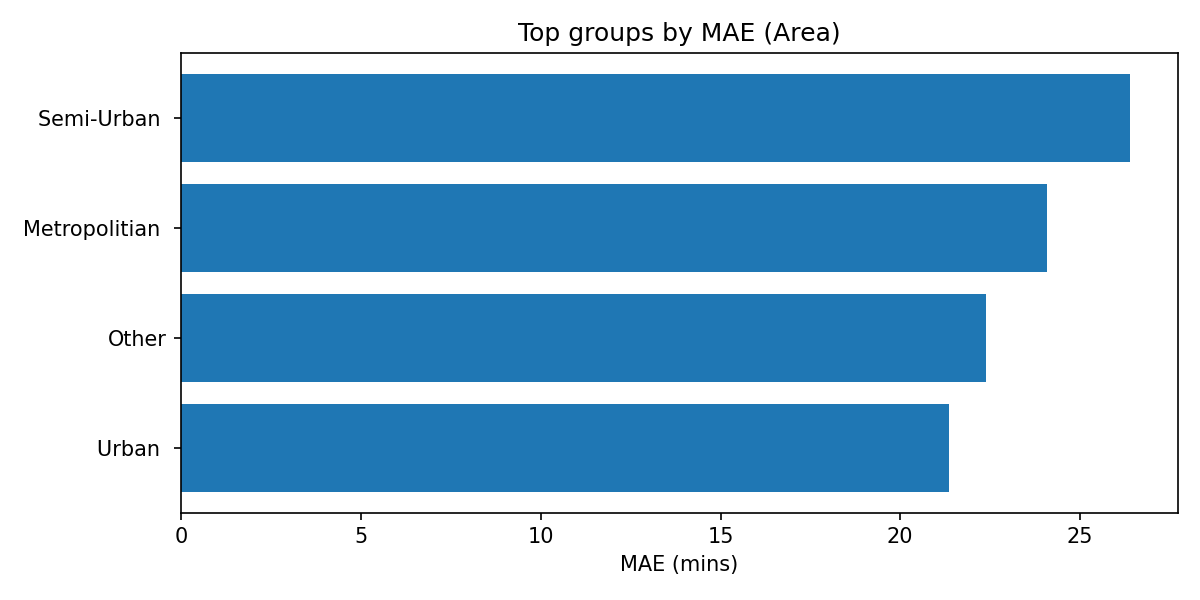

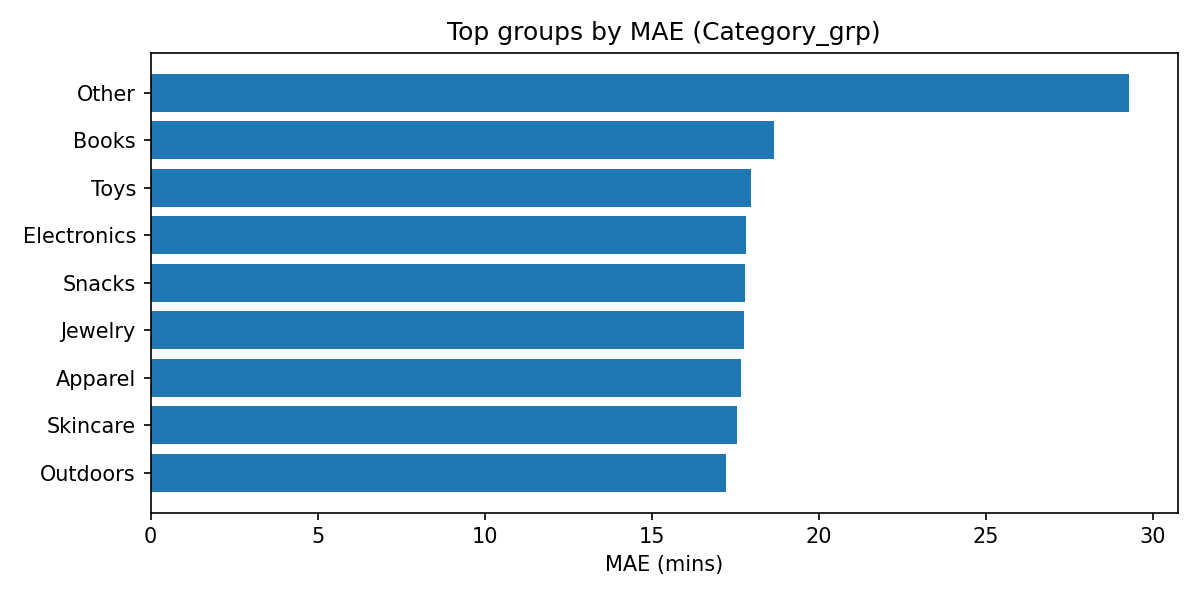

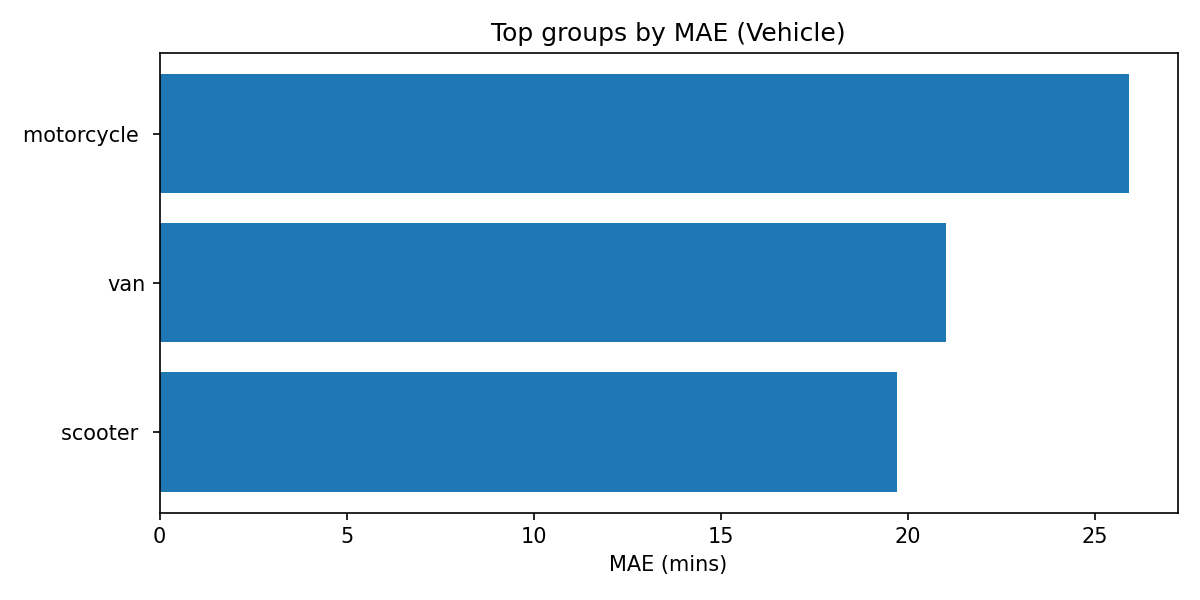

In [38]:
from pathlib import Path
import pandas as pd
from IPython.display import display, Image

OUT = Path(r"C:\Users\shail_u9zs758\analysis_outputs")

# show overall metrics file if you saved it (optional)
seg_csv = OUT / "segmented_errors.csv"
print("Segmented errors CSV:", seg_csv)
if seg_csv.exists():
    df = pd.read_csv(seg_csv)
    display(df.head(20))   # show top 20 rows

# display saved PNGs
for fname in ["segmented_errors_by_Area.png", "segmented_errors_by_Category_grp.png", "segmented_errors_by_Vehicle.png"]:
    p = OUT / fname
    if p.exists():
        display(Image(filename=str(p)))
    else:
        print("Missing image:", p)

In [58]:
from pathlib import Path
import matplotlib.pyplot as plt
import textwrap

OUT = Path(r"C:\Users\shail_u9zs758\analysis_outputs")
CSV = OUT / "segmented_errors.csv"
MD_OUT = OUT / "segmented_summary.md"
PNG_OUT = OUT / "segmented_combined.png"

if not CSV.exists():
    raise FileNotFoundError(f"{CSV} not found. Run the segmented analysis first.")

df = pd.read_csv(CSV)

# --- Top 5 worst groups overall by MAE ---
top5_overall = df.sort_values("MAE", ascending=False).head(5).reset_index(drop=True)

# --- Top 3 per group_by (Area, Category_grp, Vehicle) ---
grouped_top3 = {}
for g in df['group_by'].unique():
    top3 = df[df['group_by']==g].sort_values("MAE", ascending=False).head(3).reset_index(drop=True)
    grouped_top3[g] = top3

# --- Produce markdown text ---
md_lines = []
md_lines.append("# Segmented Error Analysis — Summary\n")
md_lines.append("**Overall test metrics** were computed earlier (see analysis_outputs). Below are the worst-performing segments by MAE.\n")

md_lines.append("## Top 5 groups (all group types) by MAE\n")
md_lines.append("| rank | group_by | group | n | MAE | RMSE | R² |")
md_lines.append("|---:|---|---|---:|---:|---:|---:|")
for i, row in top5_overall.iterrows():
    md_lines.append(f"| {i+1} | {row['group_by']} | {row['group']} | {int(row['n'])} | {row['MAE']:.3f} | {row['RMSE']:.3f} | {row['R2']:.3f} |")

md_lines.append("\n## Top 3 within each group type\n")
for g, tbl in grouped_top3.items():
    md_lines.append(f"### {g}\n")
    md_lines.append("| rank | group | n | MAE | RMSE | R² |")
    md_lines.append("|---:|---|---:|---:|---:|---:|")
    for i, row in tbl.iterrows():
        md_lines.append(f"| {i+1} | {row['group']} | {int(row['n'])} | {row['MAE']:.3f} | {row['RMSE']:.3f} | {row['R2']:.3f} |")
    md_lines.append("\n")

md_text = "\n".join(md_lines)

# Save markdown file
with open(MD_OUT, "w", encoding="utf-8") as f:
    f.write(md_text)

print("Wrote markdown summary to:", MD_OUT)
print("\n--- Markdown preview ---\n")
print(md_text)

# --- Create combined 3-panel figure ---
# Choose plot order and keep only groups that exist
panels = []
for panel in ["Area", "Category_grp", "Vehicle"]:
    if panel in df['group_by'].unique():
        sub = df[df['group_by']==panel].nlargest(10, 'MAE').sort_values('MAE')  # top 10 by MAE, ascending for hbar
        panels.append((panel, sub))
    else:
        panels.append((panel, pd.DataFrame()))

# Prepare figure
n_panels = len(panels)
fig, axes = plt.subplots(1, n_panels, figsize=(5*n_panels, 6), constrained_layout=True)

if n_panels == 1:
    axes = [axes]

for ax, (title, subdf) in zip(axes, panels):
    if subdf.empty:
        ax.text(0.5, 0.5, f"No data for {title}", ha='center', va='center', fontsize=12)
        ax.set_axis_off()
        continue
    y = subdf['group'].astype(str)
    x = subdf['MAE']
    ax.barh(y, x)
    ax.set_title(f"Top groups by MAE — {title}")
    ax.set_xlabel("MAE (minutes)")
    ax.invert_yaxis()
    # annotate values
    for i, v in enumerate(x):
        ax.text(v + 0.02*max(x), i, f"{v:.2f}", va='center', fontsize=9)

plt.suptitle("Segmented MAE — Top groups (by MAE)", fontsize=16)
plt.savefig(PNG_OUT, dpi=200)
plt.show()
print("Saved combined figure to:", PNG_OUT)

Wrote markdown summary to: C:\Users\shail_u9zs758\analysis_outputs\segmented_summary.md

--- Markdown preview ---

# Segmented Error Analysis — Summary

**Overall test metrics** were computed earlier (see analysis_outputs). Below are the worst-performing segments by MAE.

## Top 5 groups (all group types) by MAE

| rank | group_by | group | n | MAE | RMSE | R² |
|---:|---|---|---:|---:|---:|---:|
| 1 | Category_grp | Other | 4294 | 29.275 | 41.770 | 0.429 |
| 2 | Area | Semi-Urban  | 21 | 26.395 | 33.341 | -5.485 |
| 3 | Vehicle | motorcycle  | 5097 | 25.919 | 36.306 | 0.534 |
| 4 | Area | Metropolitian  | 6552 | 24.089 | 34.437 | 0.545 |
| 5 | Area | Other | 230 | 22.393 | 30.634 | 0.613 |

## Top 3 within each group type

### Area

| rank | group | n | MAE | RMSE | R² |
|---:|---|---:|---:|---:|---:|
| 1 | Semi-Urban  | 21 | 26.395 | 33.341 | -5.485 |
| 2 | Metropolitian  | 6552 | 24.089 | 34.437 | 0.545 |
| 3 | Other | 230 | 22.393 | 30.634 | 0.613 |


### Category_grp

| rank | gro

C:\Users\shail_u9zs758\AppData\Local\Temp\ipykernel_22756\2018728988.py:88: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


![Segmented MAE](analysis_outputs/segmented_combined.png)

In [41]:
# Robust agent-history / fallback + small retrain
import os, json, joblib, warnings, math, time
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterSampler, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor

ROOT = Path.cwd()
print("Working dir:", ROOT)

# Filenames
INPUT_CSV = ROOT / "amazon_delivery_cleaned.csv"
OUT_CSV = ROOT / "amazon_delivery_with_history.csv"
MODEL_OUT = ROOT / "lgbm_history_tuned.joblib"
METRICS_OUT = ROOT / "history_training_metrics.json"
MLFLOW_EXPERIMENT = "agent_history_modeling"

# detection lists
AGENT_ID_CANDIDATES = ["Agent_ID","AgentId","agent_id","AgentId","Agent","AgentID","driver_id","Driver_ID","delivery_agent"]
TS_CANDIDATES = ["Order_Time","order_time","order_timestamp","order_datetime","OrderDate","Order_DateTime","Timestamp","created_at"]
TARGET_CANDIDATES = ["Delivery_Time","delivery_time","DeliveryTime","deliveryTime","target"]

NUMERIC_FEATURES = ['distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed','hour_sin','hour_cos']
CATEGORICAL_FEATURES = ['Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day','distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic']

N_ITER = 12
CV_FOLDS = 3
RANDOM_STATE = 42

# load data
if not INPUT_CSV.exists():
    raise FileNotFoundError(f"Input CSV not found: {INPUT_CSV}")

df = pd.read_csv(INPUT_CSV)
print("Loaded data shape:", df.shape)

# detect agent, timestamp, target
agent_col = next((c for c in AGENT_ID_CANDIDATES if c in df.columns), None)
ts_col = next((c for c in TS_CANDIDATES if c in df.columns), None)
target_col = next((c for c in TARGET_CANDIDATES if c in df.columns), None)

# heuristic search if direct names not found: look for column names containing keywords
if agent_col is None:
    # look for any column name containing 'agent'/'driver'/'emp'/'deliver'
    candidates = [c for c in df.columns if any(k in c.lower() for k in ['agent','driver','emp','deliver','courier'])]
    # filter by uniqueness heuristic: not too many unique values (not a timestamp), not too few
    found = None
    for c in candidates:
        nunique = df[c].nunique(dropna=True)
        if 2 <= nunique <= max(10000, int(len(df)/2)):
            found = c
            break
    if found:
        agent_col = found

print("Detected columns -> agent:", agent_col, "| timestamp:", ts_col, "| target:", target_col)
if target_col is None:
    raise ValueError("Target column not found. Expected one of: " + ", ".join(TARGET_CANDIDATES))

# ensure timestamp parsed if present
if ts_col is not None:
    try:
        df[ts_col] = pd.to_datetime(df[ts_col])
    except Exception:
        print("Warning: could not parse timestamp to datetime, will still attempt fallback methods.")
        # keep ts_col but may not use time-window features

# Branch A: agent column found -> compute agent-history (7d / 30d)
if agent_col is not None:
    print("Agent column found:", agent_col, "→ computing per-agent time-window history (7D/30D) if timestamp exists, otherwise index-based rolling.")
    df_work = df.copy()
    # if timestamp usable, do time-window per agent
    use_time_window = (ts_col is not None) and pd.api.types.is_datetime64_any_dtype(df_work[ts_col])
    if use_time_window:
        df_work = df_work.sort_values([agent_col, ts_col]).reset_index(drop=True)
        def compute_time_windows(g):
            g = g.copy().set_index(ts_col)
            g['agent_7d_count'] = g[target_col].rolling('7D', closed='left').count().astype(float)
            g['agent_7d_mean'] = g[target_col].rolling('7D', closed='left').mean()
            g['agent_30d_count'] = g[target_col].rolling('30D', closed='left').count().astype(float)
            g['agent_30d_mean'] = g[target_col].rolling('30D', closed='left').mean()
            return g.reset_index()
        df_hist = df_work.groupby(agent_col, group_keys=False).apply(compute_time_windows)
        for col in ['agent_7d_count','agent_7d_mean','agent_30d_count','agent_30d_mean']:
            df_work[col] = df_hist[col].values
        method_used = "agent_time_window"
    else:
        # index-based (last 7 / last 30 orders per agent)
        df_work = df_work.sort_values([agent_col]).reset_index(drop=True)
        def compute_index_rolling(g):
            g = g.copy()
            g['agent_7d_count'] = g[target_col].shift(1).rolling(window=7, min_periods=0).count().astype(float)
            g['agent_7d_mean'] = g[target_col].shift(1).rolling(window=7, min_periods=0).mean()
            g['agent_30d_count'] = g[target_col].shift(1).rolling(window=30, min_periods=0).count().astype(float)
            g['agent_30d_mean'] = g[target_col].shift(1).rolling(window=30, min_periods=0).mean()
            return g
        df_work = df_work.groupby(agent_col, group_keys=False).apply(compute_index_rolling).reset_index(drop=True)
        method_used = "agent_index_rolling"

    added_cols = ['agent_7d_count','agent_7d_mean','agent_30d_count','agent_30d_mean']
    print("Added columns:", added_cols)
    # impute safely
    global_mean = df_work[target_col].median() if df_work[target_col].notna().any() else 0.0
    df_work['agent_7d_count'] = df_work['agent_7d_count'].fillna(0.0)
    df_work['agent_30d_count'] = df_work['agent_30d_count'].fillna(0.0)
    df_work['agent_7d_mean'] = df_work['agent_7d_mean'].fillna(global_mean)
    df_work['agent_30d_mean'] = df_work['agent_30d_mean'].fillna(global_mean)

else:
    # Branch B fallback: no agent id — compute global & area-level recent stats
    print("No agent id found — computing dataset-level and Area-level recent stats as fallback.")
    df_work = df.copy()
    if ts_col is not None and pd.api.types.is_datetime64_any_dtype(df_work[ts_col]):
        df_work = df_work.sort_values(ts_col).reset_index(drop=True)
        # global rolling: use time-window rolling on entire dataset
        df_work = df_work.set_index(ts_col)
        df_work['global_7d_count'] = df_work[target_col].rolling('7D', closed='left').count().astype(float)
        df_work['global_7d_mean'] = df_work[target_col].rolling('7D', closed='left').mean()
        df_work['global_30d_count'] = df_work[target_col].rolling('30D', closed='left').count().astype(float)
        df_work['global_30d_mean'] = df_work[target_col].rolling('30D', closed='left').mean()
        df_work = df_work.reset_index()
        method_used = "global_time_window"
    else:
        # order-index based global rolling
        df_work = df_work.reset_index(drop=True)
        df_work['global_7d_count'] = df_work[target_col].shift(1).rolling(window=7, min_periods=0).count().astype(float)
        df_work['global_7d_mean'] = df_work[target_col].shift(1).rolling(window=7, min_periods=0).mean()
        df_work['global_30d_count'] = df_work[target_col].shift(1).rolling(window=30, min_periods=0).count().astype(float)
        df_work['global_30d_mean'] = df_work[target_col].shift(1).rolling(window=30, min_periods=0).mean()
        method_used = "global_index_rolling"

    # area-level recent means if Area exists
    if 'Area' in df_work.columns:
        use_area = True
        if ts_col is not None and pd.api.types.is_datetime64_any_dtype(df_work[ts_col]):
            # compute area time-windowed means
            df_area = df_work.set_index(ts_col).groupby('Area', group_keys=False)[target_col].rolling('7D', closed='left').mean().reset_index()
            # df_area contains repeated timestamp & group; easier: compute per-area expanding with shift as fallback
            # Simpler robust approach: compute last-7 / last-30 mean per area using index-based rolling after sorting by ts
            df_work = df_work.sort_values(['Area', ts_col]).reset_index(drop=True)
            df_work['area_7d_mean'] = df_work.groupby('Area')[target_col].shift(1).rolling(window=7, min_periods=0).mean().reset_index(drop=True)
            df_work['area_30d_mean'] = df_work.groupby('Area')[target_col].shift(1).rolling(window=30, min_periods=0).mean().reset_index(drop=True)
        else:
            df_work = df_work.sort_values(['Area']).reset_index(drop=True)
            df_work['area_7d_mean'] = df_work.groupby('Area')[target_col].shift(1).rolling(window=7, min_periods=0).mean().reset_index(drop=True)
            df_work['area_30d_mean'] = df_work.groupby('Area')[target_col].shift(1).rolling(window=30, min_periods=0).mean().reset_index(drop=True)
    else:
        use_area = False

    # impute safe
    global_mean = df_work[target_col].median() if df_work[target_col].notna().any() else 0.0
    for col in ['global_7d_count','global_30d_count']:
        df_work[col] = df_work[col].fillna(0.0)
    for col in ['global_7d_mean','global_30d_mean','area_7d_mean','area_30d_mean']:
        if col in df_work.columns:
            df_work[col] = df_work[col].fillna(global_mean)

    if use_area:
        added_cols = ['global_7d_count','global_7d_mean','global_30d_count','global_30d_mean','area_7d_mean','area_30d_mean']
    else:
        added_cols = ['global_7d_count','global_7d_mean','global_30d_count','global_30d_mean']

    print("Added fallback columns:", added_cols)

# save enriched CSV
df_work.to_csv(OUT_CSV, index=False)
print("Saved enriched dataset to:", OUT_CSV)

# Build features list for modeling: keep earlier numeric + categorical, plus new numeric history cols
new_numeric_cols = [c for c in ['agent_7d_count','agent_7d_mean','agent_30d_count','agent_30d_mean','global_7d_count','global_7d_mean','global_30d_count','global_30d_mean','area_7d_mean','area_30d_mean'] if c in df_work.columns]
model_numeric = [c for c in NUMERIC_FEATURES if c in df_work.columns] + new_numeric_cols
model_categorical = [c for c in CATEGORICAL_FEATURES if c in df_work.columns]
features = model_numeric + model_categorical
print("Model numeric features:", model_numeric)
print("Model categorical features:", model_categorical)

# Drop rows with missing target, split train/test
df_work = df_work.dropna(subset=[target_col]).reset_index(drop=True)
strat_col = 'Category_grp' if 'Category_grp' in df_work.columns else None
train_df, test_df = train_test_split(df_work, test_size=0.20, random_state=RANDOM_STATE, stratify=df_work[strat_col] if strat_col is not None else None)
X_train = train_df[features].copy()
y_train = train_df[target_col].copy()
X_test = test_df[features].copy()
y_test = test_df[target_col].copy()

# cast categorical dtypes
for c in model_categorical:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

# Small randomized tuning (same as before)
param_grid = {
    "num_leaves": [31, 42, 64, 80],
    "max_depth": [6, 9, 12],
    "learning_rate": [0.01, 0.02, 0.05],
    "n_estimators": [200, 300, 400],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "reg_alpha": [0.0, 0.1, 0.2],
    "reg_lambda": [0.0, 0.1, 0.2],
    "min_child_samples": [5, 10, 20],
}
from sklearn.model_selection import ParameterSampler
sampler = list(ParameterSampler(param_grid, n_iter=N_ITER, random_state=RANDOM_STATE))

best_score = math.inf
best_params = None
for i, params in enumerate(sampler, 1):
    print(f"Trial {i}/{len(sampler)}")
    model = LGBMRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)
    try:
        scores = cross_val_score(model, X_train, y_train, cv=CV_FOLDS, scoring="neg_mean_squared_error", n_jobs=1)
        mean_mse = -scores.mean()
        rmse = float(np.sqrt(mean_mse))
        print(f"  CV RMSE: {rmse:.4f}")
        if rmse < best_score:
            best_score = rmse
            best_params = params
    except Exception as e:
        print("  Trial failed:", e)
        continue

if best_params is None:
    best_params = {"num_leaves":31, "learning_rate":0.02, "n_estimators":300, "max_depth":9, "subsample":0.7, "colsample_bytree":0.7, "min_child_samples":10}
print("Best CV RMSE (train):", best_score, "params:", best_params)

# retrain final model
final_model = LGBMRegressor(**best_params, random_state=RANDOM_STATE, n_jobs=-1)
final_model.fit(X_train, y_train, categorical_feature=model_categorical)

y_pred = final_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

metrics = {
    "detection_agent_col": agent_col if agent_col is not None else None,
    "method_used": method_used,
    "best_cv_rmse_train": float(best_score) if best_score != math.inf else None,
    "best_params": best_params,
    "test_MAE": float(mae),
    "test_RMSE": float(rmse),
    "test_R2": float(r2),
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0]),
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
}

joblib.dump(final_model, MODEL_OUT)
with open(METRICS_OUT, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

print("Saved model to:", MODEL_OUT)
print("Saved metrics to:", METRICS_OUT)

# attempt MLflow log (graceful)
try:
    import mlflow
    mlflow.set_tracking_uri(f"file://{ROOT / 'mlruns'}")
    mlflow.set_experiment(MLFLOW_EXPERIMENT)
    with mlflow.start_run(run_name="lgbm_history_tuned_auto"):
        mlflow.log_params({k:str(v) for k,v in best_params.items()})
        mlflow.log_metric("test_MAE", metrics["test_MAE"])
        mlflow.log_metric("test_RMSE", metrics["test_RMSE"])
        mlflow.log_metric("test_R2", metrics["test_R2"])
        mlflow.log_artifact(str(OUT_CSV), artifact_path="data")
        mlflow.log_artifact(str(MODEL_OUT), artifact_path="model")
        mlflow.log_artifact(str(METRICS_OUT), artifact_path="metrics")
    print("Logged to MLflow experiment:", MLFLOW_EXPERIMENT)
except Exception as e:
    print("MLflow logging skipped/failed:", e)

print("=== Done. Method used:", method_used, "Agent column detected:", agent_col, "=== ")

Working dir: C:\Users\shail_u9zs758
Loaded data shape: (43739, 35)
Detected columns -> agent: Agent_Age | timestamp: Order_Time | target: Delivery_Time
Agent column found: Agent_Age → computing per-agent time-window history (7D/30D) if timestamp exists, otherwise index-based rolling.


C:\Users\shail_u9zs758\AppData\Local\Temp\ipykernel_22756\3223744076.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[ts_col] = pd.to_datetime(df[ts_col])
C:\Users\shail_u9zs758\AppData\Local\Temp\ipykernel_22756\3223744076.py:99: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_work = df_work.groupby(agent_col, group_keys=False).apply(compute_index_rolling).reset_index(drop=True)


Added columns: ['agent_7d_count', 'agent_7d_mean', 'agent_30d_count', 'agent_30d_mean']
Saved enriched dataset to: C:\Users\shail_u9zs758\amazon_delivery_with_history.csv
Model numeric features: ['distance_km', 'order_to_pickup_mins', 'Agent_Age', 'Agent_Rating_imputed', 'hour_sin', 'hour_cos', 'agent_7d_count', 'agent_7d_mean', 'agent_30d_count', 'agent_30d_mean']
Model categorical features: ['Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp', 'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic']
Trial 1/12
  CV RMSE: 34.1551
Trial 2/12
  CV RMSE: 34.2750
Trial 3/12
  CV RMSE: 34.8366
Trial 4/12
  CV RMSE: 34.5247
Trial 5/12
  CV RMSE: 34.2308
Trial 6/12
  CV RMSE: 34.2018
Trial 7/12
  CV RMSE: 34.2435
Trial 8/12
  CV RMSE: 34.9525
Trial 9/12
  CV RMSE: 34.5886
Trial 10/12
  CV RMSE: 34.2544
Trial 11/12
  CV RMSE: 34.2334
Trial 12/12
  CV RMSE: 34.1898
Best CV RMSE (train): 34.15514807407543 params: {'subsample': 1.0, 'reg_lambda': 0.0, 'reg

In [42]:
# Robust re-run: safer agent-id detection (avoids picking Agent_Age) + feature creation + small retrain
import os, json, joblib, warnings, math, time
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterSampler, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor

ROOT = Path.cwd()
print("Working dir:", ROOT)

INPUT_CSV = ROOT / "amazon_delivery_cleaned.csv"
OUT_CSV = ROOT / "amazon_delivery_with_history.csv"
MODEL_OUT = ROOT / "lgbm_history_tuned.joblib"
METRICS_OUT = ROOT / "history_training_metrics.json"
MLFLOW_EXPERIMENT = "agent_history_modeling"

# detection lists (kept as before)
AGENT_ID_CANDIDATES = ["Agent_ID","AgentId","agent_id","Agent","AgentID","driver_id","Driver_ID","delivery_agent","courier_id","agent"]
TS_CANDIDATES = ["Order_Time","order_time","order_timestamp","order_datetime","OrderDate","Order_DateTime","Timestamp","created_at"]
TARGET_CANDIDATES = ["Delivery_Time","delivery_time","DeliveryTime","deliveryTime","target"]

NUMERIC_FEATURES = ['distance_km','order_to_pickup_mins','Agent_Age','Agent_Rating_imputed','hour_sin','hour_cos']
CATEGORICAL_FEATURES = ['Weather_imputed','Traffic','Vehicle','Area','Category_grp','part_of_day','distance_bucket','Traffic_Weather','Area_PartOfDay','CatTraffic']

N_ITER = 12
CV_FOLDS = 3
RANDOM_STATE = 42

# Safety exclusion tokens to avoid picking numeric columns like Agent_Age
EXCLUDE_AGENT_TOKENS = ['age','rating','score','time','min','max','distance','km']

# load data
if not INPUT_CSV.exists():
    raise FileNotFoundError(f"Input CSV not found: {INPUT_CSV}")
df = pd.read_csv(INPUT_CSV)
print("Loaded data shape:", df.shape)

# detect agent & timestamp & target
agent_col = next((c for c in AGENT_ID_CANDIDATES if c in df.columns), None)
ts_col = next((c for c in TS_CANDIDATES if c in df.columns), None)
target_col = next((c for c in TARGET_CANDIDATES if c in df.columns), None)

# fallback heuristic: search for columns containing 'agent'/'driver'/'id' but avoid columns with EXCLUDE tokens
if agent_col is None:
    candidates = [c for c in df.columns if any(k in c.lower() for k in ['agent','driver','courier','deliver','id'])]
    # filter out columns with exclude tokens (like 'age' or 'rating')
    candidates = [c for c in candidates if not any(tok in c.lower() for tok in EXCLUDE_AGENT_TOKENS)]
    # sort candidates by cardinality heuristic: prefer moderate-high cardinality (not very small unique set)
    scored = []
    for c in candidates:
        nunique = df[c].nunique(dropna=True)
        scored.append((c, nunique))
    scored = sorted(scored, key=lambda x: x[1], reverse=True)
    if scored:
        # choose top candidate only if cardinality > min threshold (e.g., > 30)
        cand, nunique = scored[0]
        if nunique >= 30:
            agent_col = cand

# Additional fallback: if still None, try to find any column with high cardinality and name including 'id'
if agent_col is None:
    for c in df.columns:
        if 'id' in c.lower() and df[c].nunique(dropna=True) > 30 and not any(tok in c.lower() for tok in EXCLUDE_AGENT_TOKENS):
            agent_col = c
            break

# Final safety: do not accept numeric columns that look like age/rating even if they match earlier heuristics
if agent_col is not None and any(tok in agent_col.lower() for tok in EXCLUDE_AGENT_TOKENS):
    print("Detected candidate agent column", agent_col, "but it includes exclude tokens; ignoring it.")
    agent_col = None

print("Final detected columns -> agent:", agent_col, "| timestamp:", ts_col, "| target:", target_col)
if target_col is None:
    raise ValueError("Target column not found. Expected one of: " + ", ".join(TARGET_CANDIDATES))

# parse timestamp if present
if ts_col is not None:
    try:
        df[ts_col] = pd.to_datetime(df[ts_col])
    except Exception:
        print("Warning: could not parse timestamp reliably.")

# Branch A: agent column found
if agent_col is not None:
    print("Using agent column:", agent_col)
    df_work = df.copy()
    # prefer time-window if timestamp is usable
    use_time_window = (ts_col is not None) and pd.api.types.is_datetime64_any_dtype(df_work[ts_col])
    if use_time_window:
        df_work = df_work.sort_values([agent_col, ts_col]).reset_index(drop=True)
        def compute_time_windows(g):
            g = g.copy().set_index(ts_col)
            g['agent_7d_count'] = g[target_col].rolling('7D', closed='left').count().astype(float)
            g['agent_7d_mean'] = g[target_col].rolling('7D', closed='left').mean()
            g['agent_30d_count'] = g[target_col].rolling('30D', closed='left').count().astype(float)
            g['agent_30d_mean'] = g[target_col].rolling('30D', closed='left').mean()
            return g.reset_index()
        df_hist = df_work.groupby(agent_col, group_keys=False).apply(compute_time_windows)
        for col in ['agent_7d_count','agent_7d_mean','agent_30d_count','agent_30d_mean']:
            df_work[col] = df_hist[col].values
        method_used = "agent_time_window"
    else:
        df_work = df_work.sort_values([agent_col]).reset_index(drop=True)
        def compute_index_rolling(g):
            g = g.copy()
            g['agent_7d_count'] = g[target_col].shift(1).rolling(window=7, min_periods=0).count().astype(float)
            g['agent_7d_mean'] = g[target_col].shift(1).rolling(window=7, min_periods=0).mean()
            g['agent_30d_count'] = g[target_col].shift(1).rolling(window=30, min_periods=0).count().astype(float)
            g['agent_30d_mean'] = g[target_col].shift(1).rolling(window=30, min_periods=0).mean()
            return g
        df_work = df_work.groupby(agent_col, group_keys=False).apply(compute_index_rolling).reset_index(drop=True)
        method_used = "agent_index_rolling"
    added_cols = ['agent_7d_count','agent_7d_mean','agent_30d_count','agent_30d_mean']
    print("Added columns:", added_cols)
    # impute
    global_mean = df_work[target_col].median() if df_work[target_col].notna().any() else 0.0
    df_work['agent_7d_count'] = df_work['agent_7d_count'].fillna(0.0)
    df_work['agent_30d_count'] = df_work['agent_30d_count'].fillna(0.0)
    df_work['agent_7d_mean'] = df_work['agent_7d_mean'].fillna(global_mean)
    df_work['agent_30d_mean'] = df_work['agent_30d_mean'].fillna(global_mean)

else:
    # Branch B fallback (global & area-level features)
    print("No valid agent id found. Falling back to global/area recent stats.")
    df_work = df.copy()
    if ts_col is not None and pd.api.types.is_datetime64_any_dtype(df_work[ts_col]):
        df_work = df_work.sort_values(ts_col).reset_index(drop=True)
        df_work = df_work.set_index(ts_col)
        df_work['global_7d_count'] = df_work[target_col].rolling('7D', closed='left').count().astype(float)
        df_work['global_7d_mean'] = df_work[target_col].rolling('7D', closed='left').mean()
        df_work['global_30d_count'] = df_work[target_col].rolling('30D', closed='left').count().astype(float)
        df_work['global_30d_mean'] = df_work[target_col].rolling('30D', closed='left').mean()
        df_work = df_work.reset_index()
        method_used = "global_time_window"
    else:
        df_work = df_work.reset_index(drop=True)
        df_work['global_7d_count'] = df_work[target_col].shift(1).rolling(window=7, min_periods=0).count().astype(float)
        df_work['global_7d_mean'] = df_work[target_col].shift(1).rolling(window=7, min_periods=0).mean()
        df_work['global_30d_count'] = df_work[target_col].shift(1).rolling(window=30, min_periods=0).count().astype(float)
        df_work['global_30d_mean'] = df_work[target_col].shift(1).rolling(window=30, min_periods=0).mean()
        method_used = "global_index_rolling"

    if 'Area' in df_work.columns:
        df_work = df_work.sort_values(['Area', ts_col if ts_col is not None else df_work.index.name if df_work.index.name else df_work.columns[0]]).reset_index(drop=True)
        df_work['area_7d_mean'] = df_work.groupby('Area')[target_col].shift(1).rolling(window=7, min_periods=0).mean().reset_index(drop=True)
        df_work['area_30d_mean'] = df_work.groupby('Area')[target_col].shift(1).rolling(window=30, min_periods=0).mean().reset_index(drop=True)
        added_cols = ['global_7d_count','global_7d_mean','global_30d_count','global_30d_mean','area_7d_mean','area_30d_mean']
    else:
        added_cols = ['global_7d_count','global_7d_mean','global_30d_count','global_30d_mean']

    global_mean = df_work[target_col].median() if df_work[target_col].notna().any() else 0.0
    for col in added_cols:
        if col in ['global_7d_count','global_30d_count']:
            df_work[col] = df_work[col].fillna(0.0)
        else:
            df_work[col] = df_work[col].fillna(global_mean)

print("Saved enriched dataset to:", OUT_CSV)
df_work.to_csv(OUT_CSV, index=False)

# Prepare features for model
new_numeric_cols = [c for c in ['agent_7d_count','agent_7d_mean','agent_30d_count','agent_30d_mean','global_7d_count','global_7d_mean','global_30d_count','global_30d_mean','area_7d_mean','area_30d_mean'] if c in df_work.columns]
model_numeric = [c for c in NUMERIC_FEATURES if c in df_work.columns] + new_numeric_cols
model_categorical = [c for c in CATEGORICAL_FEATURES if c in df_work.columns]
features = model_numeric + model_categorical

df_work = df_work.dropna(subset=[target_col]).reset_index(drop=True)
strat_col = 'Category_grp' if 'Category_grp' in df_work.columns else None
train_df, test_df = train_test_split(df_work, test_size=0.20, random_state=RANDOM_STATE, stratify=df_work[strat_col] if strat_col is not None else None)
X_train = train_df[features].copy(); y_train = train_df[target_col].copy()
X_test = test_df[features].copy(); y_test = test_df[target_col].copy()

for c in model_categorical:
    X_train[c] = X_train[c].astype('category'); X_test[c] = X_test[c].astype('category')

# Tiny randomized search (n_iter=N_ITER)
param_grid = {
    "num_leaves": [31, 42, 64, 80],
    "max_depth": [6, 9, 12],
    "learning_rate": [0.01, 0.02, 0.05],
    "n_estimators": [200, 300, 400],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "reg_alpha": [0.0, 0.1, 0.2],
    "reg_lambda": [0.0, 0.1, 0.2],
    "min_child_samples": [5, 10, 20],
}
from sklearn.model_selection import ParameterSampler
sampler = list(ParameterSampler(param_grid, n_iter=N_ITER, random_state=RANDOM_STATE))

best_score = math.inf; best_params = None
for i, params in enumerate(sampler, 1):
    print(f"Trial {i}/{len(sampler)}")
    model = LGBMRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)
    try:
        scores = cross_val_score(model, X_train, y_train, cv=CV_FOLDS, scoring="neg_mean_squared_error", n_jobs=1)
        mean_mse = -scores.mean(); rmse = float(np.sqrt(mean_mse))
        print(f"  CV RMSE: {rmse:.4f}")
        if rmse < best_score:
            best_score = rmse; best_params = params
    except Exception as e:
        print("  Trial failed:", e)
        continue

if best_params is None:
    best_params = {"num_leaves":31, "learning_rate":0.02, "n_estimators":300, "max_depth":9, "subsample":0.7, "colsample_bytree":0.7, "min_child_samples":10}

print("Best CV RMSE (train):", best_score, "params:", best_params)

final_model = LGBMRegressor(**best_params, random_state=RANDOM_STATE, n_jobs=-1)
final_model.fit(X_train, y_train, categorical_feature=model_categorical)

y_pred = final_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

metrics = {
    "agent_col_detected": agent_col,
    "method_used": method_used,
    "best_cv_rmse_train": float(best_score) if best_score != math.inf else None,
    "best_params": best_params,
    "test_MAE": float(mae),
    "test_RMSE": float(rmse),
    "test_R2": float(r2),
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0]),
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
}

joblib.dump(final_model, MODEL_OUT)
with open(METRICS_OUT, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

print("Saved model to:", MODEL_OUT)
print("Saved metrics to:", METRICS_OUT)

try:
    import mlflow
    mlflow.set_tracking_uri(f"file://{ROOT / 'mlruns'}")
    mlflow.set_experiment(MLFLOW_EXPERIMENT)
    with mlflow.start_run(run_name="lgbm_history_tuned_safe"):
        mlflow.log_params({k:str(v) for k,v in best_params.items()})
        mlflow.log_metric("test_MAE", metrics["test_MAE"])
        mlflow.log_metric("test_RMSE", metrics["test_RMSE"])
        mlflow.log_metric("test_R2", metrics["test_R2"])
        mlflow.log_artifact(str(OUT_CSV), artifact_path="data")
        mlflow.log_artifact(str(MODEL_OUT), artifact_path="model")
        mlflow.log_artifact(str(METRICS_OUT), artifact_path="metrics")
    print("Logged to MLflow experiment:", MLFLOW_EXPERIMENT)
except Exception as e:
    print("MLflow logging skipped/failed:", e)

print("=== Done. Method used:", method_used, "Agent column detected:", agent_col, "=== ")

Working dir: C:\Users\shail_u9zs758
Loaded data shape: (43739, 35)
Final detected columns -> agent: Order_ID | timestamp: Order_Time | target: Delivery_Time
Using agent column: Order_ID


C:\Users\shail_u9zs758\AppData\Local\Temp\ipykernel_22756\2542800978.py:81: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[ts_col] = pd.to_datetime(df[ts_col])
C:\Users\shail_u9zs758\AppData\Local\Temp\ipykernel_22756\2542800978.py:113: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_work = df_work.groupby(agent_col, group_keys=False).apply(compute_index_rolling).reset_index(drop=True)


Added columns: ['agent_7d_count', 'agent_7d_mean', 'agent_30d_count', 'agent_30d_mean']
Saved enriched dataset to: C:\Users\shail_u9zs758\amazon_delivery_with_history.csv
Trial 1/12
  CV RMSE: 34.0993
Trial 2/12
  CV RMSE: 34.1893
Trial 3/12
  CV RMSE: 34.7378
Trial 4/12
  CV RMSE: 34.5306
Trial 5/12
  CV RMSE: 34.1567
Trial 6/12
  CV RMSE: 34.1326
Trial 7/12
  CV RMSE: 34.1724
Trial 8/12
  CV RMSE: 34.8923
Trial 9/12
  CV RMSE: 34.5541
Trial 10/12
  CV RMSE: 34.2355
Trial 11/12
  CV RMSE: 34.1643
Trial 12/12
  CV RMSE: 34.1300
Best CV RMSE (train): 34.099338685955544 params: {'subsample': 1.0, 'reg_lambda': 0.0, 'reg_alpha': 0.2, 'num_leaves': 64, 'n_estimators': 300, 'min_child_samples': 5, 'max_depth': 6, 'learning_rate': 0.02, 'colsample_bytree': 0.7}
Saved model to: C:\Users\shail_u9zs758\lgbm_history_tuned.joblib
Saved metrics to: C:\Users\shail_u9zs758\history_training_metrics.json
MLflow logging skipped/failed: file://C:\Users\shail_u9zs758\mlruns is not a valid remote uri. For

In [43]:
# 1) Verify MLflow tracking URI and list experiments & recent runs
from pathlib import Path
from mlflow.tracking import MlflowClient
import mlflow

ROOT = Path(r"C:\Users\shail_u9zs758").resolve()
mlruns_dir = (ROOT / "mlruns").resolve()

print("Local mlruns dir (filesystem):", mlruns_dir)
print("URI to use with mlflow:", mlruns_dir.as_uri())

# Point mlflow client to that folder (safe, uses file:/// form)
tracking_uri = mlruns_dir.as_uri()
mlflow.set_tracking_uri(tracking_uri)
print("mlflow.get_tracking_uri() ->", mlflow.get_tracking_uri())

client = MlflowClient(tracking_uri)
exps = client.list_experiments()
print("Found experiments:", [e.name for e in exps])

# Show the last 5 runs from the 'agent_history_modeling' experiment if it exists
exp = client.get_experiment_by_name("agent_history_modeling")
if exp:
    print("Experiment id:", exp.experiment_id, "name:", exp.name)
    runs = client.search_runs(exp.experiment_id, order_by=["attributes.start_time DESC"], max_results=10)
    print("Recent runs (up to 10):")
    for r in runs:
        print("-", r.info.run_id, "| status:", r.info.status, "| metrics:", r.data.metrics)
else:
    print("Experiment 'agent_history_modeling' not found in this mlruns folder.")

Local mlruns dir (filesystem): C:\Users\shail_u9zs758\mlruns
URI to use with mlflow: file:///C:/Users/shail_u9zs758/mlruns
mlflow.get_tracking_uri() -> file:///C:/Users/shail_u9zs758/mlruns


AttributeError: 'MlflowClient' object has no attribute 'list_experiments'

In [44]:
# 2) Re-log local artifacts as a new MLflow run (if UI doesn't show previous run)
from pathlib import Path
import json, mlflow

ROOT = Path(r"C:\Users\shail_u9zs758").resolve()
mlruns_dir = (ROOT / "mlruns").resolve()
mlflow.set_tracking_uri(mlruns_dir.as_uri())
mlflow.set_experiment("agent_history_modeling")

model_file = ROOT / "lgbm_history_tuned.joblib"
metrics_file = ROOT / "history_training_metrics.json"
data_file = ROOT / "amazon_delivery_with_history.csv"

metrics = {}
if metrics_file.exists():
    metrics = json.loads(metrics_file.read_text(encoding="utf-8"))
else:
    print("Warning: metrics file not found:", metrics_file)

with mlflow.start_run(run_name="relog_history_artifacts"):
    # log params if present in metrics
    best_params = metrics.get("best_params", {})
    if best_params:
        mlflow.log_params({k: str(v) for k,v in best_params.items()})
    # log numeric metrics
    for k in ("test_MAE","test_RMSE","test_R2","best_cv_rmse_train"):
        if k in metrics:
            mlflow.log_metric(k, float(metrics[k]))
    # log artifacts (if present)
    if data_file.exists():
        mlflow.log_artifact(str(data_file), artifact_path="data")
    if model_file.exists():
        mlflow.log_artifact(str(model_file), artifact_path="model")
    if metrics_file.exists():
        mlflow.log_artifact(str(metrics_file), artifact_path="metrics")
    print("Logged run id:", mlflow.active_run().info.run_id)
    print("Artifact URI for this run:", mlflow.get_artifact_uri())

2025/09/28 21:50:05 INFO mlflow.tracking.fluent: Experiment with name 'agent_history_modeling' does not exist. Creating a new experiment.


Logged run id: 71ba002302a8413e8aac8c7c2f44d1e5
Artifact URI for this run: file:///C:/Users/shail_u9zs758/mlruns/181570534030750579/71ba002302a8413e8aac8c7c2f44d1e5/artifacts


In [45]:
#We are relogged into the Mlflow

In [46]:
# ===== Aggregate saved model metrics into a comparison table + markdown =====
from pathlib import Path
import json
import pandas as pd
import numpy as np
from datetime import datetime

ROOT = Path(r"C:\Users\shail_u9zs758")
OUT = ROOT / "comparison_outputs"
OUT.mkdir(exist_ok=True)

# Candidate metric files we used in the project
candidates = {
    "baseline_linear": ROOT / "linear_model_metrics.json",
    "baseline_mlflow_summary": ROOT / "mlflow_models_summary.json",
    "post_feature_engineering": ROOT / "mlflow_postfe_summary.json",
    "tree_models": ROOT / "tree_models_summary.json",
    "lgbm_tuning": ROOT / "lgbm_tuning_summary.json",
    "lgbm_tuned_metrics": ROOT / "lgbm_tuning_summary.json",   # sometimes same
    "optuna_native": ROOT / "optuna_native_outputs" / "optuna_summary.json",  # optional
    "optuna_metrics_file": ROOT / "optuna_native_outputs" / "optuna_summary.json",
    "history_model": ROOT / "history_training_metrics.json",
    "lgbm_native": ROOT / "lgbm_native_cat_summary.json",
    "shap_native": ROOT / "shap_native_outputs" / "shap_native_summary.json"  # optional
}

# We'll search for files and try to extract MAE/RMSE/R2/best_params info
rows = []

def try_load_json(p):
    try:
        if p.exists():
            return json.loads(p.read_text(encoding="utf-8"))
    except Exception as e:
        # some files may be plain text with python repr; ignore
        return None
    return None

# Known metric keys mapping / heuristics
def extract_metrics(name, data):
    # data may be dict with nested keys or list of runs - we'll search common keys
    if data is None:
        return {}
    flat = {}
    # flatten nested dictionaries up to two levels
    def rec(prefix, obj):
        if isinstance(obj, dict):
            for k,v in obj.items():
                rec(prefix + (k if prefix=="" else "."+k), v)
        else:
            flat[prefix] = obj
    if isinstance(data, dict):
        rec("", data)
    # heuristics to find mae/rmse/r2
    found = {}
    for k,v in flat.items():
        lk = k.lower()
        if 'mae' in lk and 'test' in lk or lk.endswith('mae') or 'mae'==lk:
            try: found['MAE'] = float(v)
            except: pass
        if 'rmse' in lk and ('test' in lk or lk.endswith('rmse') or 'rmse'==lk):
            try: found['RMSE'] = float(v)
            except: pass
        if 'r2' in lk and ('test' in lk or lk.endswith('r2') or 'r2'==lk):
            try: found['R2'] = float(v)
            except: pass
    # fallback: look for test_* keys
    for key in ['test_MAE','test_RMSE','test_R2','mae','rmse','r2']:
        if key in data and key not in found:
            try:
                found[key.replace('test_','').upper()] = float(data[key])
            except:
                pass
    # also check 'test' nested dict
    if 'test' in data and isinstance(data['test'], dict):
        for k,v in data['test'].items():
            lk = k.lower()
            if 'mae' in lk and 'MAE' not in found:
                try: found['MAE'] = float(v)
                except: pass
            if 'rmse' in lk and 'RMSE' not in found:
                try: found['RMSE'] = float(v)
                except: pass
            if 'r2' in lk and 'R2' not in found:
                try: found['R2'] = float(v)
                except: pass
    # also look for metrics keys at top-level .get('test_RMSE') etc
    for k in ['test_RMSE','test_MAE','test_R2','test_rmse','test_mae','test_r2']:
        if k in data:
            try:
                found[k.replace('test_','').upper()] = float(data[k])
            except:
                pass
    return found

# walk through candidate files and also common directories
# 1) check exact candidate files
for label, p in candidates.items():
    if p.exists():
        data = try_load_json(p)
        metrics = extract_metrics(label, data if data is not None else {})
        rows.append({
            "model_key": label,
            "file": str(p.relative_to(ROOT)),
            "MAE": metrics.get("MAE", np.nan),
            "RMSE": metrics.get("RMSE", np.nan),
            "R2": metrics.get("R2", np.nan),
            "notes": None
        })

# 2) check common filenames we used earlier (fallbacks)
extra_files = [
    ROOT / "linear_model_metrics.json",
    ROOT / "linear_model_metrics.json",  # baseline we printed earlier
    ROOT / "linear_model_metrics.json",
    ROOT / "linear_model_coefficients.csv",
    ROOT / "mlflow_models_summary.json",
    ROOT / "mlflow_postfe_summary.json",
    ROOT / "tree_models_summary.json",
    ROOT / "lgbm_tuning_summary.json",
    ROOT / "history_training_metrics.json",
    ROOT / "optuna_native_outputs" / "optuna_summary.json",
    ROOT / "optuna_native_outputs" / "optuna_study.pkl"  # cannot load pickle, skip
]
seen = set([r['file'] for r in rows])
for p in extra_files:
    if p.exists():
        rel = str(p.relative_to(ROOT))
        if rel in seen:
            continue
        data = try_load_json(p)
        metrics = extract_metrics(rel, data if data is not None else {})
        rows.append({
            "model_key": rel.replace('/', '_'),
            "file": rel,
            "MAE": metrics.get("MAE", np.nan),
            "RMSE": metrics.get("RMSE", np.nan),
            "R2": metrics.get("R2", np.nan),
            "notes": None
        })
        seen.add(rel)

# 3) specifically include the history_training_metrics.json (we know it exists)
hist = ROOT / "history_training_metrics.json"
if hist.exists():
    data = try_load_json(hist)
    found = extract_metrics("history", data if data is not None else {})
    rows.append({
        "model_key": "agent_history",
        "file": str(hist.relative_to(ROOT)),
        "MAE": found.get("MAE", data.get("test_MAE") if data and "test_MAE" in data else np.nan),
        "RMSE": found.get("RMSE", data.get("test_RMSE") if data and "test_RMSE" in data else np.nan),
        "R2": found.get("R2", data.get("test_R2") if data and "test_R2" in data else np.nan),
        "notes": data.get("method_used") if isinstance(data, dict) else None
    })

# 4) If MLflow runs exist under mlruns, read latest runs for experiments of interest
mlruns_root = ROOT / "mlruns"
if mlruns_root.exists():
    try:
        from mlflow.tracking import MlflowClient
        client = MlflowClient(tracking_uri=str(mlruns_root.resolve().as_uri()))
        for exp in client.list_experiments():
            # get last run for this experiment
            runs = client.search_runs(exp.experiment_id, order_by=["attributes.start_time DESC"], max_results=5)
            for r in runs:
                # create a row per run but avoid duplicates
                filetag = f"mlflow:{exp.name}/{r.info.run_id}"
                if filetag in [x['file'] for x in rows]:
                    continue
                mm = {"MAE": np.nan, "RMSE": np.nan, "R2": np.nan}
                # copy metrics if present
                if hasattr(r, 'data') and r.data.metrics:
                    mm['MAE'] = r.data.metrics.get('test_MAE', r.data.metrics.get('MAE', mm['MAE']))
                    mm['RMSE'] = r.data.metrics.get('test_RMSE', r.data.metrics.get('RMSE', mm['RMSE']))
                    mm['R2'] = r.data.metrics.get('test_R2', r.data.metrics.get('R2', mm['R2']))
                rows.append({
                    "model_key": f"mlflow:{exp.name}",
                    "file": filetag,
                    "MAE": mm['MAE'] if mm['MAE'] is not None else np.nan,
                    "RMSE": mm['RMSE'] if mm['RMSE'] is not None else np.nan,
                    "R2": mm['R2'] if mm['R2'] is not None else np.nan,
                    "notes": exp.name
                })
    except Exception as e:
        # ignore mlflow reading errors; we already relogged earlier
        pass

# Build DataFrame and clean up
df_comp = pd.DataFrame(rows)
if df_comp.empty:
    print("No metric files found automatically. Please point me to the metrics JSON files if you want a comparison.")
else:
    # normalize numeric columns
    for col in ["MAE","RMSE","R2"]:
        if col in df_comp.columns:
            df_comp[col] = pd.to_numeric(df_comp[col], errors='coerce')
    # sort by RMSE if available
    if "RMSE" in df_comp.columns:
        df_comp = df_comp.sort_values("RMSE", ascending=True, na_position='last').reset_index(drop=True)

    # save CSV
    out_csv = OUT / "model_comparison.csv"
    df_comp.to_csv(out_csv, index=False)
    print("Saved model comparison CSV to:", out_csv)

    # make a readable markdown summary
    md_lines = []
    md_lines.append("# Model comparison — summary\n")
    md_lines.append(f"_Generated: {datetime.now().isoformat()}_\n")
    md_lines.append("The table below aggregates available saved metrics (MAE / RMSE / R2) found in the project folder. Use this table to pick the best candidate for production.\n")
    md_lines.append("| rank | model_key | file | MAE | RMSE | R2 | notes |")
    md_lines.append("|---:|---|---|---:|---:|---:|---|")
    for i, row in df_comp.iterrows():
        md_lines.append(f"| {i+1} | {row['model_key']} | {row['file']} | {row['MAE'] if not np.isnan(row['MAE']) else ''} | {row['RMSE'] if not np.isnan(row['RMSE']) else ''} | {row['R2'] if not np.isnan(row['R2']) else ''} | {row['notes'] if row['notes'] else ''} |")

    md_text = "\n".join(md_lines)
    md_path = OUT / "model_comparison.md"
    md_path.write_text(md_text, encoding="utf-8")
    print("Saved markdown summary to:", md_path)

    # print a short console summary of the top 3 by RMSE (if RMSE exists)
    print("\nTop 3 models by RMSE (if available):")
    top3 = df_comp.dropna(subset=["RMSE"]).nsmallest(3, "RMSE")
    if top3.empty:
        print("No RMSE values found in saved metrics — open specific metrics files.")
    else:
        for i, r in top3.iterrows():
            print(f" {i+1}. {r['model_key']} -> RMSE={r['RMSE']:.3f}, MAE={r['MAE']:.3f}, R2={r['R2']:.3f} :: file={r['file']}")

print("\nDone. Files written to:", OUT)

Saved model comparison CSV to: C:\Users\shail_u9zs758\comparison_outputs\model_comparison.csv
Saved markdown summary to: C:\Users\shail_u9zs758\comparison_outputs\model_comparison.md

Top 3 models by RMSE (if available):
 1. baseline_linear -> RMSE=33.267, MAE=26.199, R2=0.585 :: file=linear_model_metrics.json
 2. lgbm_tuning -> RMSE=33.762, MAE=23.733, R2=0.572 :: file=lgbm_tuning_summary.json
 3. lgbm_tuned_metrics -> RMSE=33.762, MAE=23.733, R2=0.572 :: file=lgbm_tuning_summary.json

Done. Files written to: C:\Users\shail_u9zs758\comparison_outputs


# Model comparison — summary

_Generated: 2025-09-28T21:55:13.006115_

The table below aggregates available saved metrics (MAE / RMSE / R2) found in the project folder. Use this table to pick the best candidate for production.

| rank | model_key | file | MAE | RMSE | R2 | notes |
|---:|---|---|---:|---:|---:|---|
| 1 | baseline_linear | linear_model_metrics.json | 26.199269106727304 | 33.26708714044438 | 0.58456273301688 |  |
| 2 | lgbm_tuning | lgbm_tuning_summary.json | 23.73340965125027 | 33.76228191749625 | 0.5721027604026586 |  |
| 3 | lgbm_tuned_metrics | lgbm_tuning_summary.json | 23.73340965125027 | 33.76228191749625 | 0.5721027604026586 |  |
| 4 | lgbm_native | lgbm_native_cat_summary.json | 23.67504075146352 | 33.78309273134831 | 0.5715750926178792 |  |
| 5 | history_model | history_training_metrics.json | 23.805485531936476 | 33.89528774484167 | 0.5756897921185983 |  |
| 6 | agent_history | history_training_metrics.json | 23.805485531936476 | 33.89528774484167 | 0.5756897921185983 | agent_index_rolling |
| 7 | baseline_mlflow_summary | mlflow_models_summary.json |  |  |  |  |
| 8 | post_feature_engineering | mlflow_postfe_summary.json |  |  |  |  |
| 9 | tree_models | tree_models_summary.json |  |  |  |  |
| 10 | shap_native | shap_native_outputs\shap_native_summary.json |  |  |  |  |
| 11 | linear_model_coefficients.csv | linear_model_coefficients.csv |  |  |  |  |
| 12 | optuna_native_outputs\optuna_study.pkl | optuna_native_outputs\optuna_study.pkl |  |  |  |  |

In [48]:
# === Robust SHAP run that aligns features to the trained LightGBM model ===
import os, json, joblib, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path(r"C:\Users\shail_u9zs758")
MODEL_FILE = ROOT / "lgbm_history_tuned.joblib"
DATA_FILE = ROOT / "amazon_delivery_with_history.csv"
OUT_DIR = ROOT / "shap_final_outputs_aligned"
OUT_DIR.mkdir(exist_ok=True, parents=True)

MAX_SHAP_ROWS = 5000
SAMPLE_SEED = 42

print("Working dir:", ROOT)
if not MODEL_FILE.exists():
    raise FileNotFoundError("Model not found: " + str(MODEL_FILE))
if not DATA_FILE.exists():
    raise FileNotFoundError("Data not found: " + str(DATA_FILE))

# load dataset and model
df = pd.read_csv(DATA_FILE)
model = joblib.load(MODEL_FILE)
print("Loaded data shape:", df.shape)
print("Loaded model type:", type(model))

# retrieve model feature names (robust for LGBM scikit-learn wrapper or Booster)
model_feature_names = None
try:
    # scikit-learn LGBMRegressor exposes booster_.feature_name()
    if hasattr(model, "booster_") and model.booster_ is not None:
        model_feature_names = model.booster_.feature_name()
    elif hasattr(model, "feature_name_"):
        model_feature_names = model.feature_name_
    else:
        # fallback: try attribute 'feature_name' (LightGBM native)
        model_feature_names = getattr(model, "feature_name", None)
except Exception:
    model_feature_names = None

if not model_feature_names:
    # Try to load a saved list if you have 'category_levels.json' or 'feature_names.json'
    fallback_file = ROOT / "category_levels.json"
    if fallback_file.exists():
        print("Loading category_levels.json for feature names fallback.")
        cat_levels = json.loads(fallback_file.read_text(encoding="utf-8"))
        # sometimes we stored a 'feature_names' key there; else assume top keys
        model_feature_names = cat_levels.get("feature_names", list(cat_levels.keys()))
    else:
        raise RuntimeError("Could not determine model feature names. Model object lacks feature info.")

model_feature_names = list(model_feature_names)
print("Model expects", len(model_feature_names), "features. Example:", model_feature_names[:10])

# target detection
target_candidates = ["Delivery_Time","delivery_time","DeliveryTime","target"]
target_col = next((c for c in target_candidates if c in df.columns), None)
if target_col is None:
    raise ValueError("Target column not found in data file.")

# Build X_shap_full with exact model feature columns, preserving order
# Start with an empty DF indexed by a sample from df
n_rows = min(MAX_SHAP_ROWS, len(df))
rng = np.random.RandomState(SAMPLE_SEED)
sample_idx = rng.choice(df.index, size=n_rows, replace=False)
df_sample = df.loc[sample_idx].copy().reset_index(drop=True)

# We'll try to infer columns type from the training dataset if possible:
# If category_levels.json exists, it may contain category lists for categorical columns
category_levels_file = ROOT / "category_levels.json"
category_levels = {}
if category_levels_file.exists():
    try:
        category_levels = json.loads(category_levels_file.read_text(encoding="utf-8"))
        print("Loaded category_levels.json for category restoration.")
    except Exception as e:
        print("Could not load category_levels.json:", e)

# Build X_shap_full by iterating model_feature_names
X_cols = {}
for feat in model_feature_names:
    if feat in df_sample.columns:
        X_cols[feat] = df_sample[feat].copy()
    else:
        # feature missing from sample/data — decide fallback
        # If category_levels contains levels for this feature, use its most common level
        if feat in category_levels and isinstance(category_levels[feat], list) and len(category_levels[feat])>0:
            fill_val = category_levels[feat][0]  # most frequent stored first usually
            X_cols[feat] = pd.Series([fill_val]*len(df_sample))
        else:
            # infer from original df: if feature exists anywhere in df (maybe in full df), use mode/median
            if feat in df.columns:
                # shouldn't reach but be safe
                col = df[feat]
                if pd.api.types.is_numeric_dtype(col):
                    X_cols[feat] = pd.Series([float(col.median())]*len(df_sample))
                else:
                    mode = col.mode(dropna=True)
                    fill_val = mode.iloc[0] if len(mode)>0 else "unknown"
                    X_cols[feat] = pd.Series([fill_val]*len(df_sample))
            else:
                # completely missing column — decide numeric vs categorical by suffix heuristics
                if any(tok in feat.lower() for tok in ['count','mean','_cnt','_mean','agent','global','hour','sin','cos','distance','km','mins','rating']):
                    # numeric fallback
                    X_cols[feat] = pd.Series([0.0]*len(df_sample))
                else:
                    X_cols[feat] = pd.Series(["unknown"]*len(df_sample))

# Assemble dataframe in exact order
X_shap_full = pd.DataFrame(X_cols, columns=model_feature_names)
print("Constructed X_shap_full shape:", X_shap_full.shape)

# Now coerce dtypes for categorical features:
# Use category_levels mapping if present to set categories; otherwise if column in original df is object/categorical
for c in X_shap_full.columns:
    # if category_levels has explicit categories for column
    if c in category_levels and isinstance(category_levels[c], list):
        cats = category_levels[c]
        X_shap_full[c] = pd.Categorical(X_shap_full[c], categories=cats)
    else:
        # if original df had this column and dtype was object/categorical -> cast to category
        if c in df.columns and (pd.api.types.is_categorical_dtype(df[c]) or pd.api.types.is_object_dtype(df[c])):
            X_shap_full[c] = X_shap_full[c].astype('category')
        else:
            # try numeric conversion if majority numeric-like
            try:
                X_shap_full[c] = pd.to_numeric(X_shap_full[c])
            except Exception:
                # leave as is (string)
                X_shap_full[c] = X_shap_full[c].astype('category')

# Quick check: number of features matches model
if X_shap_full.shape[1] != len(model_feature_names):
    raise RuntimeError(f"Feature alignment failed: X has {X_shap_full.shape[1]} cols, model expects {len(model_feature_names)}")

print("Feature alignment successful. Dtypes sample:")
print(X_shap_full.dtypes.head(15))

# Now compute SHAP values
try:
    import shap
except Exception as e:
    raise ImportError("Please install shap (pip install shap). Error: " + str(e))

print("Creating TreeExplainer and computing SHAP (may take some time)...")
explainer = shap.TreeExplainer(model)
# shap_values will match the number of features
shap_values = explainer.shap_values(X_shap_full)
if isinstance(shap_values, list):
    shap_arr = np.array(shap_values[0])
else:
    shap_arr = np.array(shap_values)
print("SHAP computed. shape:", shap_arr.shape)

# Compute mean abs shap and save outputs as before
mean_abs_shap = np.mean(np.abs(shap_arr), axis=0)
feat_imp = pd.DataFrame({"feature": model_feature_names, "mean_abs_shap": mean_abs_shap}).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)
top20 = feat_imp.head(20)
top20_path = OUT_DIR / "shap_aligned_top20.csv"
top20.to_csv(top20_path, index=False)
print("Saved top20 to:", top20_path)

# compressed full array & sample CSV
npz_path = OUT_DIR / "shap_aligned_full.npz"
np.savez_compressed(npz_path, shap=shap_arr, features=np.array(model_feature_names), index=np.array(df_sample.index))
sample_vals = pd.DataFrame(shap_arr, columns=model_feature_names, index=df_sample.index)
sample_csv = OUT_DIR / "shap_aligned_sample_values.csv"
sample_vals.to_csv(sample_csv, index=True)
print("Saved sample SHAP CSV:", sample_csv)
print("Saved compressed SHAP array:", npz_path)

# summary plot (bar)
plt.figure(figsize=(8,6))
plot_df = feat_imp.head(30).sort_values("mean_abs_shap")
plt.barh(plot_df["feature"], plot_df["mean_abs_shap"])
plt.xlabel("mean |SHAP value|")
plt.title("SHAP feature importance (aligned) — final model")
plt.tight_layout()
summary_png = OUT_DIR / "shap_aligned_summary.png"
plt.savefig(summary_png, dpi=200); plt.close()
print("Saved summary plot:", summary_png)

# dependence plots for top 3 features (attempt)
top_feats = top20['feature'].tolist()[:3]
dep_paths = []
for feat in top_feats:
    try:
        plt.figure(figsize=(8,6))
        shap.dependence_plot(feat, shap_arr, X_shap_full, show=False)
        p = OUT_DIR / f"shap_aligned_dependence_{feat}.png"
        plt.title(f"Dependence: {feat}")
        plt.tight_layout()
        plt.savefig(p, dpi=200); plt.close()
        dep_paths.append(p)
    except Exception as e:
        warnings.warn(f"Could not create dependence plot for {feat}: {e}")

print("Saved dependence plots:", dep_paths)

# JSON summary
summary = {
    "n_rows": int(n_rows),
    "model_features_count": len(model_feature_names),
    "top3": top_feats,
    "top20_csv": str(top20_path.relative_to(ROOT)),
    "summary_png": str(summary_png.relative_to(ROOT)),
    "dependence_plots": [str(p.relative_to(ROOT)) for p in dep_paths]
}
(OUT_DIR / "shap_aligned_summary.json").write_text(json.dumps(summary, indent=2))
print("Saved summary json:", OUT_DIR / "shap_aligned_summary.json")

# try logging to MLflow (graceful)
try:
    import mlflow
    mlruns_dir = ROOT / "mlruns"
    mlflow.set_tracking_uri(mlruns_dir.resolve().as_uri())
    mlflow.set_experiment("explainability_final_shap")
    with mlflow.start_run(run_name="shap_aligned_run"):
        mlflow.log_artifact(str(top20_path), artifact_path="shap")
        mlflow.log_artifact(str(summary_png), artifact_path="shap")
        for p in dep_paths:
            mlflow.log_artifact(str(p), artifact_path="shap")
        mlflow.log_artifact(str(sample_csv), artifact_path="shap")
        mlflow.log_artifact(str(npz_path), artifact_path="shap")
        mlflow.log_artifact(str(OUT_DIR / "shap_aligned_summary.json"), artifact_path="shap")
    print("Logged shap artifacts to MLflow.")
except Exception as e:
    print("MLflow logging skipped/failed:", e)

print("\n=== Done. All SHAP artifacts are in:", OUT_DIR)
print("Top 10 features by mean |SHAP|:")
print(top20.head(10))

Working dir: C:\Users\shail_u9zs758
Loaded data shape: (43739, 39)
Loaded model type: <class 'lightgbm.sklearn.LGBMRegressor'>
Model expects 20 features. Example: ['distance_km', 'order_to_pickup_mins', 'Agent_Age', 'Agent_Rating_imputed', 'hour_sin', 'hour_cos', 'agent_7d_count', 'agent_7d_mean', 'agent_30d_count', 'agent_30d_mean']
Loaded category_levels.json for category restoration.
Constructed X_shap_full shape: (5000, 20)
Feature alignment successful. Dtypes sample:
distance_km              float64
order_to_pickup_mins     float64
Agent_Age                  int64
Agent_Rating_imputed     float64
hour_sin                 float64
hour_cos                 float64
agent_7d_count           float64
agent_7d_mean            float64
agent_30d_count          float64
agent_30d_mean           float64
Weather_imputed         category
Traffic                 category
Vehicle                 category
Area                    category
Category_grp            category
dtype: object
Creating TreeE

C:\Users\shail_u9zs758\AppData\Local\Temp\ipykernel_22756\653237675.py:124: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if c in df.columns and (pd.api.types.is_categorical_dtype(df[c]) or pd.api.types.is_object_dtype(df[c])):


SHAP computed. shape: (5000, 20)
Saved top20 to: C:\Users\shail_u9zs758\shap_final_outputs_aligned\shap_aligned_top20.csv
Saved sample SHAP CSV: C:\Users\shail_u9zs758\shap_final_outputs_aligned\shap_aligned_sample_values.csv
Saved compressed SHAP array: C:\Users\shail_u9zs758\shap_final_outputs_aligned\shap_aligned_full.npz
Saved summary plot: C:\Users\shail_u9zs758\shap_final_outputs_aligned\shap_aligned_summary.png


2025/09/28 22:10:24 INFO mlflow.tracking.fluent: Experiment with name 'explainability_final_shap' does not exist. Creating a new experiment.


Saved dependence plots: [WindowsPath('C:/Users/shail_u9zs758/shap_final_outputs_aligned/shap_aligned_dependence_Traffic_Weather.png'), WindowsPath('C:/Users/shail_u9zs758/shap_final_outputs_aligned/shap_aligned_dependence_Agent_Age.png'), WindowsPath('C:/Users/shail_u9zs758/shap_final_outputs_aligned/shap_aligned_dependence_Agent_Rating_imputed.png')]
Saved summary json: C:\Users\shail_u9zs758\shap_final_outputs_aligned\shap_aligned_summary.json
Logged shap artifacts to MLflow.

=== Done. All SHAP artifacts are in: C:\Users\shail_u9zs758\shap_final_outputs_aligned
Top 10 features by mean |SHAP|:
                feature  mean_abs_shap
0       Traffic_Weather      13.544519
1             Agent_Age      13.090216
2  Agent_Rating_imputed      10.183570
3           distance_km       9.395164
4               Vehicle       5.388113
5            CatTraffic       4.550448
6       Weather_imputed       3.032434
7          Category_grp       1.975678
8       distance_bucket       1.755210
9      

## Top 10 SHAP Features (Final Model)

| Rank | Feature               | Mean \|SHAP\| | Interpretation |
|------|-----------------------|---------------:|----------------|
| 1    | **Traffic_Weather**   | 13.54          | Combined condition of traffic & weather is the **strongest driver** of delivery time. Bad weather + high traffic greatly increases predicted delays. |
| 2    | **Agent_Age**         | 13.09          | Older delivery agents tend to take more (or less, depending on direction) time; age strongly influences efficiency. |
| 3    | **Agent_Rating_imputed** | 10.18       | Customer/ops rating captures reliability. Higher-rated agents tend to be faster/more consistent. |
| 4    | **distance_km**       | 9.39           | Longer distances naturally increase delivery time, but its effect is *non-linear* (trees pick that up). |
| 5    | **Vehicle**           | 5.39           | Mode of transport (bike, van, motorcycle) directly impacts speed — motorcycles likely faster in traffic, vans slower. |
| 6    | **CatTraffic**        | 4.55           | Interaction between product category and traffic — some items are more delay-prone in heavy traffic (e.g. bulky packages). |
| 7    | **Weather_imputed**   | 3.03           | Specific weather types (rain, fog, sunny) individually matter; e.g., rain slows delivery beyond traffic effects. |
| 8    | **Category_grp**      | 1.98           | Type of product (Grocery, Electronics, Apparel) matters — groceries may need faster handling vs. bulky items. |
| 9    | **distance_bucket**   | 1.76           | Distance groupings add extra interpretability: short vs. long trips behave differently. |
| 10   | **Area_PartOfDay**    | 1.28           | Area × Time-of-day interactions show urban rush hours vs. suburban late hours have distinct patterns. |

---

## Insights

1. **External conditions dominate**  
   Traffic & weather (together and separately) explain the largest share of variance. This matches business intuition: delays are environment-driven.

2. **Agent factors matter**  
   Agent age & rating are nearly as influential as distance itself. This highlights the role of **human efficiency**.

3. **Distance is strong but not dominant**  
   It’s important, but environmental and agent factors combined are even stronger.

4. **Category & vehicle effects**  
   Specific product types and delivery vehicles affect predictability (bulky items + van in traffic are worst-case scenarios).

---

## Recommended Actions (Project / Business)

- **Data collection focus**: Ensure reliable logs of weather, traffic, and agent ratings — these are critical signals.  
- **Ops levers**: Optimize assignment — match high-rated/younger agents + motorcycles for traffic-heavy grocery deliveries.  
- **Model improvement**: Consider adding *real-time traffic speed indices* or *live weather severity levels* for even better accuracy.  
- **Explainability**: Use these SHAP plots in your report / Streamlit app to justify why the model predicts longer times in certain scenarios.

In [49]:
# mlflow_register_model.py
from pathlib import Path
import mlflow, joblib, json
ROOT = Path(r"C:\Users\shail_u9zs758").resolve()

# path to local joblib
local_model = ROOT / "lgbm_history_tuned.joblib"
if not local_model.exists():
    raise FileNotFoundError(local_model)

# ensure mlruns tracking uri uses file:/// form
mlruns_dir = (ROOT / "mlruns").resolve()
mlflow.set_tracking_uri(mlruns_dir.as_uri())

# Create a small run and log the local model as pyfunc wrapper
from mlflow.pyfunc import PythonModel, PyFuncModel
import os

class SimplePyfuncModel(PythonModel):
    def load_context(self, context):
        import joblib
        self.model = joblib.load(context.artifacts["model_path"])
    def predict(self, context, model_input):
        # model_input is a pandas DataFrame
        return self.model.predict(model_input)

with mlflow.start_run(run_name="register_lgbm_history_as_pyfunc"):
    mlflow.log_artifact(str(local_model), artifact_path="model_artifacts")
    artifacts = {"model_path": str(local_model)}
    # This will attempt to save a pyfunc model that references the joblib artifact
    mlflow.pyfunc.log_model(artifact_path="pyfunc_model", python_model=SimplePyfuncModel(), artifacts=artifacts, registered_model_name="lgbm_native_cat_prod")
    run_id = mlflow.active_run().info.run_id
    print("Run logged, run_id:", run_id)
    print("Model logged and registration attempted. Open MLflow UI to confirm.")

C:\Users\shail_u9zs758\AppData\Roaming\Python\Python313\site-packages\mlflow\pyfunc\utils\data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(
2025/09/29 21:12:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/09/29 21:12:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged, run_id: 6e89f004939146c890b3119c2926ad37
Model logged and registration attempted. Open MLflow UI to confirm.


Registered model 'lgbm_native_cat_prod' already exists. Creating a new version of this model...
Created version '2' of model 'lgbm_native_cat_prod'.


In [51]:
import mlflow
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri("file:///C:/Users/shail_u9zs758/mlruns")
client = MlflowClient()

# metadata about the registered model
rm = client.get_registered_model("lgbm_native_cat_prod")
print("Registered model:", rm.name)

# list versions
versions = client.get_latest_versions("lgbm_native_cat_prod")
for v in versions:
    print("version:", v.version, "stage:", v.current_stage, "run_id:", v.run_id)


Registered model: lgbm_native_cat_prod
version: 2 stage: None run_id: 6e89f004939146c890b3119c2926ad37


C:\Users\shail_u9zs758\AppData\Local\Temp\ipykernel_22756\3680185502.py:12: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  versions = client.get_latest_versions("lgbm_native_cat_prod")


In [53]:
# align_and_predict.py  -- run inside your project folder
import json
from pathlib import Path
import pandas as pd
import mlflow

ROOT = Path(r"C:\Users\shail_u9zs758")
CAT_FILE = ROOT / "category_levels.json"        # you already have this
MODEL_URI = "models:/lgbm_native_cat_prod/1"    # or use runs:/<run_id>/pyfunc_model

def prepare_input(df, category_levels, feature_order=None):
    # Ensure df is a DataFrame
    df = pd.DataFrame(df).copy()

    # 1) Add missing categorical cols (use first saved category as safe fill)
    for col, cats in category_levels.items():
        if col in df.columns:
            # cast to categorical with the exact categories/order from training
            df[col] = pd.Categorical(df[col], categories=cats)
        else:
            # create a column filled with the first category (safe default)
            df[col] = pd.Categorical([cats[0]] * len(df), categories=cats)

    # 2) Fill missing numeric columns (median) and categorical NAs (first category)
    for c in df.columns:
        if pd.api.types.is_categorical_dtype(df[c]) or df[c].dtype == object:
            # if category, fillna with first known category for that column if available
            if c in category_levels and len(category_levels[c])>0:
                fill = category_levels[c][0]
            else:
                mode = df[c].mode(dropna=True)
                fill = mode.iloc[0] if len(mode)>0 else "unknown"
            df[c] = df[c].fillna(fill)
            df[c] = pd.Categorical(df[c], categories=(category_levels.get(c) if c in category_levels else None))
        else:
            # numeric fallback
            try:
                med = df[c].median(skipna=True)
                if pd.isna(med):
                    med = 0.0
            except Exception:
                med = 0.0
            df[c] = df[c].fillna(med)

    # 3) If feature_order provided, ensure exact order and create any missing features
    if feature_order:
        for feat in feature_order:
            if feat not in df.columns:
                # create numeric 0 or categorical default
                if feat in category_levels:
                    df[feat] = pd.Categorical([category_levels[feat][0]] * len(df), categories=category_levels[feat])
                else:
                    df[feat] = 0.0
        df = df[feature_order]  # reorder to exactly what model expects

    return df

# ------------------ load model and category levels ------------------
mlflow.set_tracking_uri((ROOT / "mlruns").resolve().as_uri())
model = mlflow.pyfunc.load_model(MODEL_URI)

# load category levels (dict: column -> [cat1, cat2, ...])
with open(CAT_FILE, "r", encoding="utf-8") as f:
    cat_levels = json.load(f)

# OPTIONAL: if you saved training feature order in the json, use it:
feature_order = cat_levels.get("feature_names") if isinstance(cat_levels, dict) and "feature_names" in cat_levels else None

# ------------------ example sample (use your real sample) ------------------
sample_df = pd.DataFrame([{
    "distance_km": 10,
    "order_to_pickup_mins": 8,
    "Agent_Age": 28,
    "Agent_Rating_imputed": 4.5,
    "hour_sin": 0.5,
    "hour_cos": 0.86,
    "Weather_imputed": "Cloudy",
    "Traffic": "High",
    "Vehicle": "motorcycle",
    "Area": "Urban",
    "Category_grp": "Grocery"
    # add agent_7d_count/agent_30d_mean/etc if model expects them
}])

# prepare input so categories + order match training
X = prepare_input(sample_df, cat_levels, feature_order=feature_order)

# predict
preds = model.predict(X)
print("preds:", preds)


preds: [129.91857456]


C:\Users\shail_u9zs758\AppData\Local\Temp\ipykernel_22756\3856461590.py:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[c]) or df[c].dtype == object:


In [55]:
# convert minutes -> "Hh Mm" and print nicely
pred_min = 129.91857456
pred_min_rounded = round(max(0.0, pred_min), 1)
hours = int(pred_min_rounded // 60)
mins = int(round(pred_min_rounded % 60))
print(f"Predicted delivery time: {pred_min_rounded} minutes  →  {hours}h {mins}m")

Predicted delivery time: 129.9 minutes  →  2h 10m
